In [14]:
import os
FILES = []
directory = '../data/lunar/test/data/S12_GradeB/'
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    FILES.append(file_path)
directory = '../data/lunar/test/data/S15_GradeA/'
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    FILES.append(file_path)
directory = '../data/lunar/test/data/S15_GradeB/'
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    FILES.append(file_path)
directory = '../data/lunar/test/data/S16_GradeA/'
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    FILES.append(file_path)
directory = '../data/lunar/test/data/S16_GradeB/'
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    FILES.append(file_path)
print(FILES)
print(len(FILES))

['../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-23HR00_evid00027.mseed', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-11-24HR00_evid00156.mseed', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-01-17HR00_evid00060.mseed', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-02-21HR00_evid00190.csv', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-03-14HR00_evid00506.csv', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-01-26HR00_evid00186.csv', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1975-05-20HR00_evid00652.csv', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1977-04-26HR00_evid00924.mseed', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-02-18HR00_evid00016.csv', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-12-06HR00_evid00342.mseed', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-11-19HR00_evid00335.csv', '../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-03-15HR00_evid00073.csv', '../data/lunar/te

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from scipy import signal
from matplotlib import cm
from scipy.fft import fft

def spectrogramme(mseed_filename):
    # Lire le fichier mseed
    st = read(mseed_filename)

    # Extraire les données du premier trace
    tr = st.traces[0].copy()
    tr_times = tr.times()  # Relative times in seconds
    tr_data = tr.data
    
    # Tracer les données du trace
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(tr_times, tr_data)  # Utiliser tr_times directement
    ax.set_xlim([min(tr_times), max(tr_times)])  # Temps relatif
    ax.set_ylabel('Vitesse (m/s)')
    ax.set_xlabel('Temps (s)')
    ax.set_title(f'{mseed_filename}', fontweight='bold')
    ax.legend()

    # Calculer la FFT du signal
    n = len(tr.data)
    sampling_rate = tr.stats.sampling_rate
    T = 1.0 / sampling_rate
    yf = fft(tr.data)
    xf = np.fft.fftfreq(n, T)[:n // 2]
    spectrum = 2.0 / n * np.abs(yf[0:n // 2])
    
    # Trouver la fréquence et l'amplitude maximales
    max_index = np.argmax(spectrum)
    max_frequency = xf[max_index]
    max_amplitude = spectrum[max_index]

    # Calculer la largeur à mi-hauteur (FWHM)
    half_max = max_amplitude / 2
    indices_above_half_max = np.where(spectrum >= half_max)[0]
    
    if len(indices_above_half_max) > 0:
        fwhm = xf[indices_above_half_max[-1]] - xf[indices_above_half_max[0]]
    else:
        fwhm = 0

    # Calculer le pourcentage basé sur la largeur à mi-hauteur
    percentage = (fwhm / max_frequency) * 100 if max_frequency != 0 else 5
    if percentage == 0.0: 
        percentage = 5    
    print("Largeur à mi-hauteur (FWHM) :", fwhm)
    print("Pourcentage basé sur la largeur à mi-hauteur :", percentage)
    print("Fréquence maximale :", max_frequency, "Hz")
    print("Amplitude maximale :", max_amplitude)

    # Afficher le spectre de puissance
    plt.plot(xf, spectrum)
    plt.title("Spectre de Puissance avec Pics")
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.axvline(x=max_frequency, color='red', linestyle='--', label='Fréquence max')
    plt.legend()

    # Définir la bande passante du filtre
    span = (percentage / 100) * max_frequency

    minfreq = max_frequency - span
    maxfreq = max_frequency + span

    if minfreq <= 0:
        minfreq = 0.0001
    if maxfreq <= 0:
        maxfreq = 0.0001

    print(minfreq, maxfreq)

    # Créer un trace séparé pour les données filtrées
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    
    # Calculer le spectrogramme
    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

    # Initialiser la figure pour le spectrogramme
    fig = plt.figure(figsize=(10, 6))
    file_name = f'{mseed_filename}.png'
    
    # Tracer le spectrogramme (sans axes)
    ax = plt.subplot(1, 1, 1)
    vals = ax.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
    ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])  # Garder le temps relatif pour le spectrogramme
    ax.set_axis_off()

    image_paths = []  # Liste des chemins d'accès aux images


    # Sauvegarder le spectrogramme sans axes ni étiquettes
    plt.savefig(f'{mseed_filename}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    image_paths.append(file_name)


    # Optionnel : Afficher le tracé
    plt.show()

    return {
        "max_frequency": max_frequency,
        "max_amplitude": max_amplitude,
        "fwhm": fwhm,
        "percentage": percentage,
        "min_frequency": minfreq,
        "max_frequency": maxfreq,
        "test_filename": mseed_filename,
        "image_paths": image_paths
    }




/tmp/ipykernel_22541/441306244.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Largeur à mi-hauteur (FWHM) : 0.00033563935256764044
Pourcentage basé sur la largeur à mi-hauteur : 0.040529964221825934
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 2.5695913157299433e-11
0.8277908073687796 0.8284620860739149


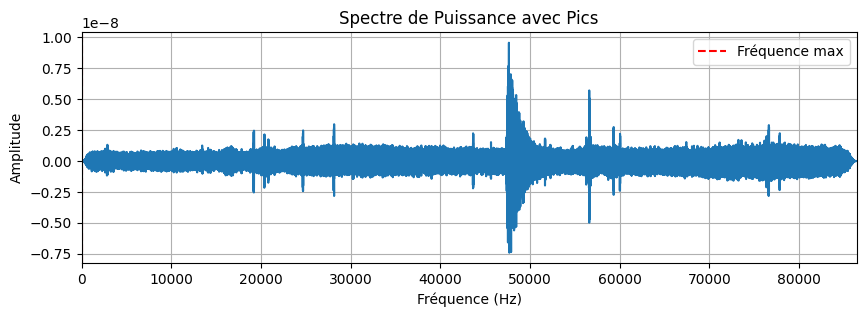

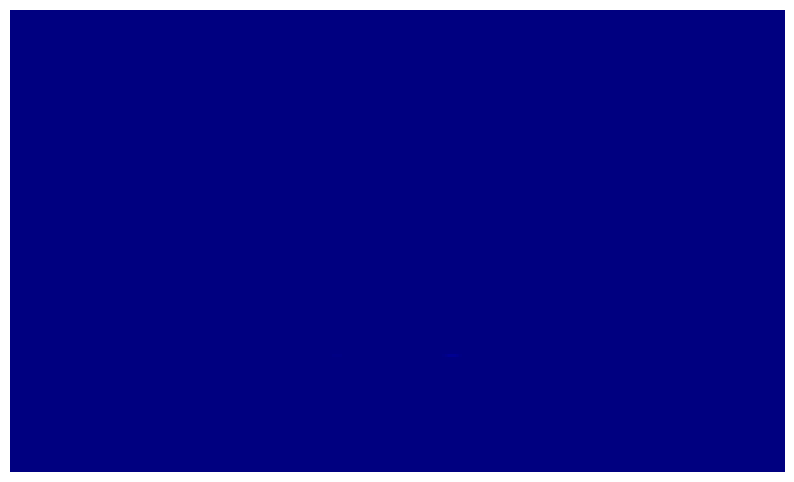

Largeur à mi-hauteur (FWHM) : 3.4722100901163344e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.004192872117406263
Fréquence maximale : 0.8281221064915916 Hz
Amplitude maximale : 2.0876254442444792e-11
0.8280873843906904 0.8281568285924927


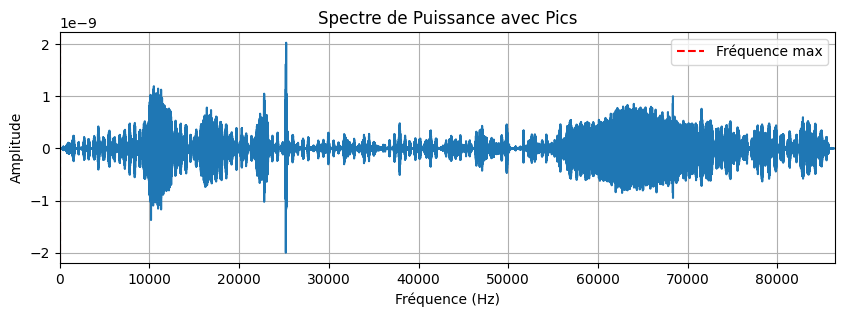

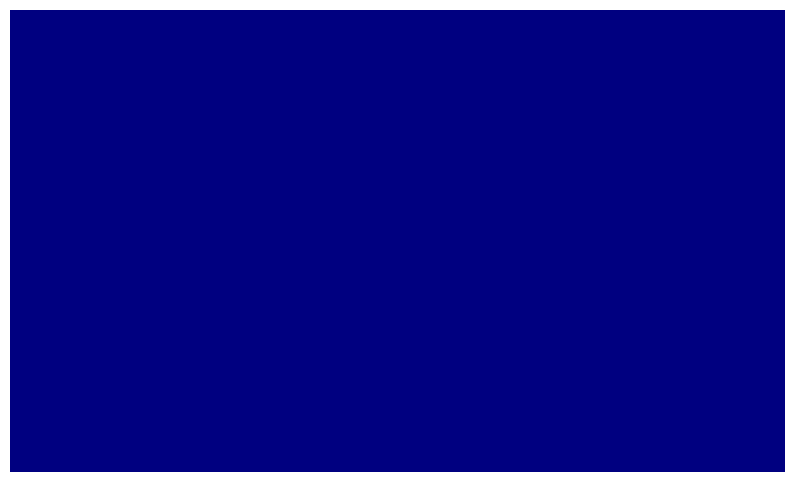

Largeur à mi-hauteur (FWHM) : 0.12696426543678974
Pourcentage basé sur la largeur à mi-hauteur : 15.331292887789468
Fréquence maximale : 0.8281380204921255 Hz
Amplitude maximale : 8.190559377292484e-12
0.7011737550553357 0.9551022859289152


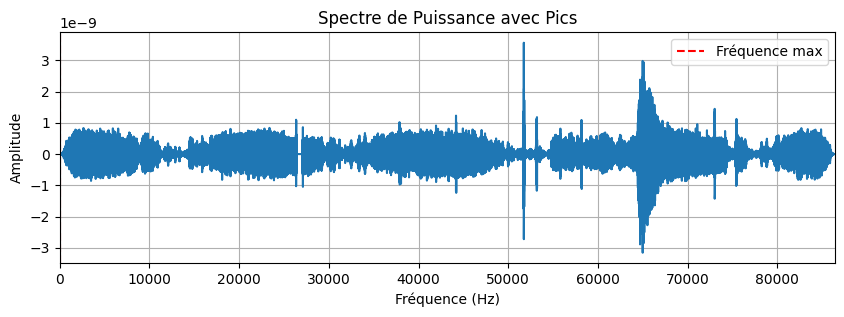

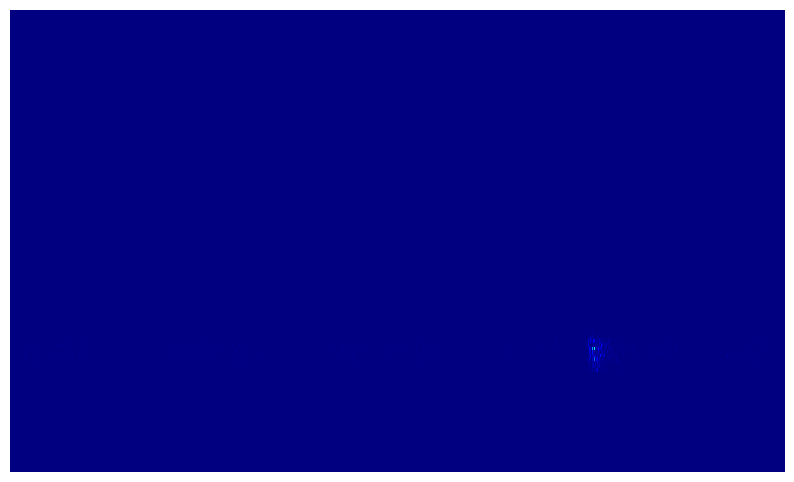

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-02-21HR00_evid00190.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-03-14HR00_evid00506.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-01-26HR00_evid00186.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1975-05-20HR00_evid00652.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281221064107088 Hz
Amplitude maximale : 6.991721514342616e-11
0.7867160010901734 0.8695282117312443


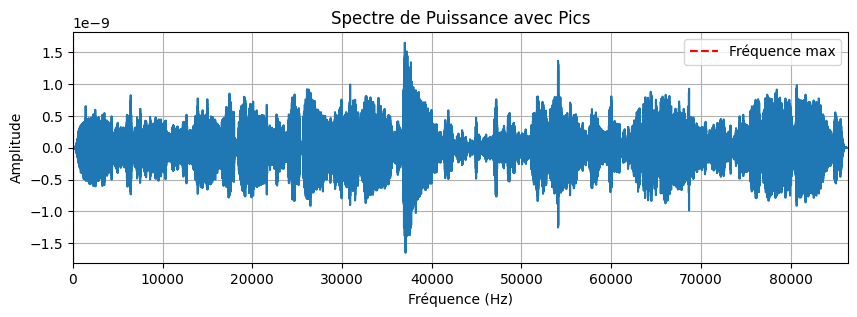

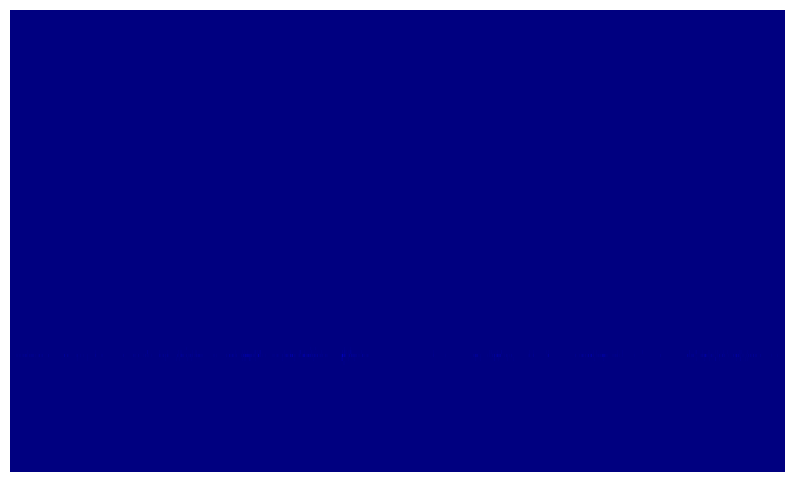

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-02-18HR00_evid00016.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 2.611498283636017e-11
0.7867201244236975 0.8695327690998763


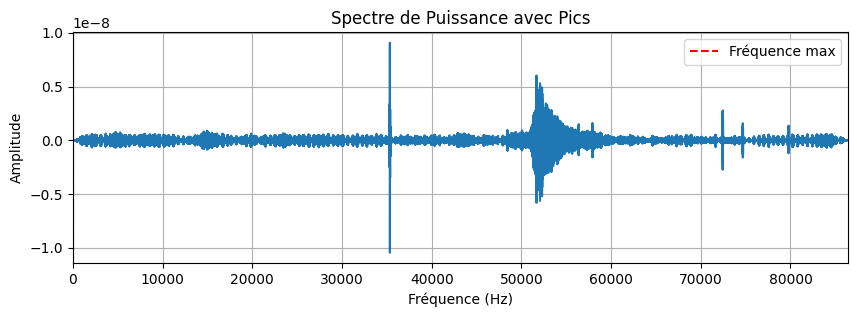

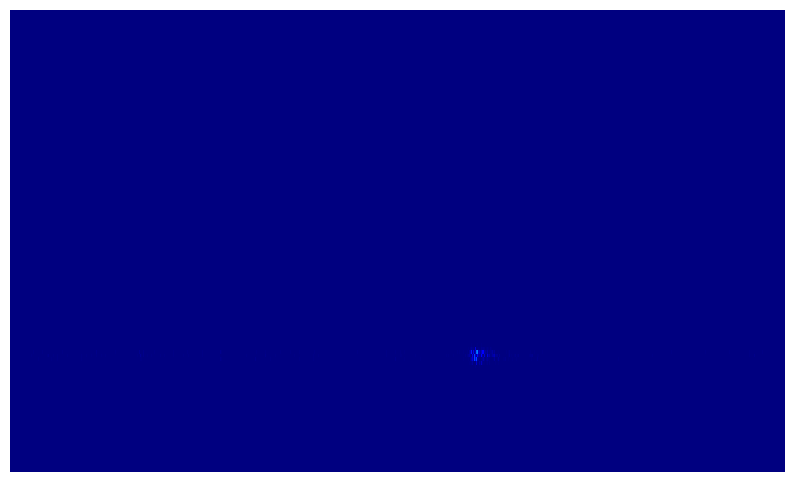

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-11-19HR00_evid00335.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-03-15HR00_evid00073.csv
Largeur à mi-hauteur (FWHM) : 6.944262466912487e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.008385509838993383
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 2.1158204124449163e-11
0.8280570040966782 0.8281958893460164


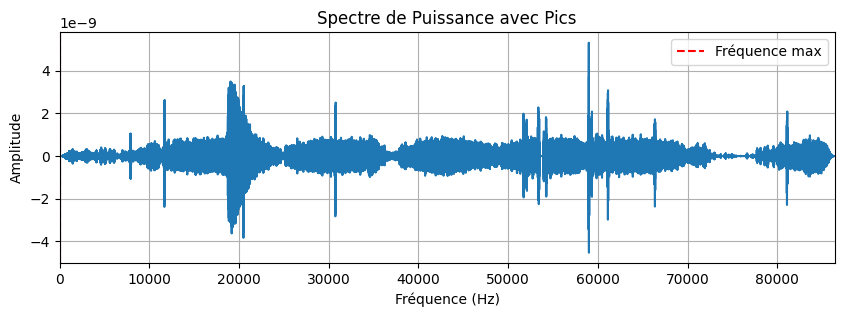

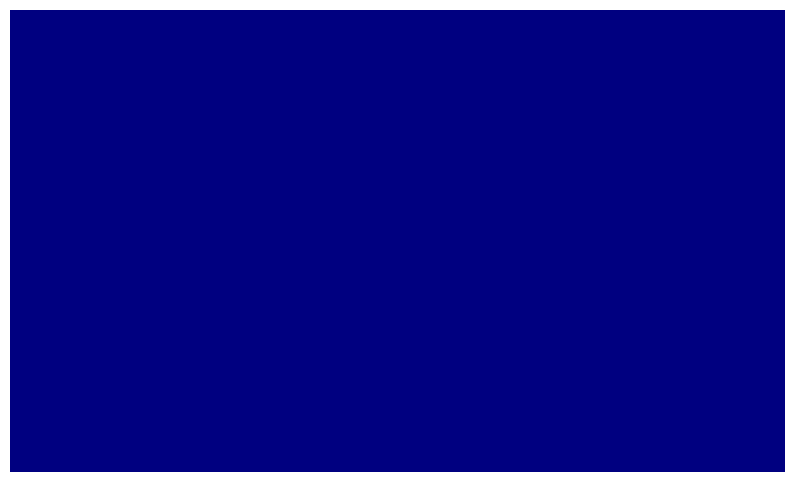

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-14HR00_evid00018.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281221058848609 Hz
Amplitude maximale : 6.171969247721408e-11
0.7867160005906179 0.869528211179104


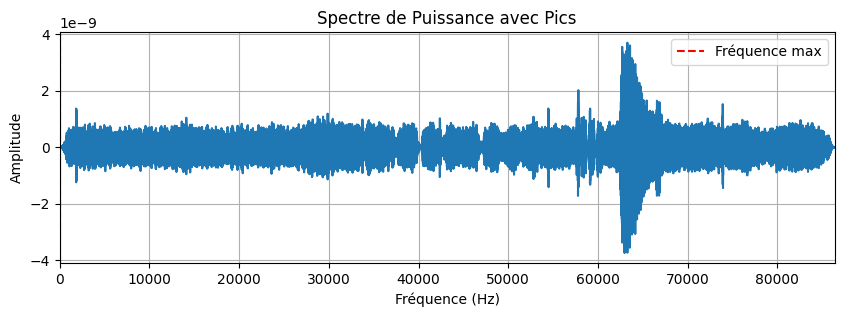

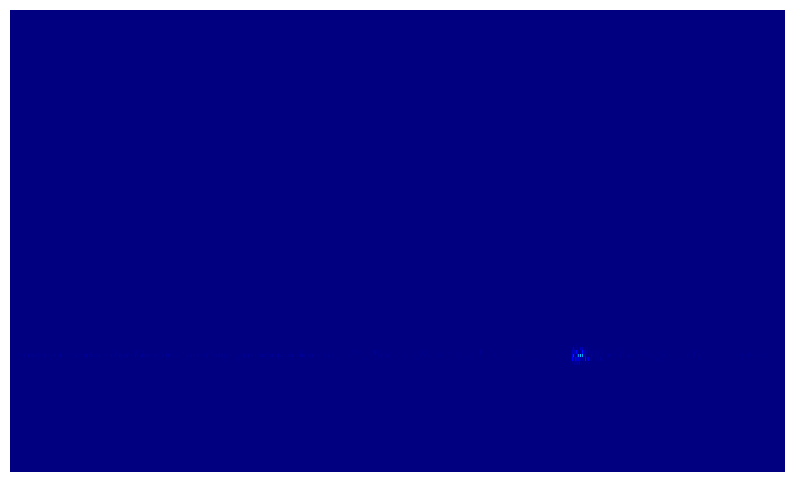

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-10-26HR00_evid00133.csv
Largeur à mi-hauteur (FWHM) : 1.1573609026815923e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.0013975654409927147
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 3.176542905667209e-11
0.8281148730921015 0.8281380203101552


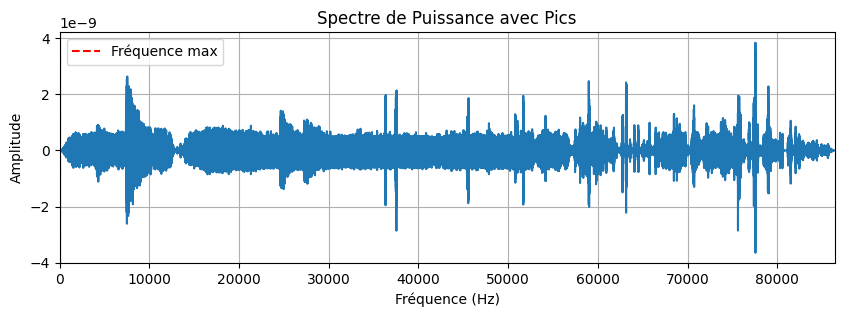

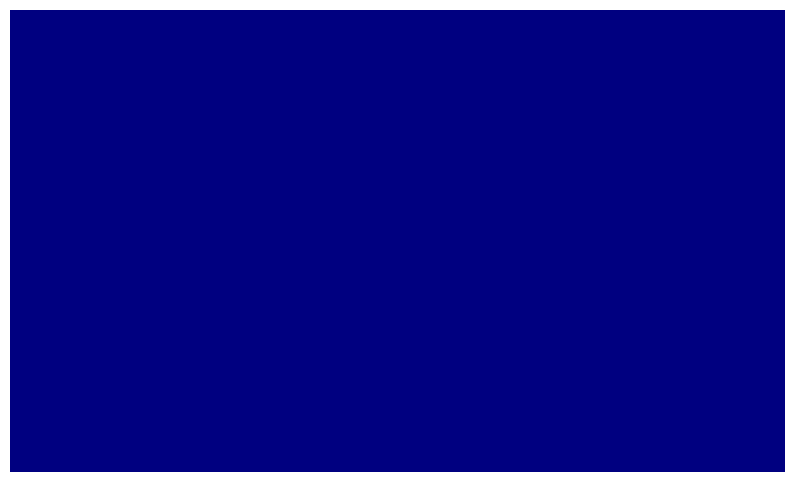

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-11-24HR00_evid00156.csv
Largeur à mi-hauteur (FWHM) : 0.1925991195199287
Pourcentage basé sur la largeur à mi-hauteur : 23.257211538461537
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 1.2517528751558535e-11
0.6355273272014186 1.020725566241276


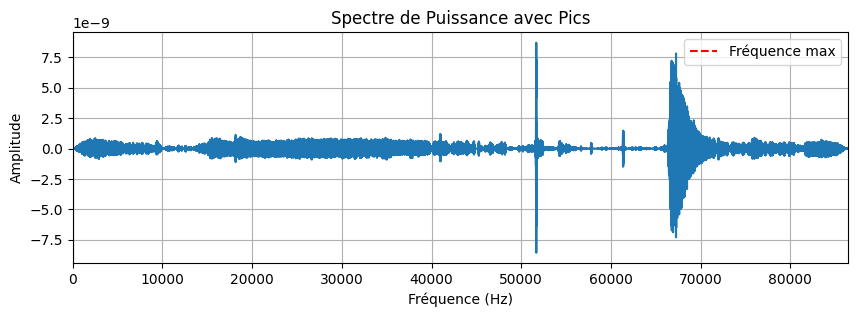

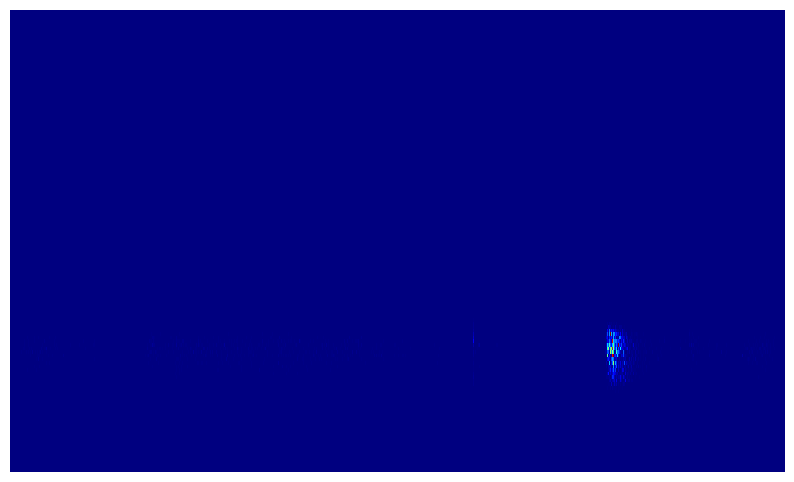

Largeur à mi-hauteur (FWHM) : 4.629467873240589e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.005590339892666271
Fréquence maximale : 0.8281192131651586 Hz
Amplitude maximale : 1.2766475372151461e-11
0.8280729184864262 0.828165507843891


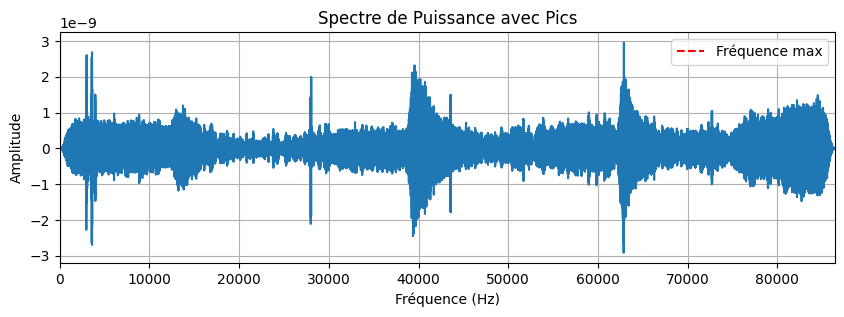

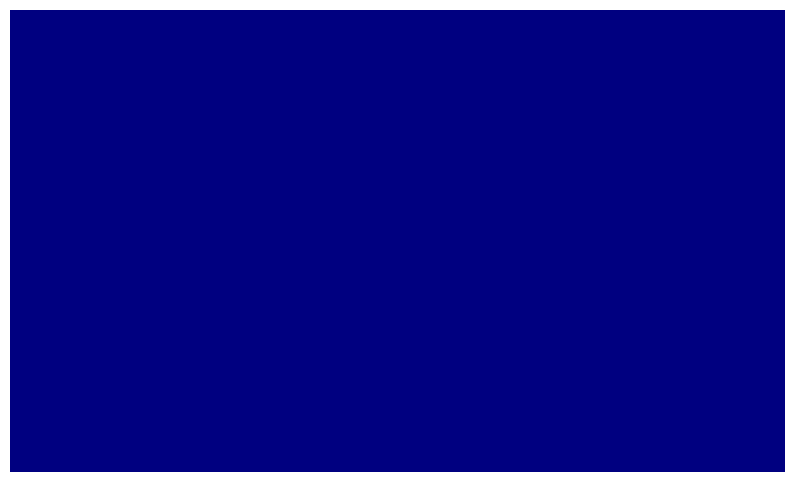

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-07-17HR00_evid00035.csv
Largeur à mi-hauteur (FWHM) : 0.7513765947448321
Pourcentage basé sur la largeur à mi-hauteur : 90.73274356071722
Fréquence maximale : 0.8281206599269427 Hz
Amplitude maximale : 4.497007330477286e-12
0.07674406518211063 1.5794972546717747


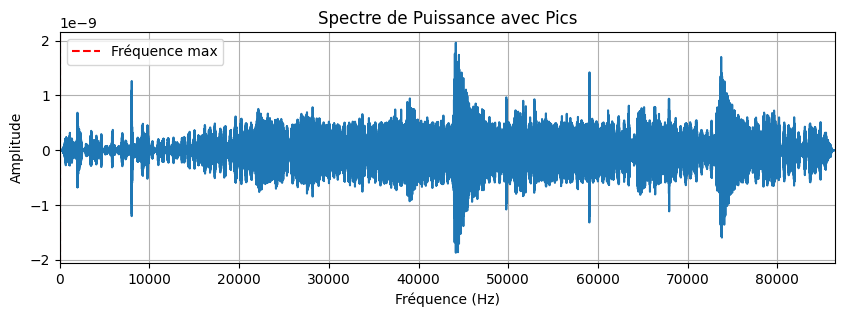

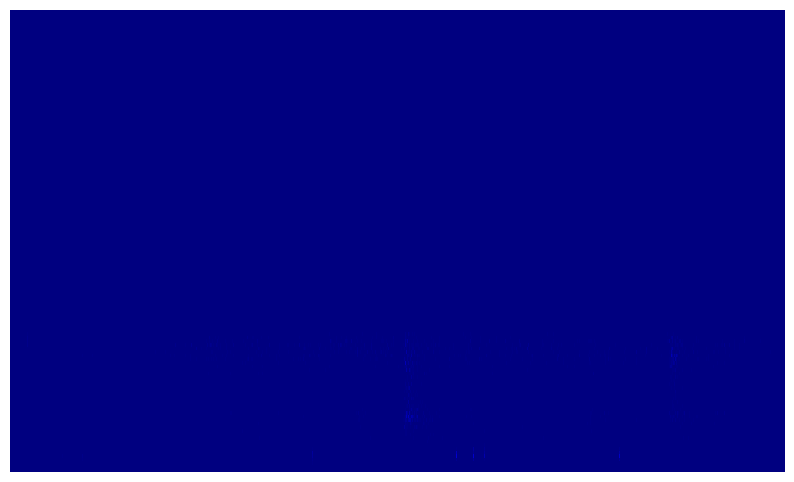

Largeur à mi-hauteur (FWHM) : 6.944310993317604e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.008385744234792238
Fréquence maximale : 0.8281090859539736 Hz
Amplitude maximale : 1.1990417854092803e-11
0.8280396428440404 0.8281785290639068


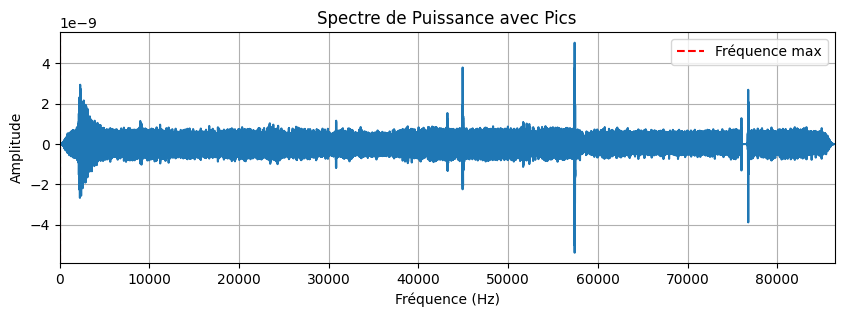

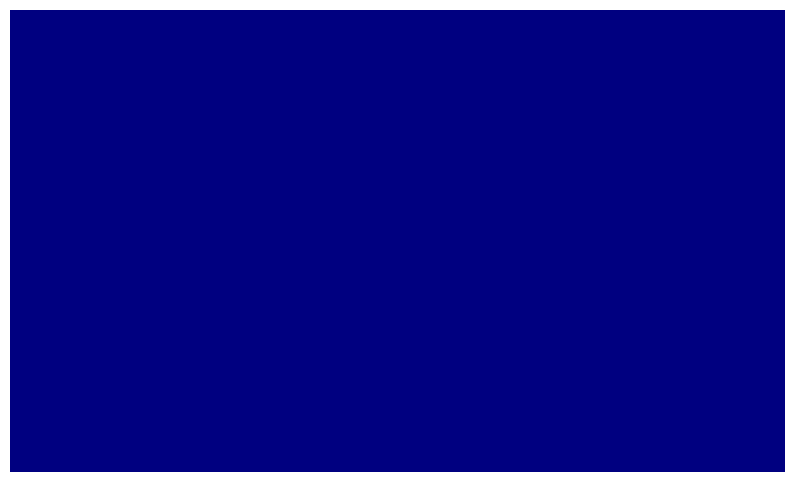

Largeur à mi-hauteur (FWHM) : 0.927617361316145
Pourcentage basé sur la largeur à mi-hauteur : 782.3701679031628
Fréquence maximale : 0.11856502195147092 Hz
Amplitude maximale : 3.0269392027775646e-12
0.0001 1.0461823832676158


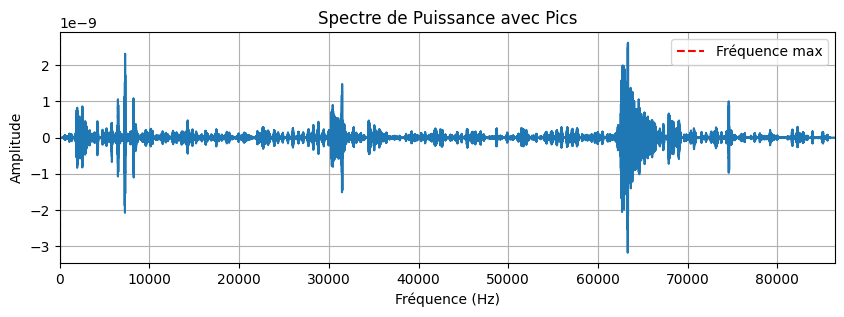

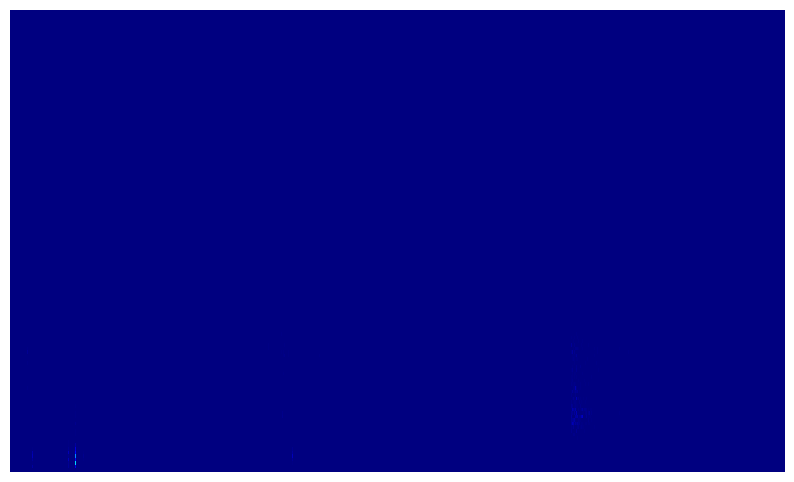

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-24HR00_evid00028.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-12-02HR00_evid00341.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-07-18HR00_evid00036.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-07-27HR00_evid00039.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 8.998591322523542e-11
0.7867201243852799 0.8695327690574146


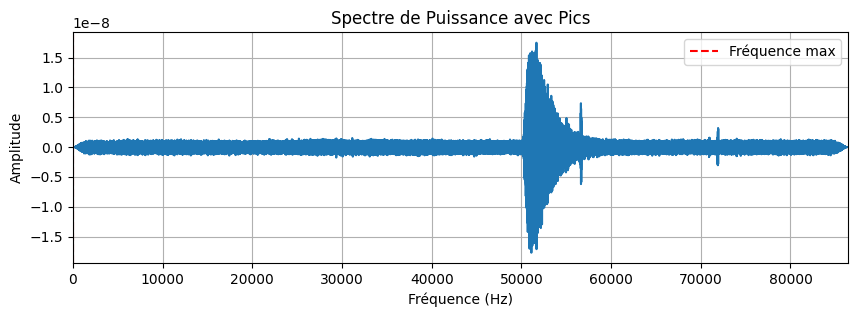

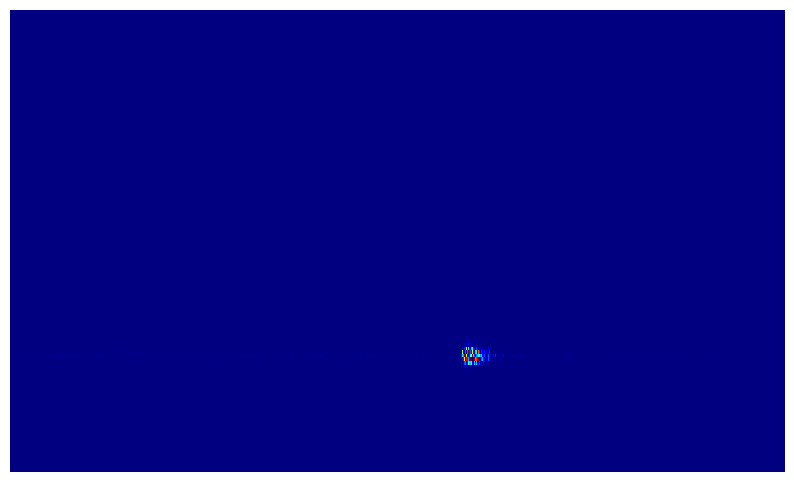

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-11-14HR00_evid00331.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1977-09-13HR00_evid01012.csv
Largeur à mi-hauteur (FWHM) : 1.1574276280179596e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.001397643572938561
Fréquence maximale : 0.8281278935690701 Hz
Amplitude maximale : 3.014590632156329e-11
0.82811631929279 0.8281394678453503


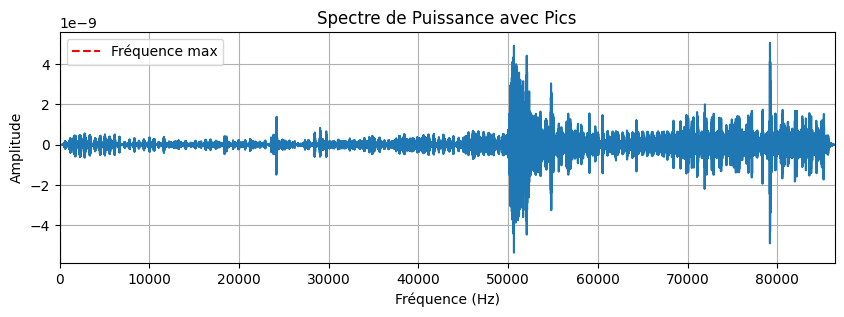

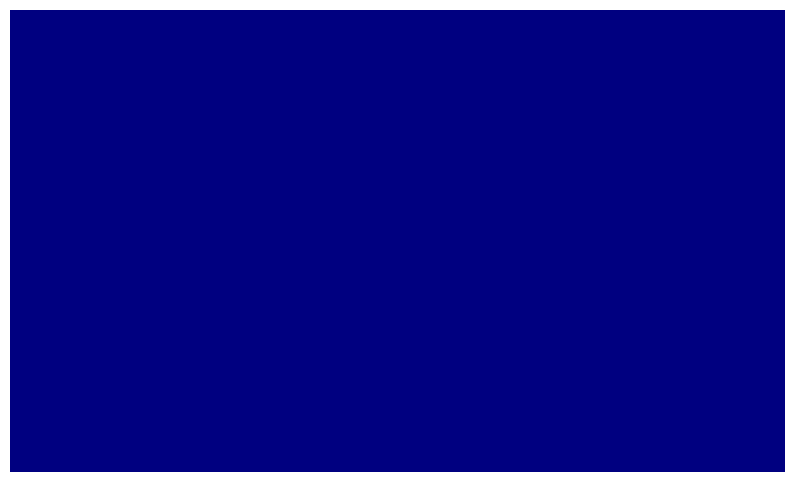

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281220654365569 Hz
Amplitude maximale : 1.0582227860927068e-10
0.786715962164729 0.8695281687083847


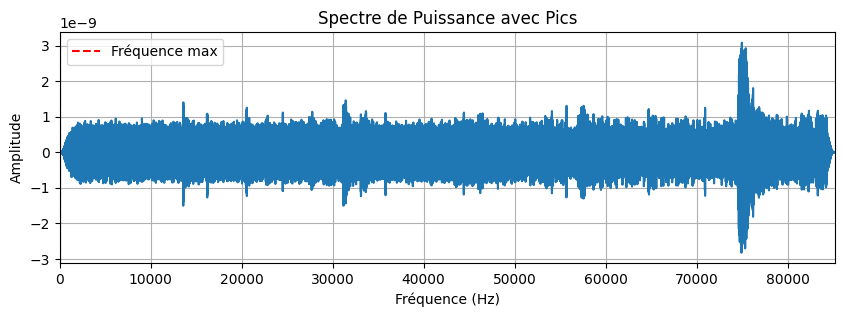

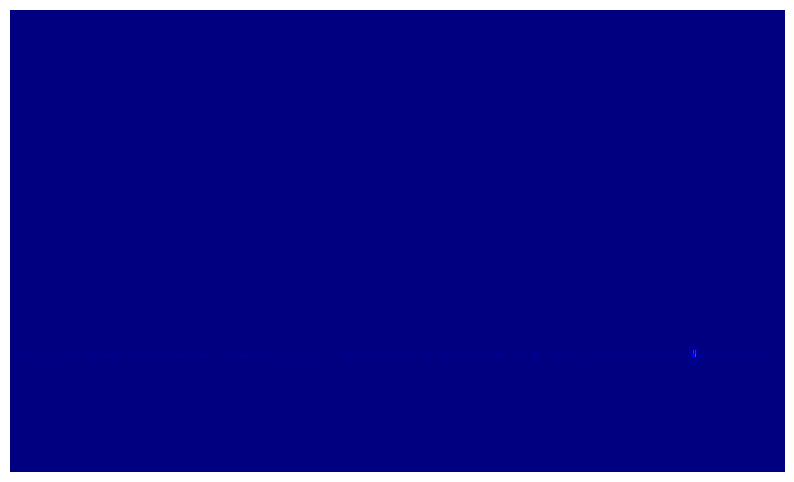

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-20HR00_evid00026.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-04-03HR00_evid00021.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1975-06-15HR00_evid00660.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-06-19HR00_evid00031.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-06-11HR00_evid00096.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 3.315340318910606e-11
0.7867201244236975 0.8695327690998763


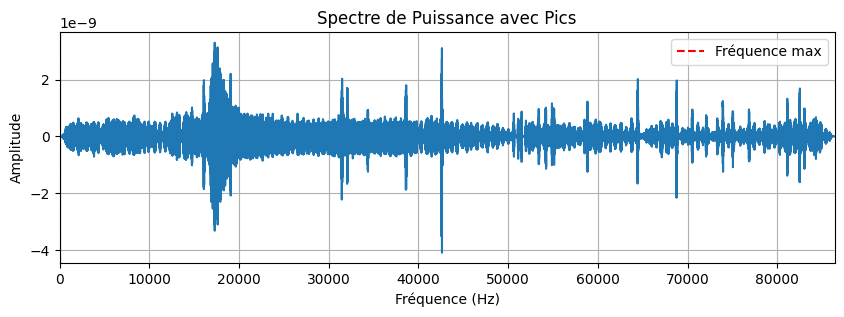

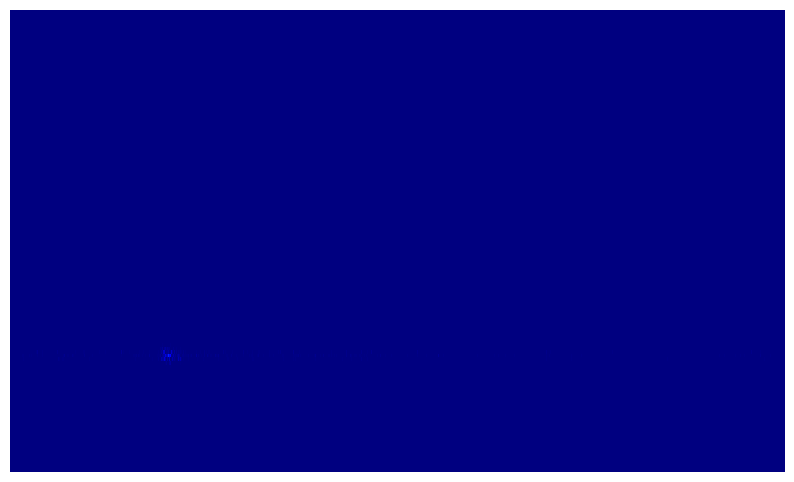

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1973-08-08HR00_evid00437.csv
Largeur à mi-hauteur (FWHM) : 0.130528302743799
Pourcentage basé sur la largeur à mi-hauteur : 15.76196332737029
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 1.4260635508214985e-11
0.6975938038286708 0.9586504093162688


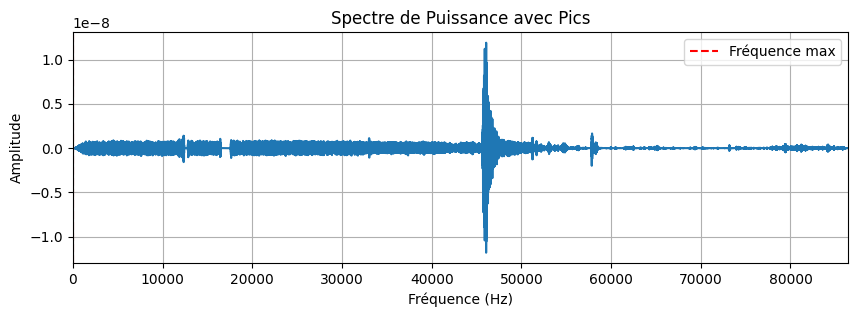

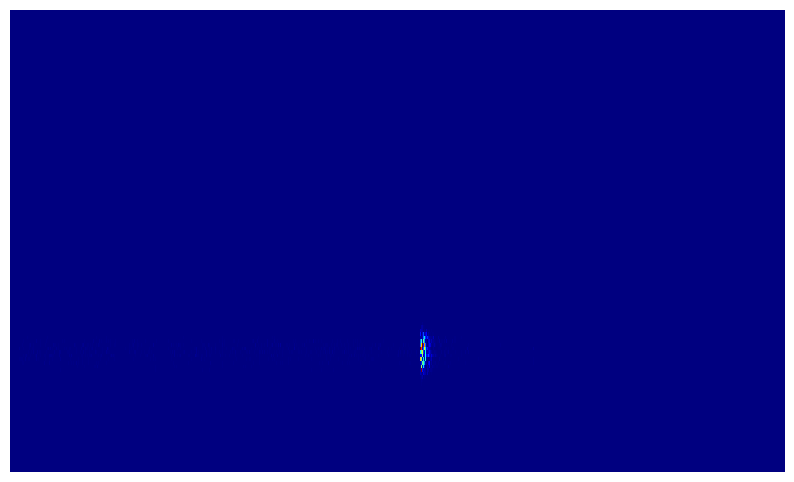

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-10-26HR00_evid00049.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-07-20HR00_evid00037.csv
Largeur à mi-hauteur (FWHM) : 0.8845370054942656
Pourcentage basé sur la largeur à mi-hauteur : 98.21499710852663
Fréquence maximale : 0.9006129731051773 Hz
Amplitude maximale : 5.3324973864152886e-12
0.01607596761091168 1.785149978599443


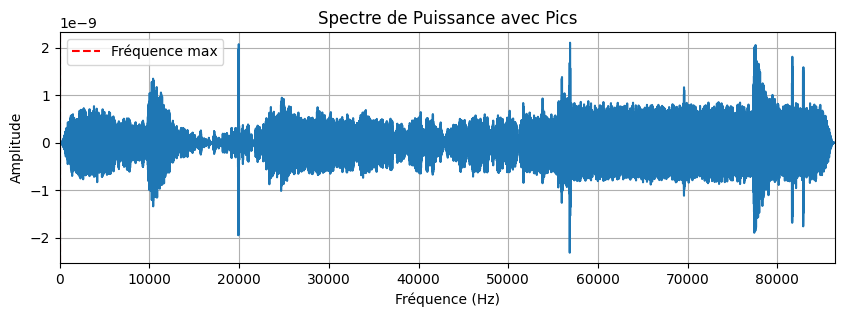

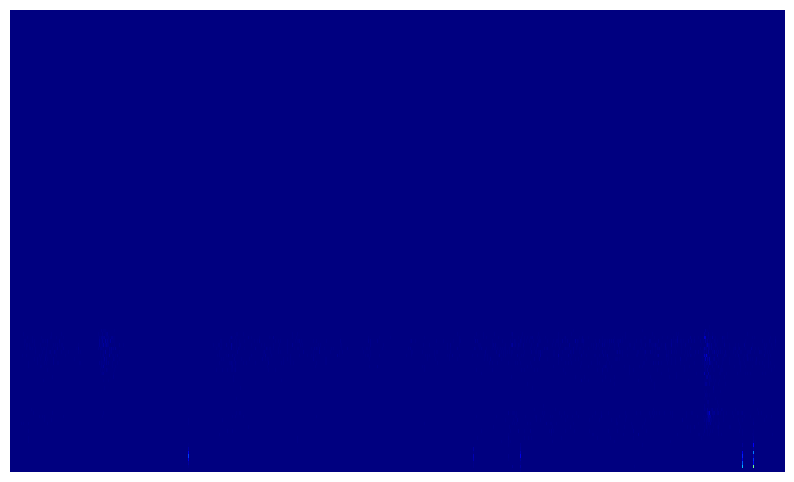

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1973-11-22HR00_evid00475.csv
Largeur à mi-hauteur (FWHM) : 0.029049758657496372
Pourcentage basé sur la largeur à mi-hauteur : 3.507889256914465
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 9.746713340442138e-12
0.799076688043632 0.8571762053586247


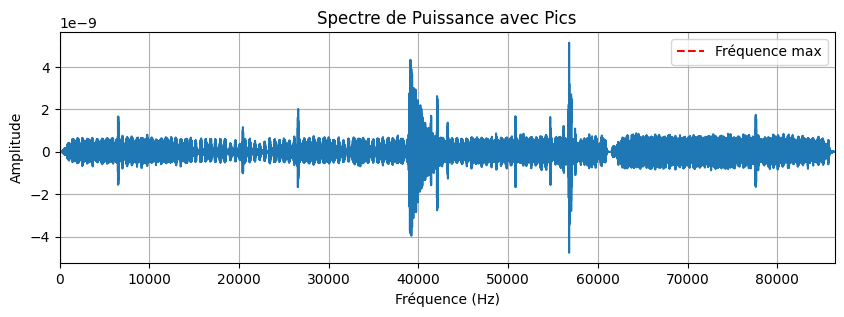

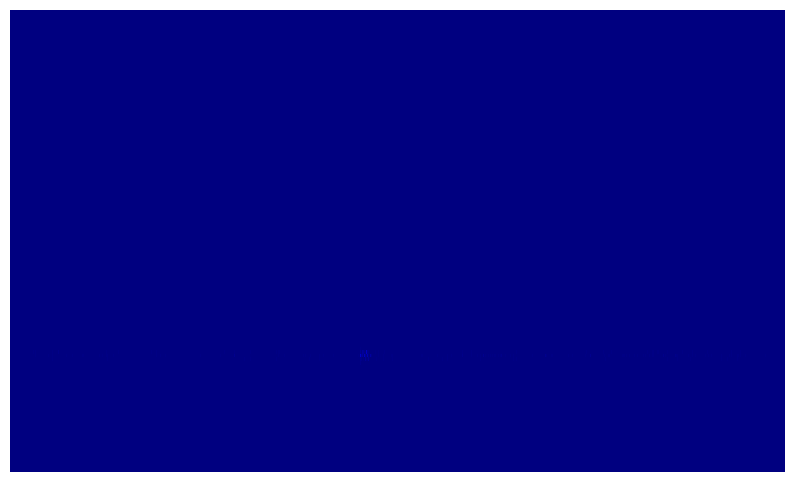

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-02-07HR00_evid00014.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-09-09HR00_evid00043.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-01-03HR00_evid00057.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-01-17HR00_evid00060.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1973-03-12HR00_evid00384.csv
Largeur à mi-hauteur (FWHM) : 4.629467873240589e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.005590339892666271
Fréquence maximale : 0.8281192131651586 Hz
Amplitude maximale : 1.2766475372151461e-11
0.8280729184864262 0.828165507843891


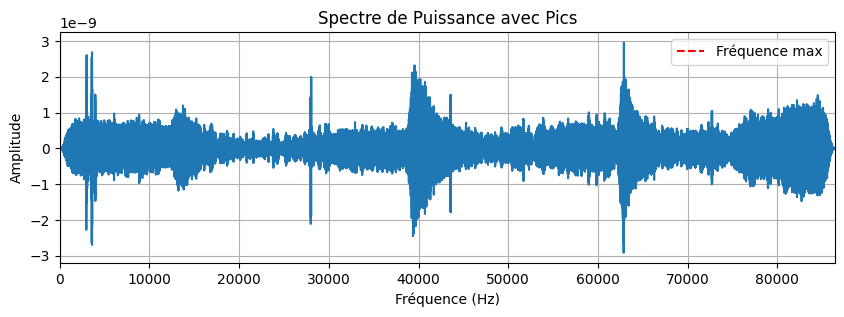

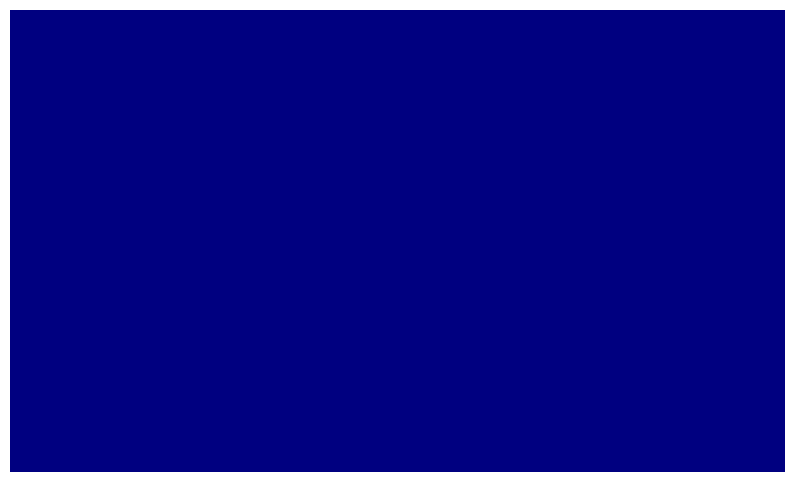

Largeur à mi-hauteur (FWHM) : 0.9474867447568636
Pourcentage basé sur la largeur à mi-hauteur : 819.5515066573231
Fréquence maximale : 0.1156103963033813 Hz
Amplitude maximale : 1.0582547510802324e-11
0.0001 1.0630971410602448


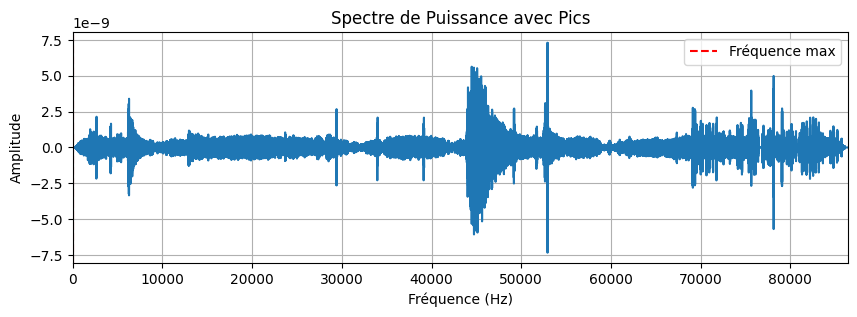

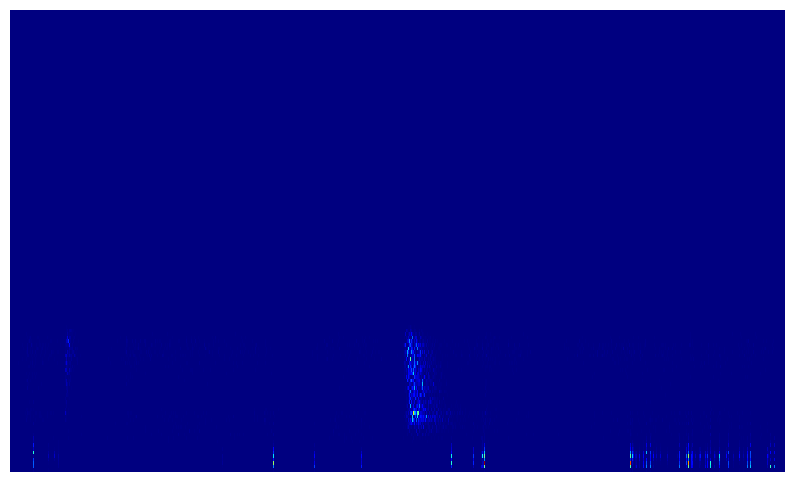

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281221064915916 Hz
Amplitude maximale : 1.2793898327227202e-10
0.786716001167012 0.8695282118161711


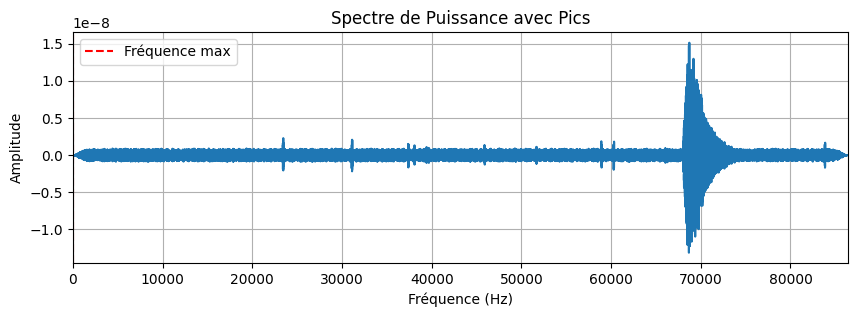

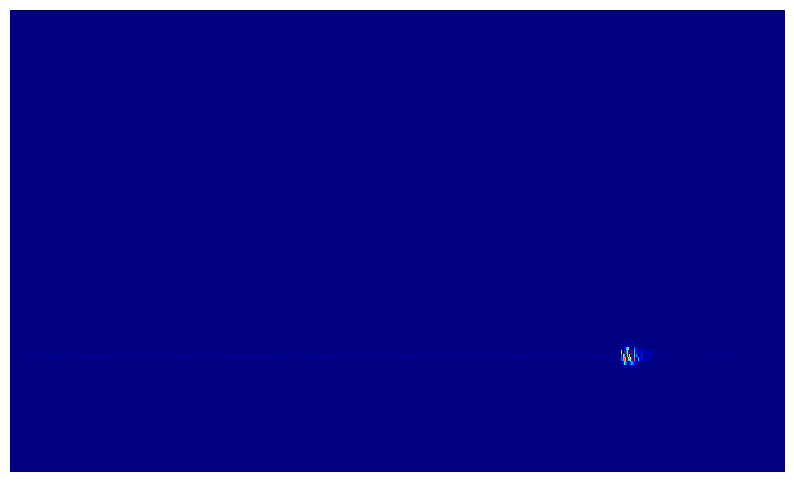

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-06-27HR00_evid00101.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-11-03HR00_evid00050.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 4.386069919180174e-11
0.786720124366072 0.8695327690361847


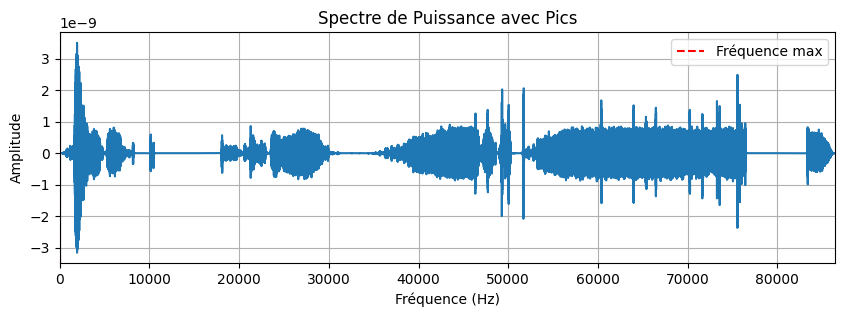

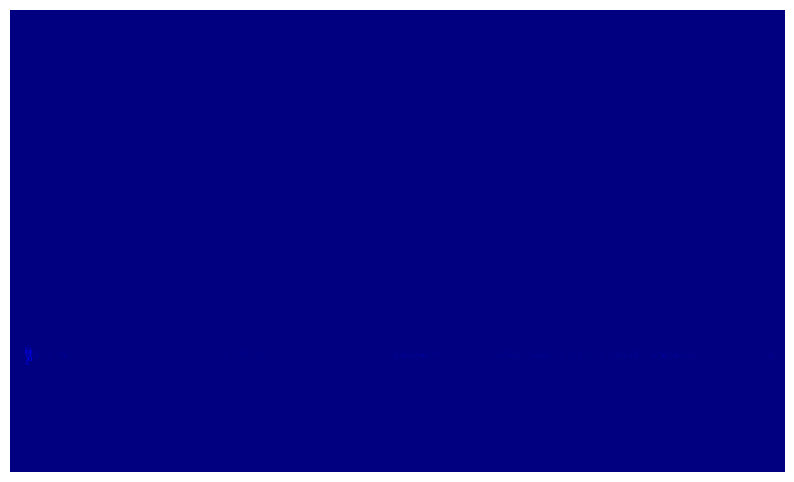

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 3.006526807763699e-11
0.786720124366072 0.8695327690361847


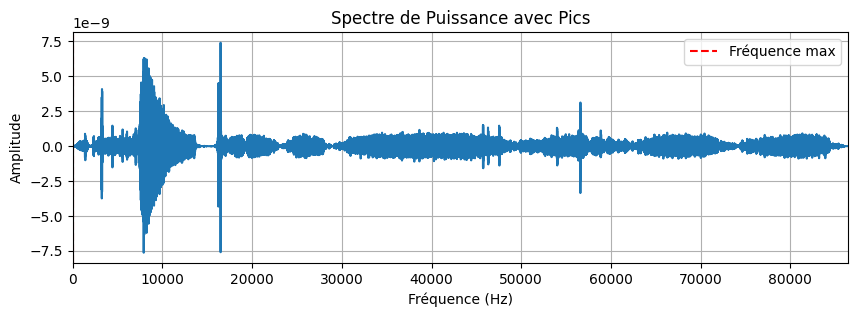

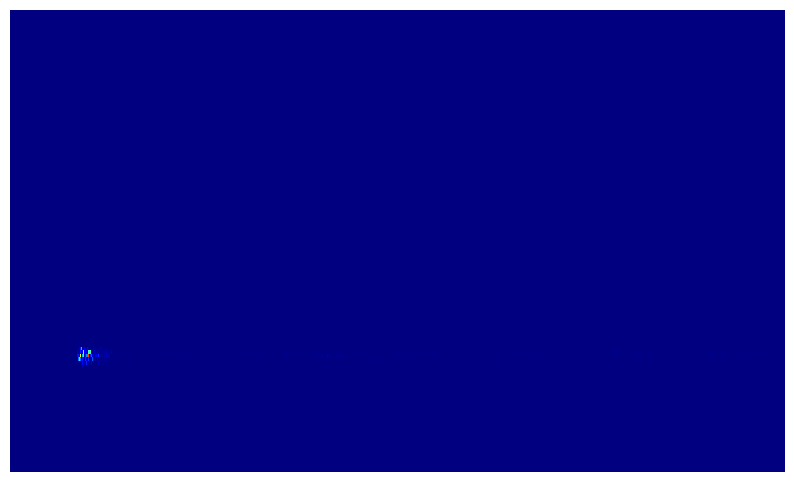

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-30HR00_evid00020.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 3.2113946745939226e-11
0.786720124366072 0.8695327690361847


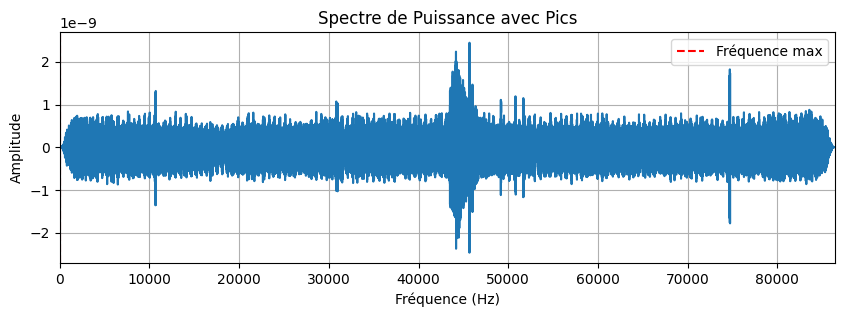

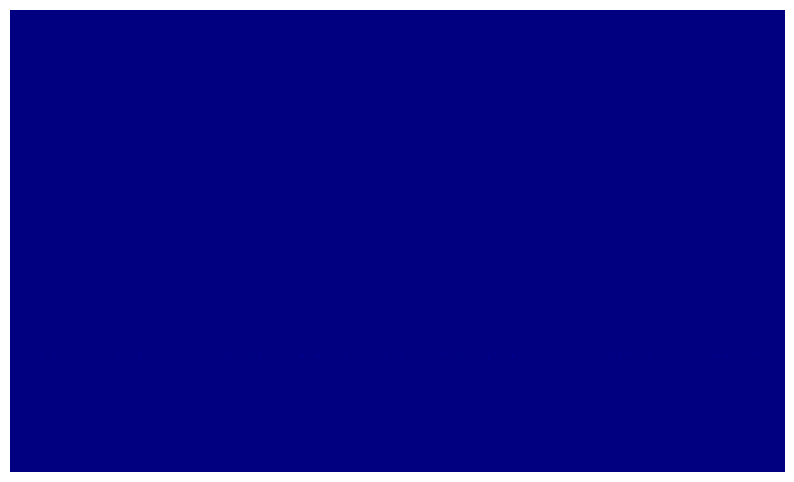

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1975-05-16HR00_evid00651.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-06-30HR00_evid00543.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1973-10-03HR03_evid00461.csv
Largeur à mi-hauteur (FWHM) : 3.472113036273594e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.004192754919494166
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 4.39324309915546e-11
0.828087385442107 0.8281568277028325


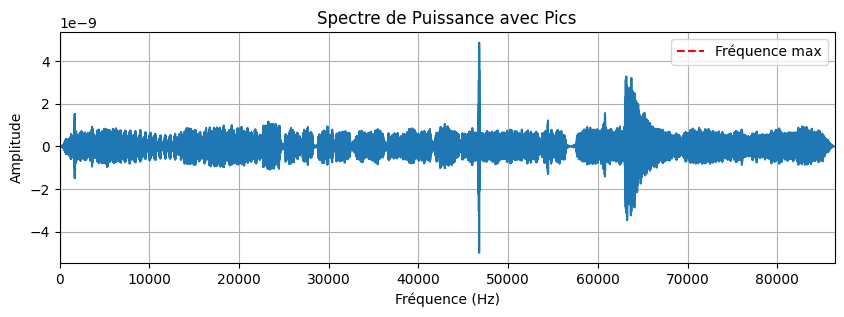

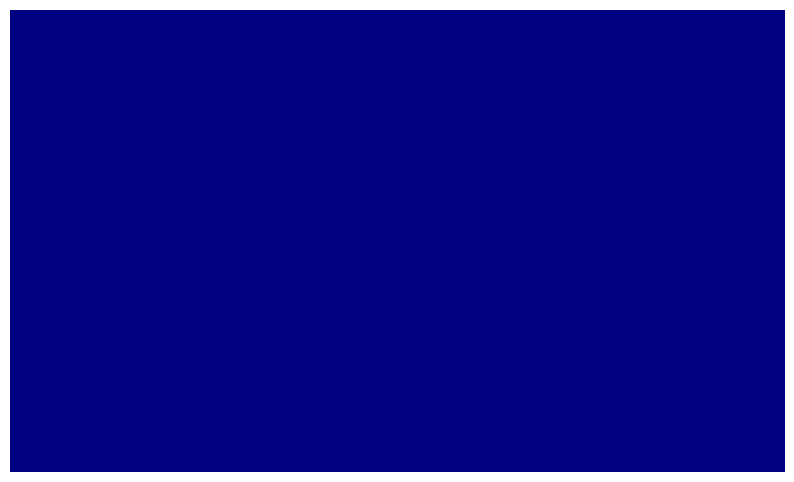

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-10-02HR00_evid00572.csv
Largeur à mi-hauteur (FWHM) : 0.13508219848181768
Pourcentage basé sur la largeur à mi-hauteur : 16.31189813973641
Fréquence maximale : 0.8281206596843089 Hz
Amplitude maximale : 1.5507637233441454e-11
0.6930384612024912 0.9632028581661266


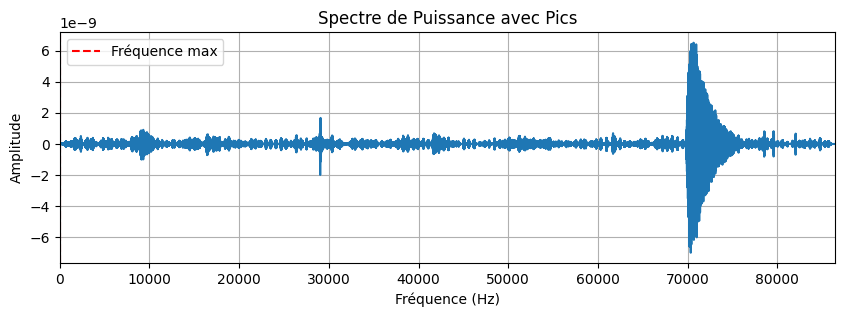

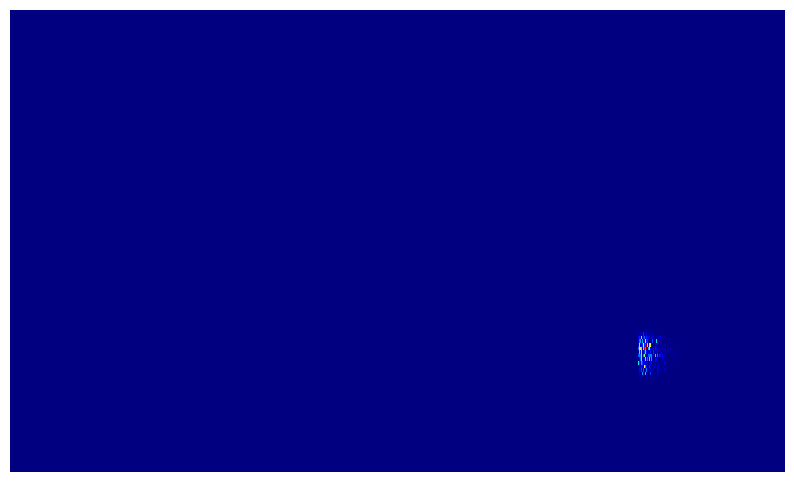

Largeur à mi-hauteur (FWHM) : 0.18307294669280139
Pourcentage basé sur la largeur à mi-hauteur : 22.106999105545615
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 1.1247247330439393e-11
0.6450491598796684 1.0111950532652711


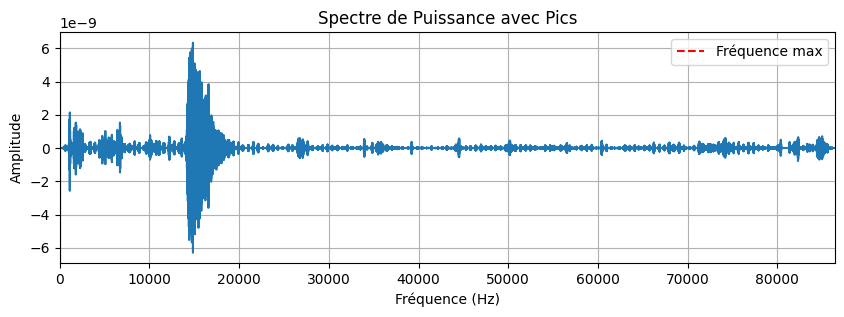

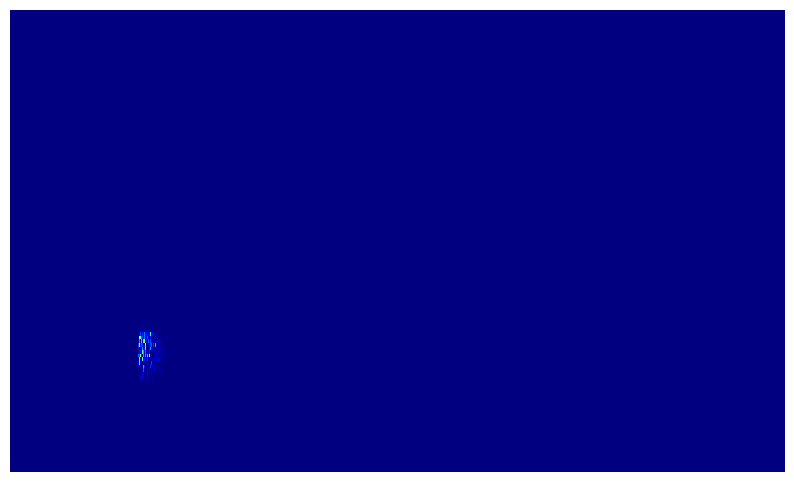

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 5.391231905695721e-11
0.7867160012438463 0.8695282119010932


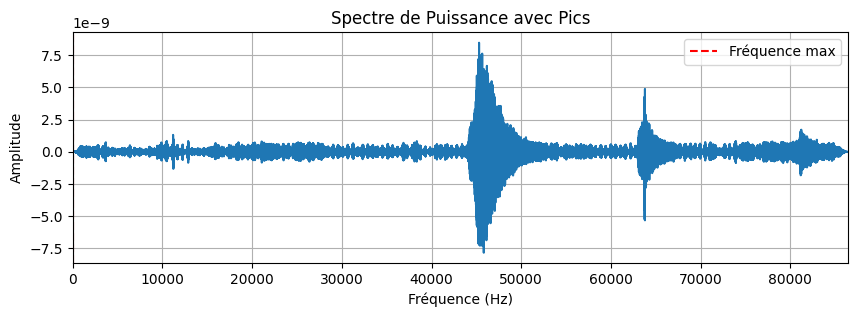

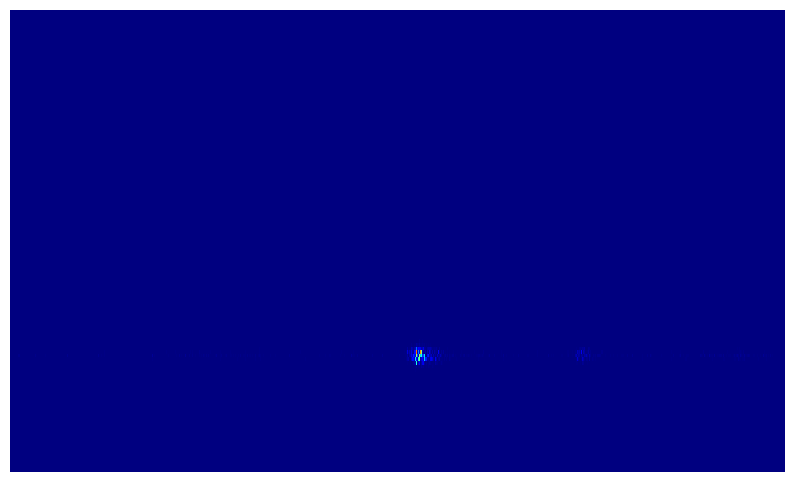

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 1.402431623526011e-10
0.786720124366072 0.8695327690361847


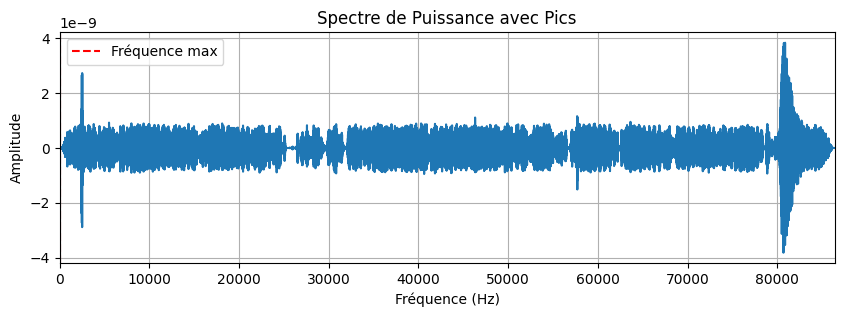

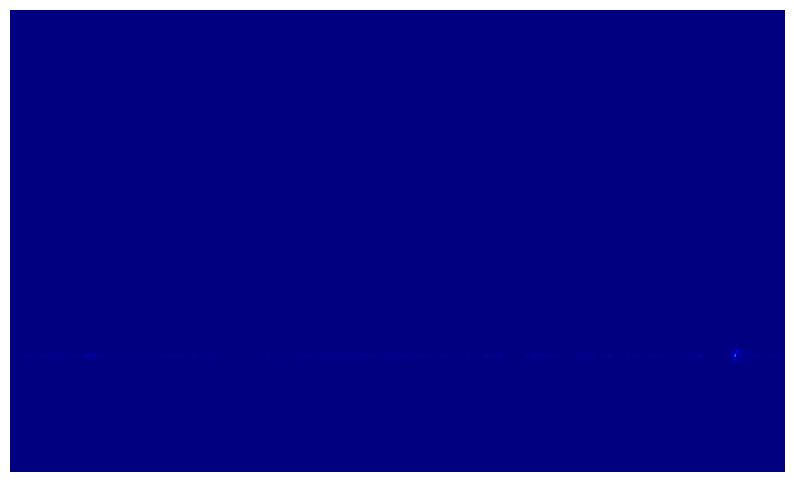

Largeur à mi-hauteur (FWHM) : 0.728377206238175
Pourcentage basé sur la largeur à mi-hauteur : 80.99902182866558
Fréquence maximale : 0.8992419782289299 Hz
Amplitude maximale : 3.8836884440430236e-12
0.1708647719907549 1.6276191844671049


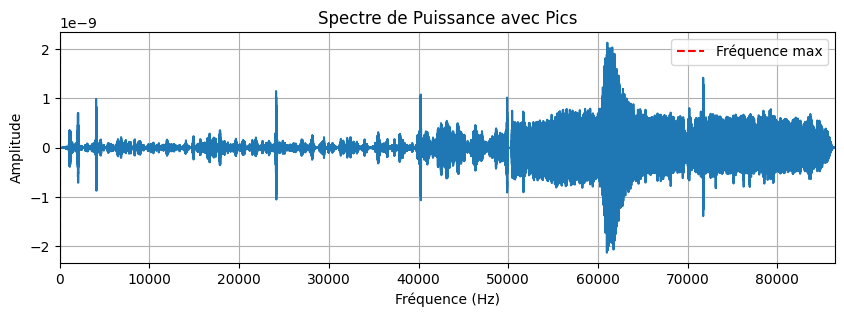

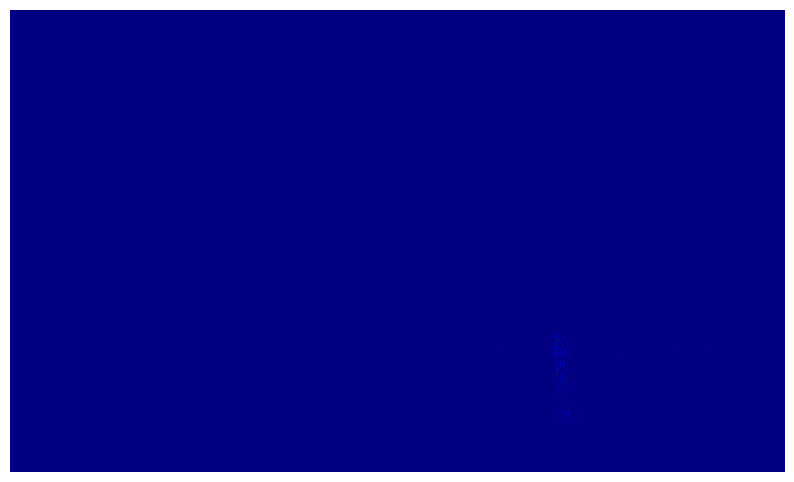

Largeur à mi-hauteur (FWHM) : 0.746459608093397
Pourcentage basé sur la largeur à mi-hauteur : 84.44938382758427
Fréquence maximale : 0.883913622883742 Hz
Amplitude maximale : 7.931753645850156e-12
0.13745401479034502 1.6303732309771388


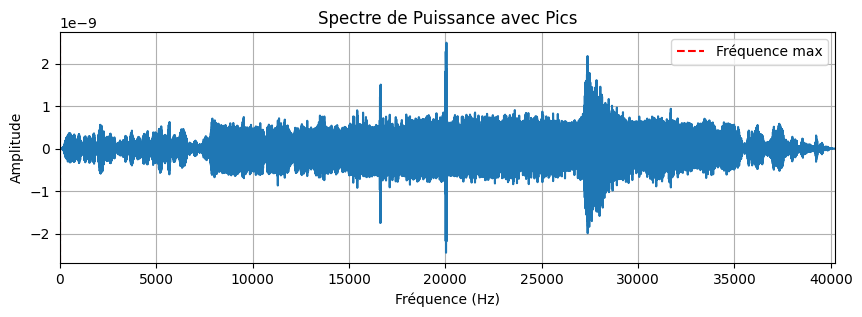

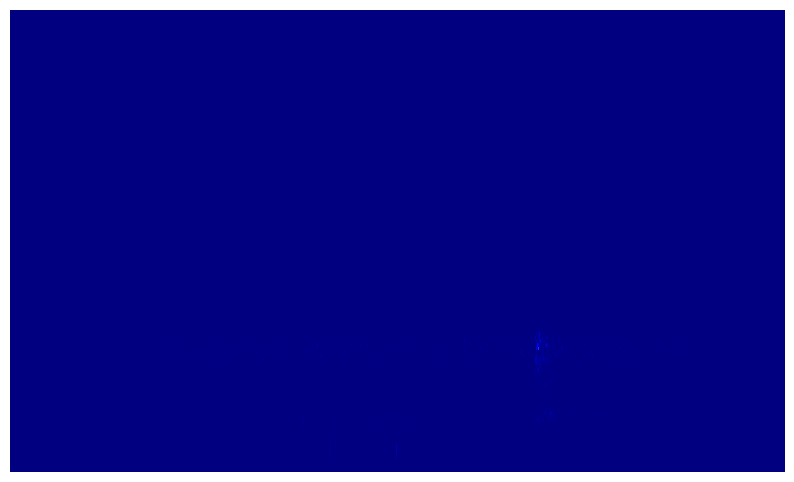

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-01-09HR00_evid00007.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-23HR00_evid00027.csv
Largeur à mi-hauteur (FWHM) : 0.971818992658441
Pourcentage basé sur la largeur à mi-hauteur : 117.3529576204853
Fréquence maximale : 0.8281163188074596 Hz
Amplitude maximale : 1.026163549556509e-11
0.0001 1.7999353114659007


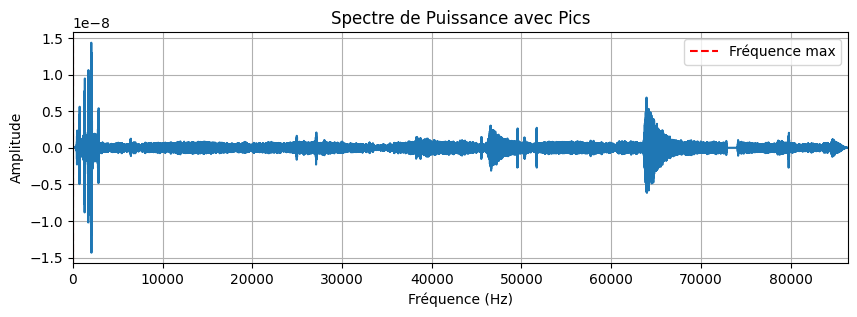

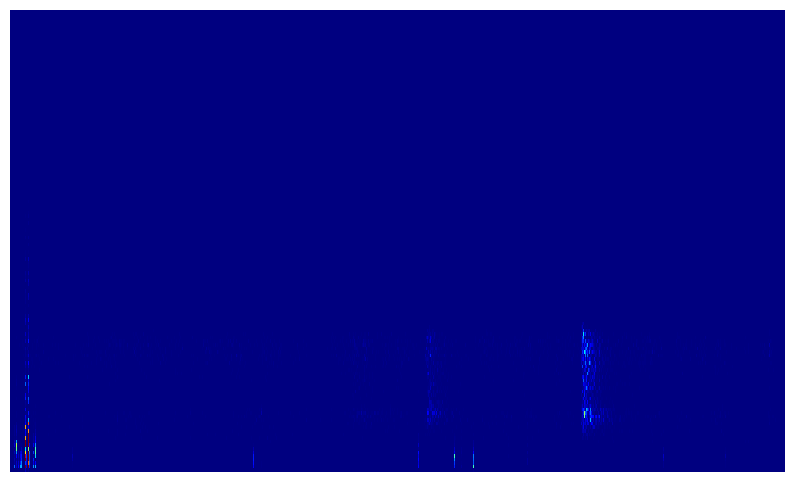

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 9.869698427130319e-11
0.786720124366072 0.8695327690361847


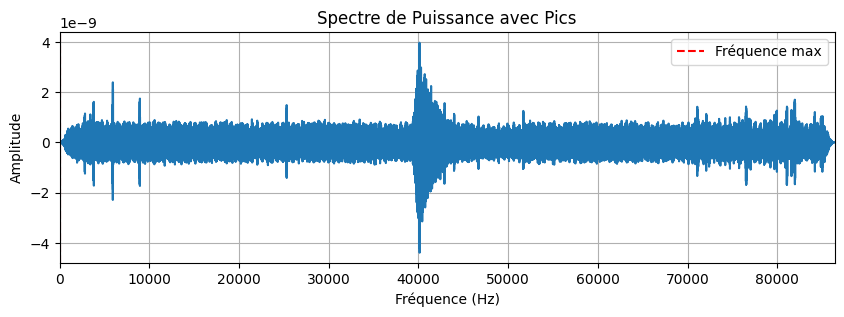

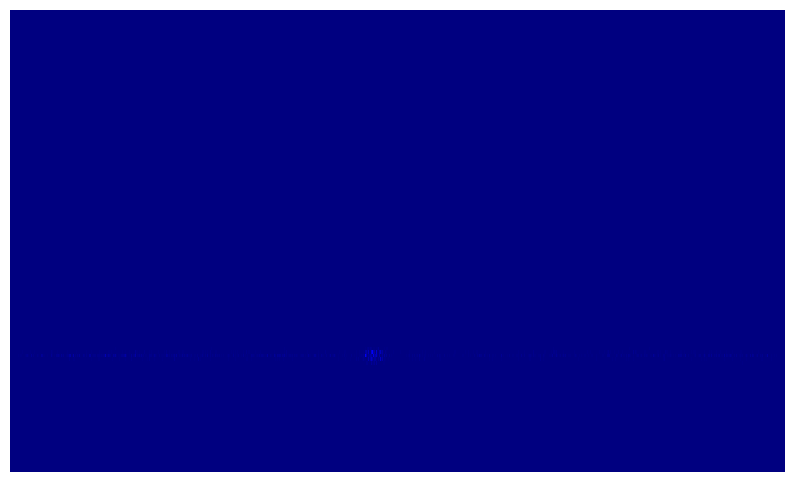

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281221064107088 Hz
Amplitude maximale : 1.3271169866083005e-10
0.7867160010901734 0.8695282117312443


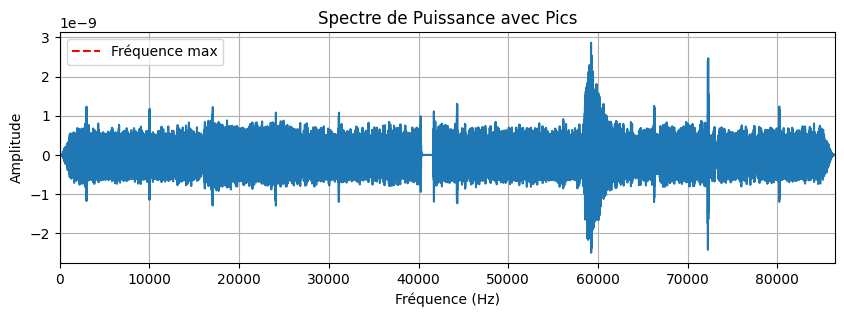

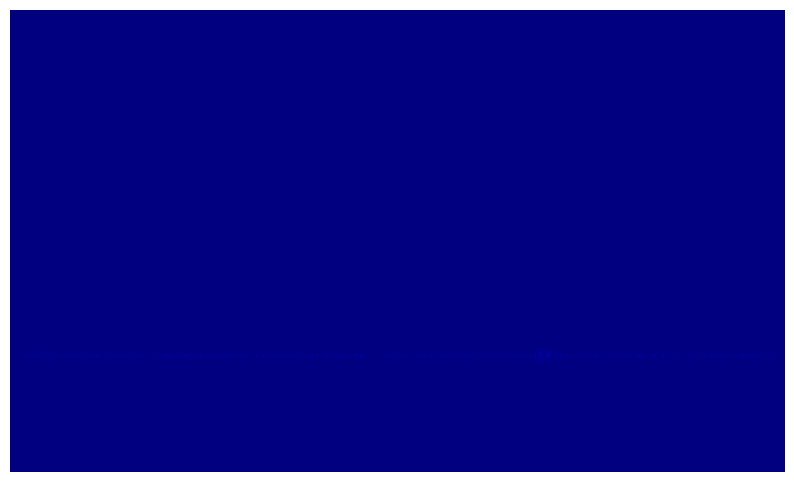

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281265252971394 Hz
Amplitude maximale : 1.32249693392212e-10
0.7867201990322824 0.8695328515619963


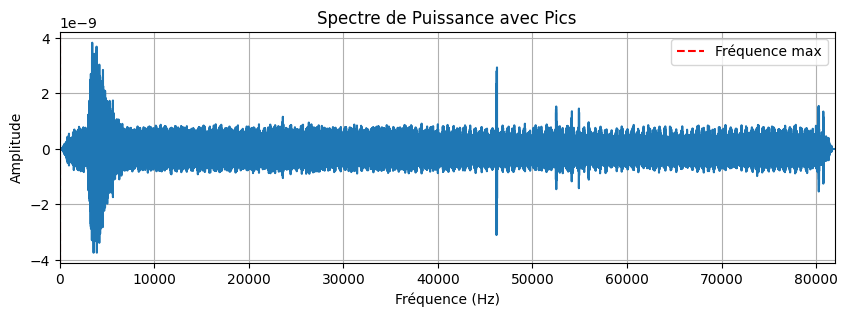

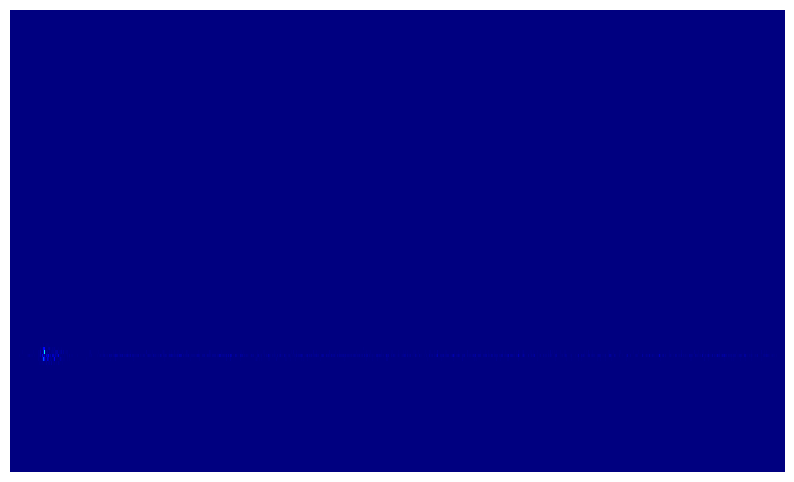

Largeur à mi-hauteur (FWHM) : 0.8122011606801264
Pourcentage basé sur la largeur à mi-hauteur : 98.07694995318155
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 1.691134442038628e-11
0.01592528602100196 1.6403276073812547


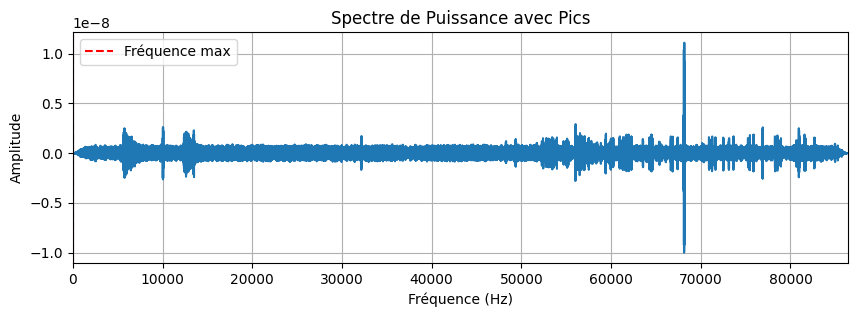

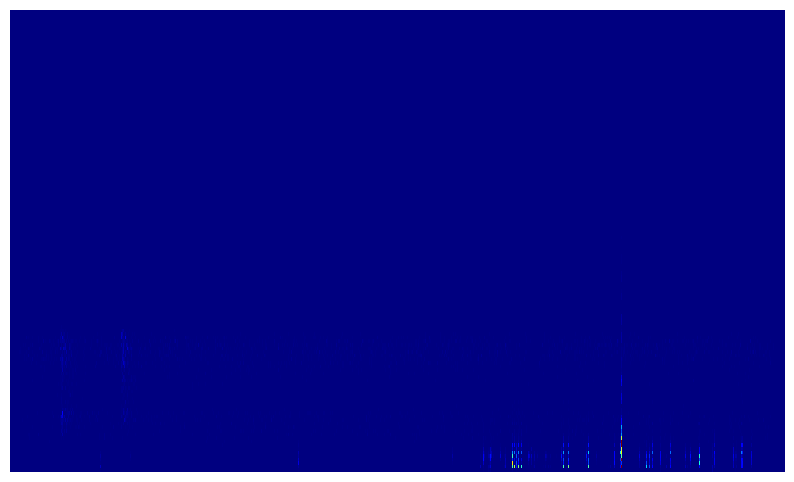

Largeur à mi-hauteur (FWHM) : 0.7948939848152923
Pourcentage basé sur la largeur à mi-hauteur : 95.99155823281947
Fréquence maximale : 0.8280873854421069 Hz
Amplitude maximale : 8.114871496909884e-12
0.03319340062681464 1.6229813702573992


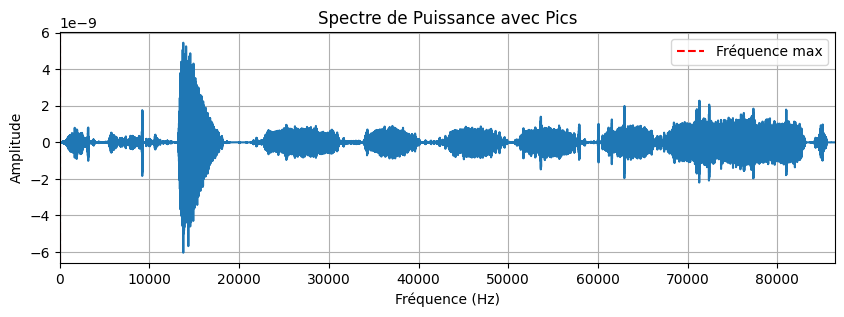

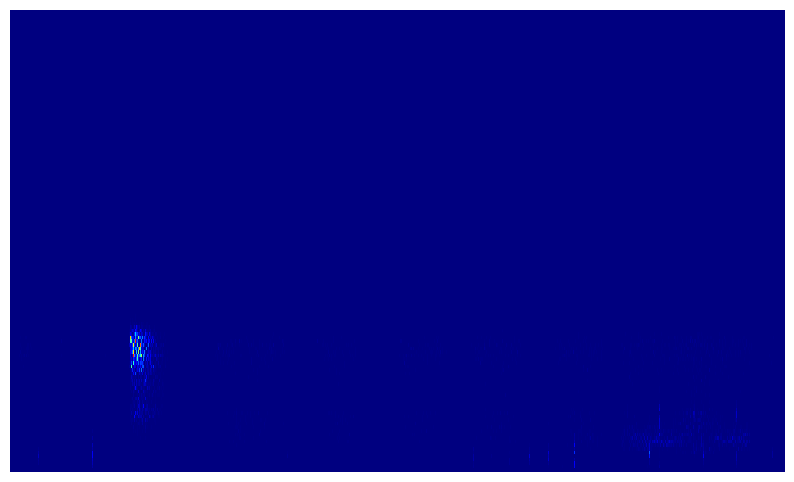

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-05-19HR00_evid00228.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281268341192131 Hz
Amplitude maximale : 9.377989657568921e-11
0.7867204924132524 0.8695331758251738


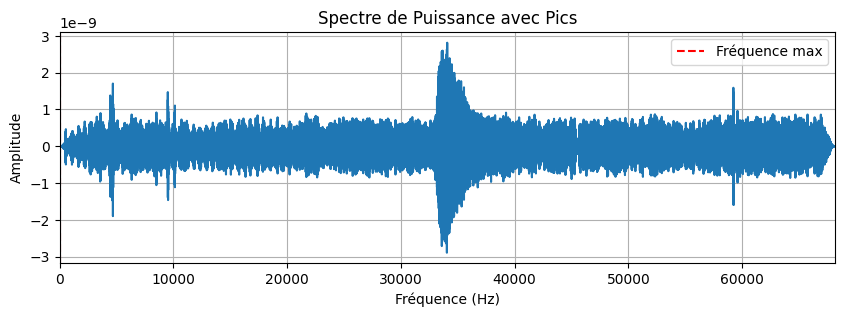

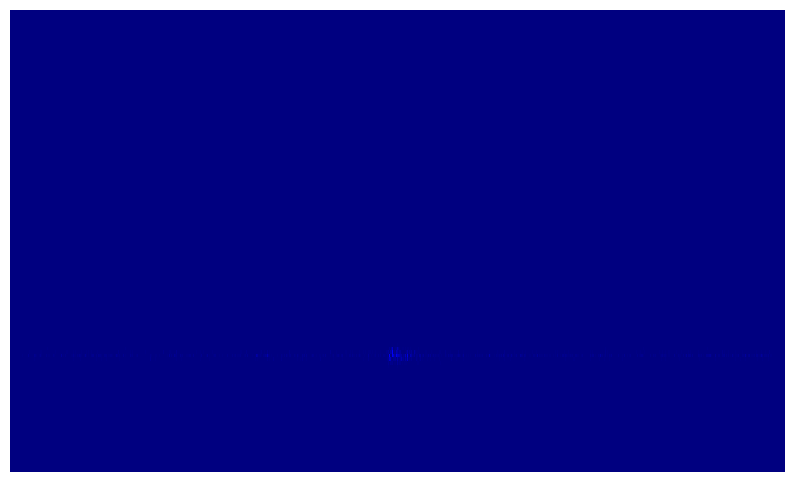

Largeur à mi-hauteur (FWHM) : 0.16545862704506353
Pourcentage basé sur la largeur à mi-hauteur : 19.980154016016556
Fréquence maximale : 0.8281148729505692 Hz
Amplitude maximale : 1.1959917433067173e-11
0.6626562459055056 0.9935734999956327


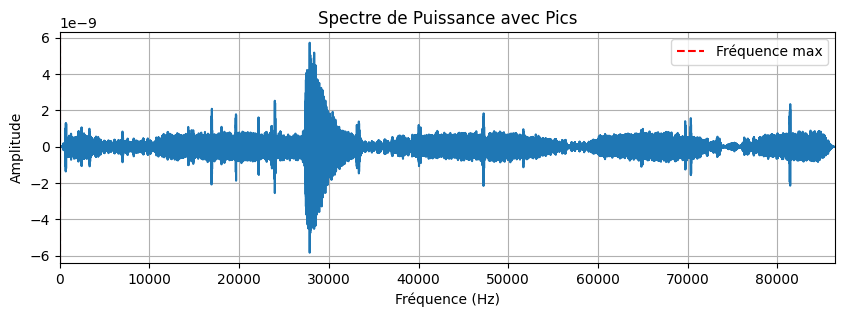

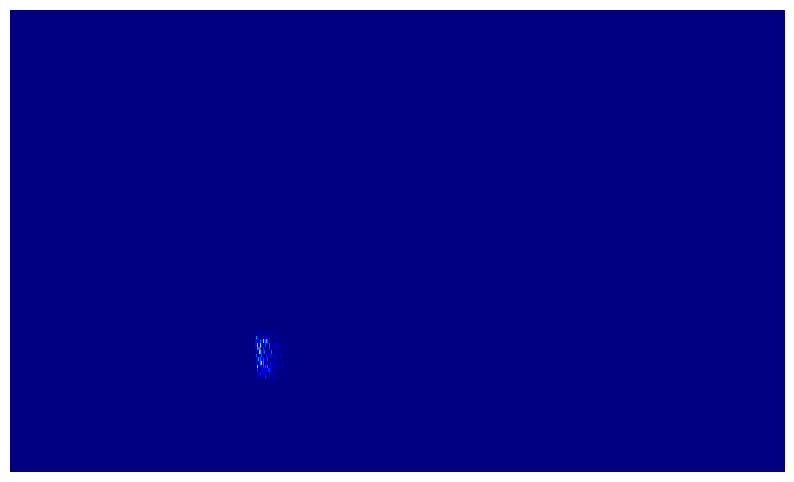

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-11-03HR00_evid00051.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-10-06HR00_evid00124.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1977-04-26HR00_evid00924.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1977-04-11HR00_evid00915.csv
Largeur à mi-hauteur (FWHM) : 0.6091537639123515
Pourcentage basé sur la largeur à mi-hauteur : 70.28791966026549
Fréquence maximale : 0.8666549911516483 Hz
Amplitude maximale : 6.525668702959208e-12
0.2575012272392968 1.475808755064


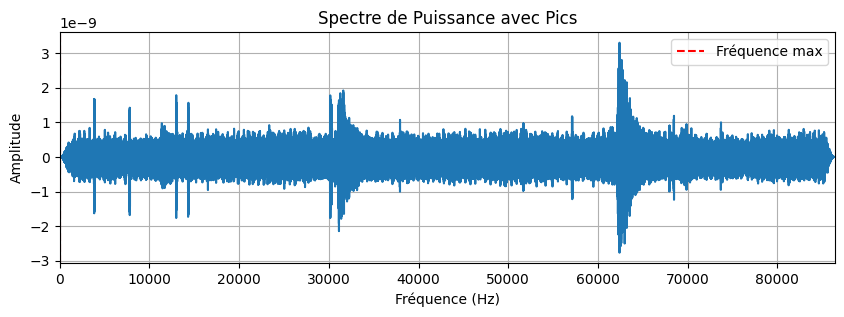

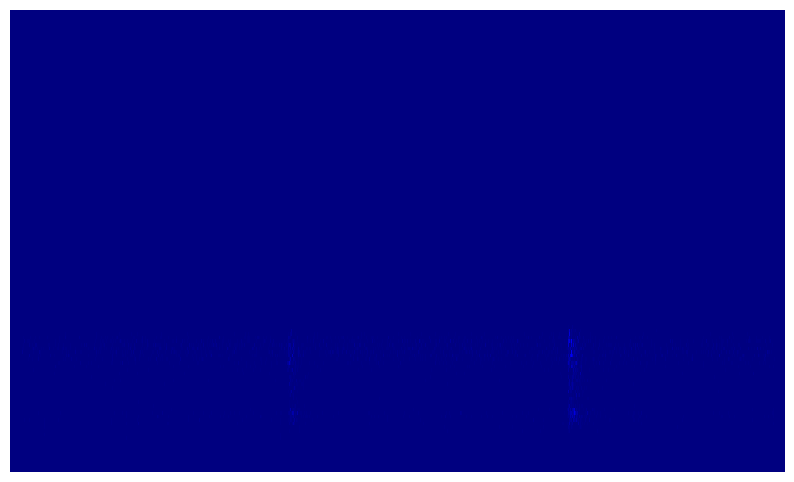

Largeur à mi-hauteur (FWHM) : 1.1574033633721115e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.0013976240391354211
Fréquence maximale : 0.8281221064915916 Hz
Amplitude maximale : 3.399974583883177e-11
0.8281105324579578 0.8281336805252253


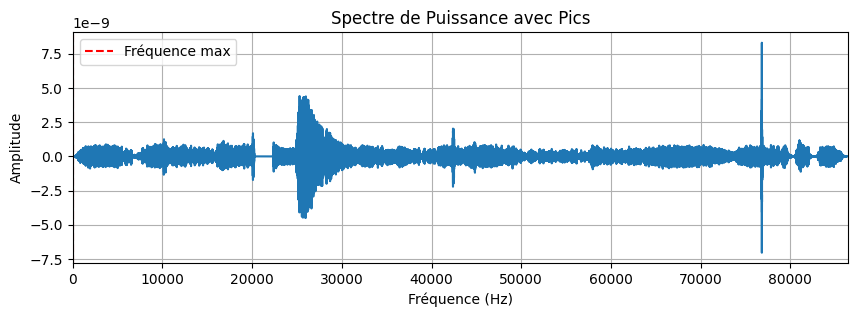

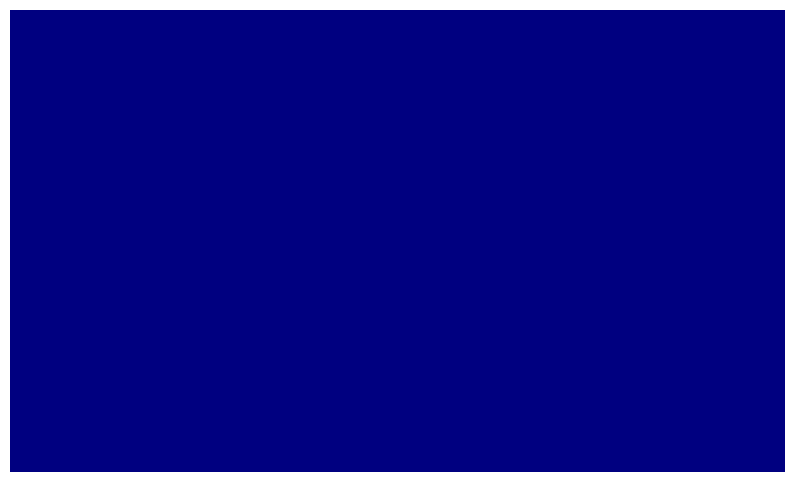

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1977-07-19HR00_evid00991.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-12-15HR00_evid00349.csv
Largeur à mi-hauteur (FWHM) : 0.5718338696546929
Pourcentage basé sur la largeur à mi-hauteur : 69.05187835420394
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 7.747893060039762e-12
0.2562882369177769 1.3999559762271625


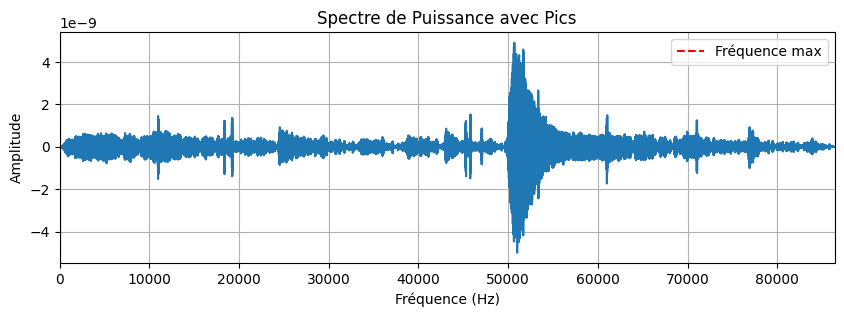

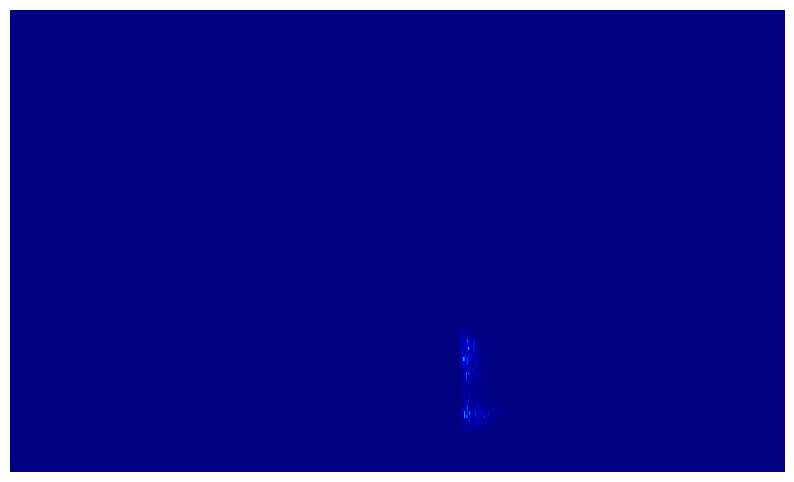

Largeur à mi-hauteur (FWHM) : 0.001759262332743483
Pourcentage basé sur la largeur à mi-hauteur : 0.21243885394829568
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 2.7762985724549814e-11
0.8263671844290434 0.8298857090945304


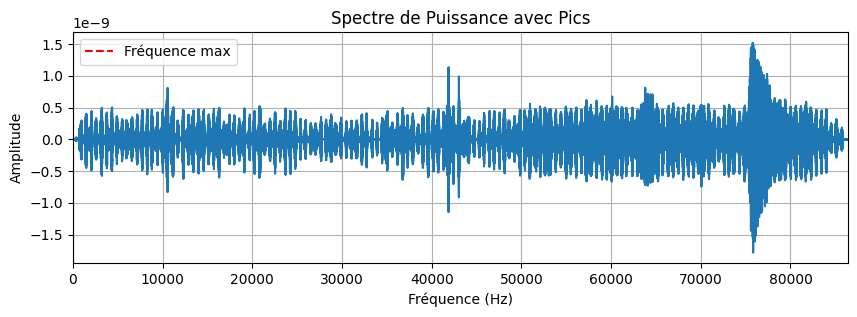

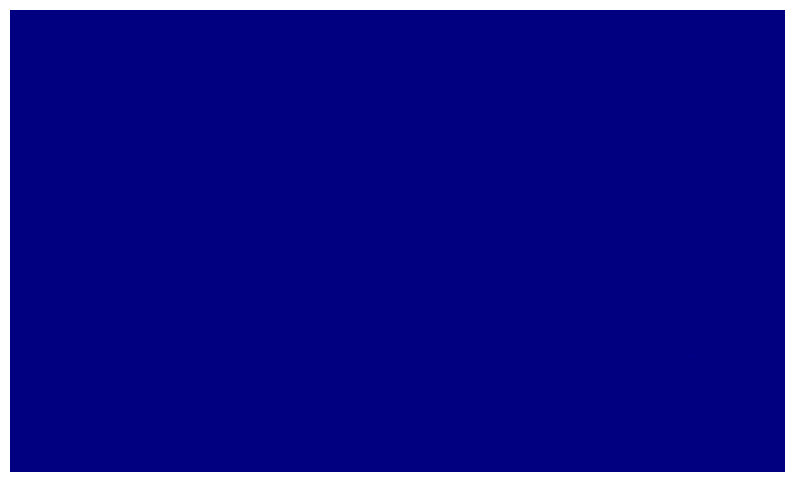

Largeur à mi-hauteur (FWHM) : 3.4721312334506926e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.004192754919489988
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 8.804096124420162e-12
0.8280917254090128 0.8281611680336818


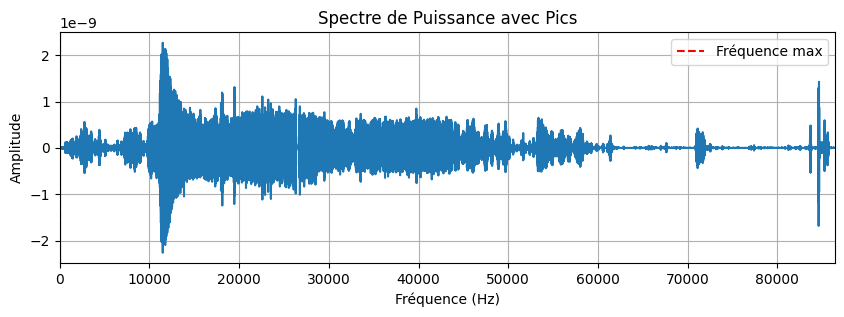

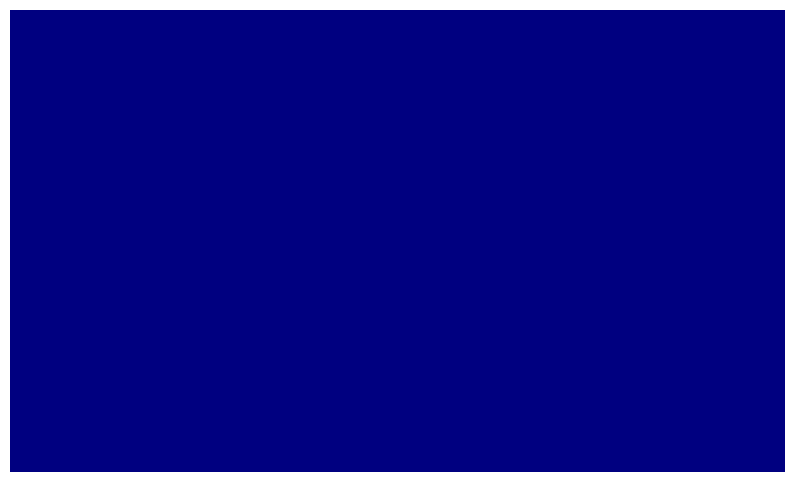

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-01-05HR00_evid00059.csv
Largeur à mi-hauteur (FWHM) : 2.3147703311021672e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.002795209011746518
Fréquence maximale : 0.8281206598056292 Hz
Amplitude maximale : 2.8409513881200268e-11
0.8280975121023182 0.8281438075089402


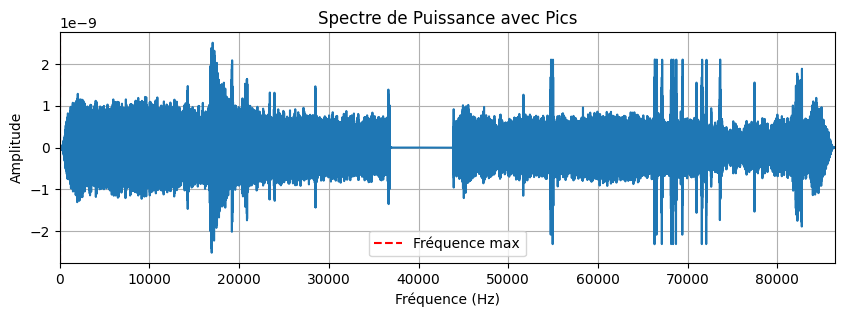

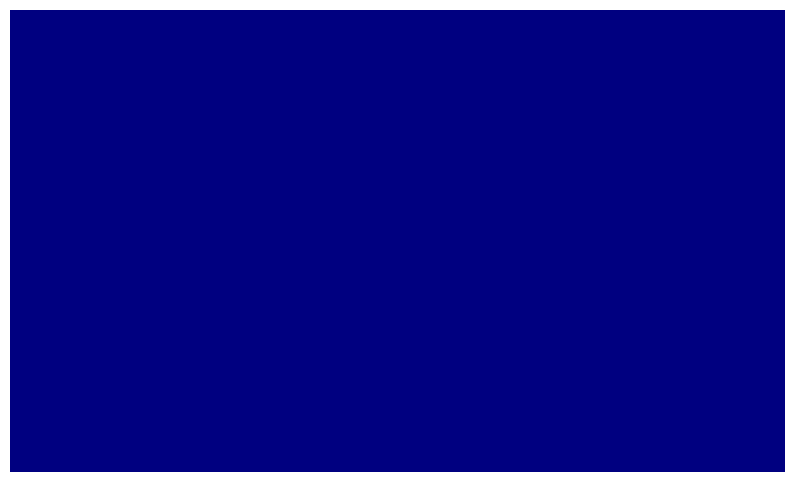

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-03-30HR00_evid00512.csv
Largeur à mi-hauteur (FWHM) : 0.5166567379033596
Pourcentage basé sur la largeur à mi-hauteur : 62.38906514234601
Fréquence maximale : 0.8281206598056292 Hz
Amplitude maximale : 9.068848239921623e-12
0.31146392190226957 1.344777397708989


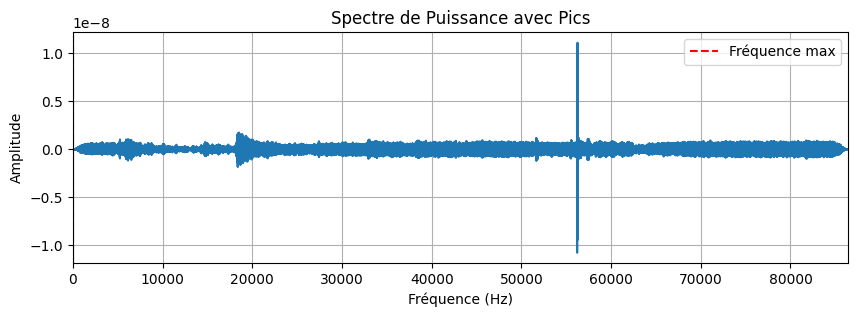

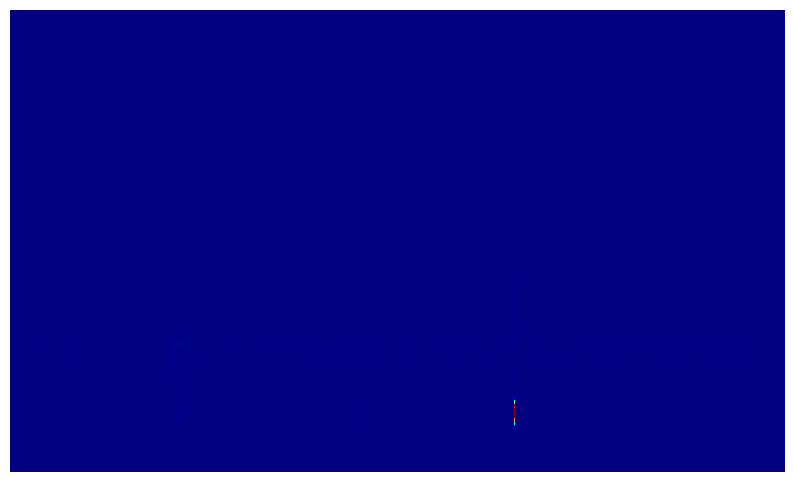

Largeur à mi-hauteur (FWHM) : 1.1573851655510836e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.001397604505873259
Fréquence maximale : 0.8281206598056292 Hz
Amplitude maximale : 8.027410869496045e-11
0.8281090859539737 0.8281322336572847


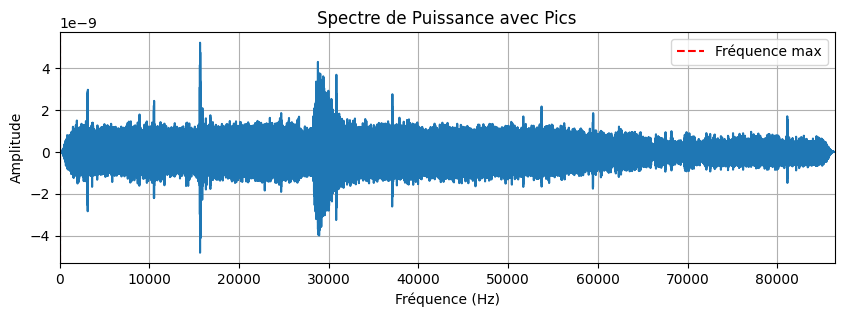

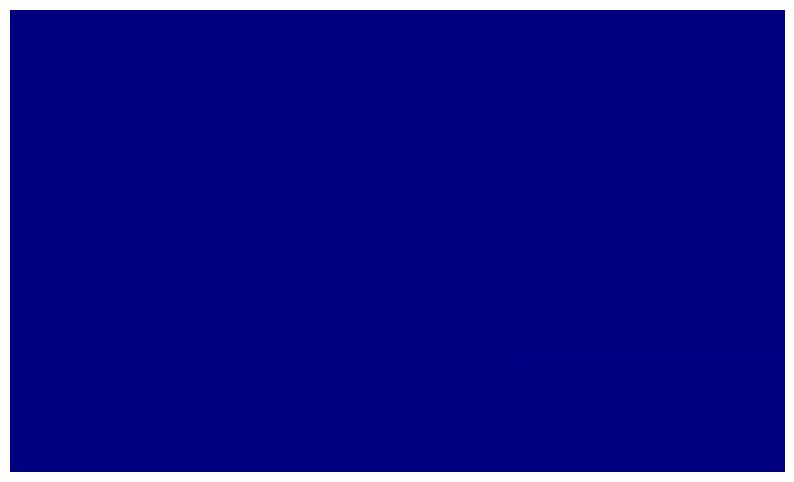

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1973-04-23HR00_evid00399.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1977-04-24HR00_evid00923.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1975-06-17HR00_evid00662.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-10-06HR00_evid00125.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1975-04-21HR00_evid00638.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467415668 Hz
Amplitude maximale : 8.061248017451782e-11
0.7867201244044885 0.8695327690786451


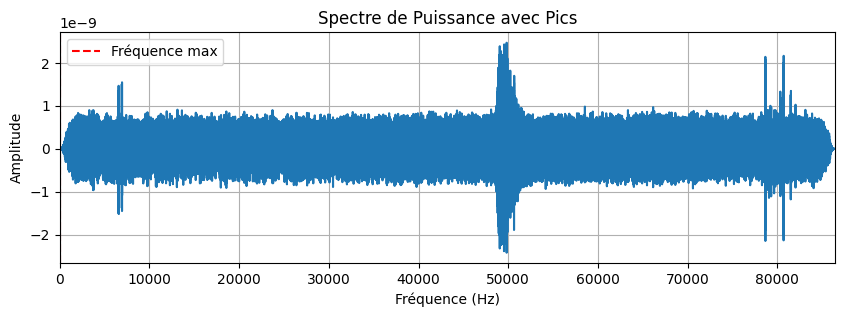

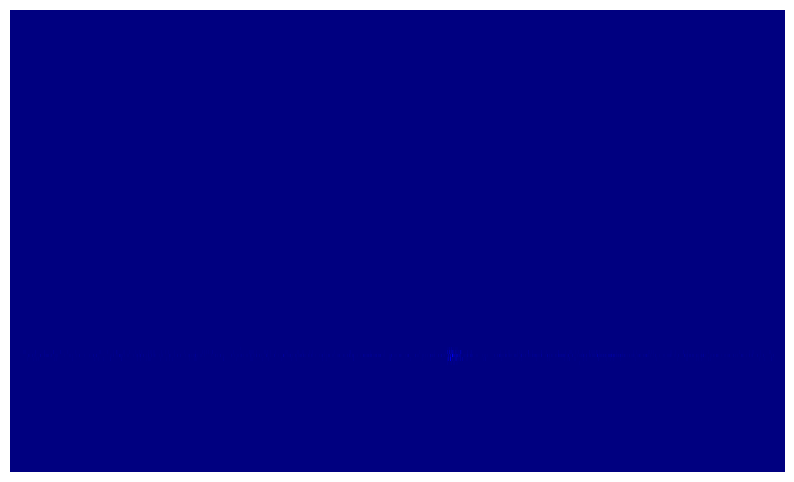

Largeur à mi-hauteur (FWHM) : 0.001759253112323167
Pourcentage basé sur la largeur à mi-hauteur : 0.21243885394828907
Fréquence maximale : 0.8281221064915916 Hz
Amplitude maximale : 1.1566397838140414e-11
0.8263628533792684 0.8298813596039147


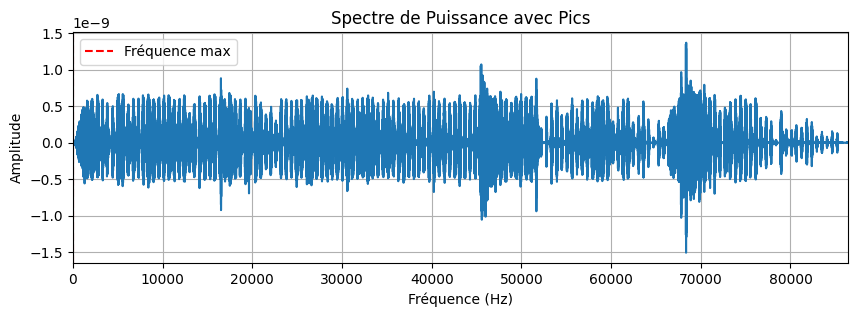

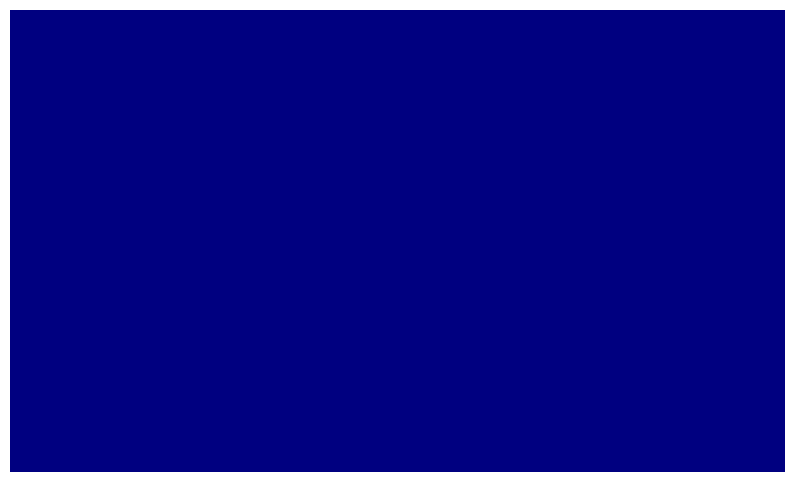

Largeur à mi-hauteur (FWHM) : 1.1574175176276569e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.0013976435729412674
Fréquence maximale : 0.8281206596843089 Hz
Amplitude maximale : 7.59795853360205e-11
0.8281090855091326 0.8281322338594852


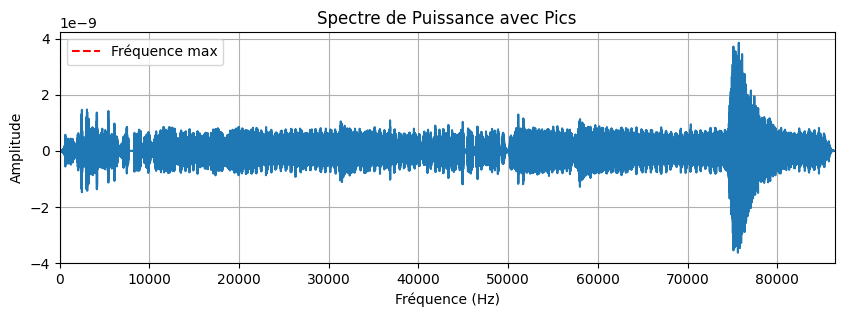

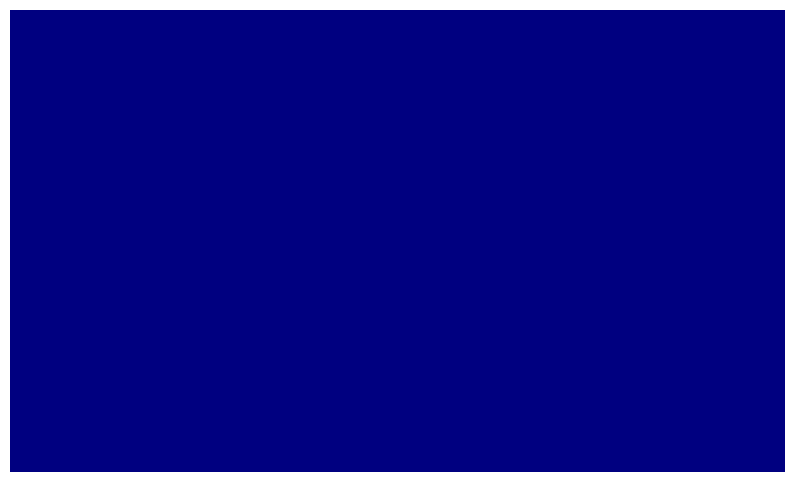

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-25HR00_evid00029.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-05-22HR00_evid00092.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-07-25HR05_evid00553.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 5.085478482604617e-11
0.7867201243852799 0.8695327690574146


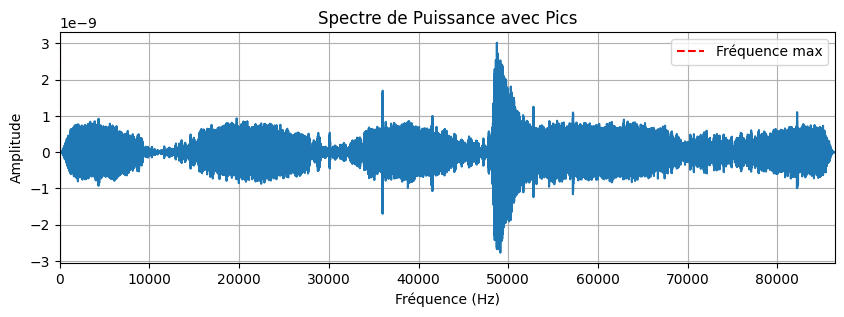

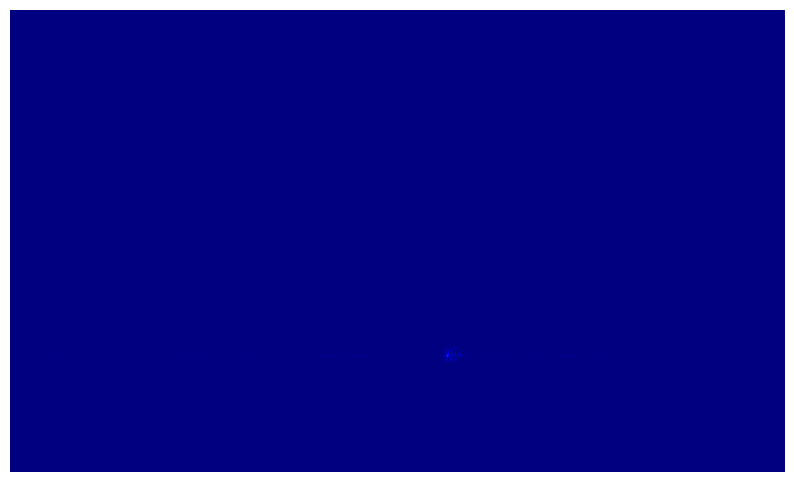

Largeur à mi-hauteur (FWHM) : 0.8002678318721674
Pourcentage basé sur la largeur à mi-hauteur : 88.84034693221972
Fréquence maximale : 0.9007932313487336 Hz
Amplitude maximale : 1.3679179784908955e-10
0.10052539947656614 1.7010610632209011


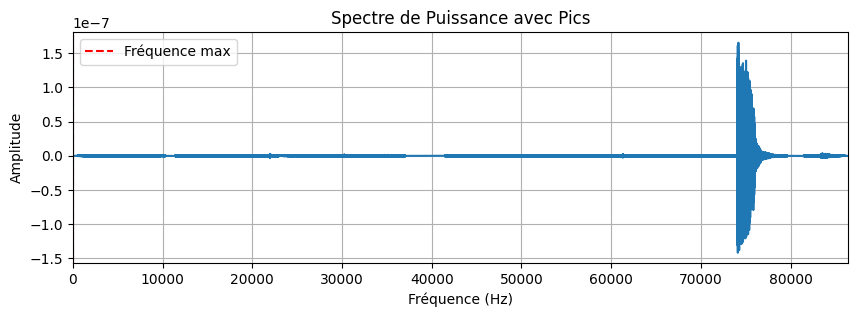

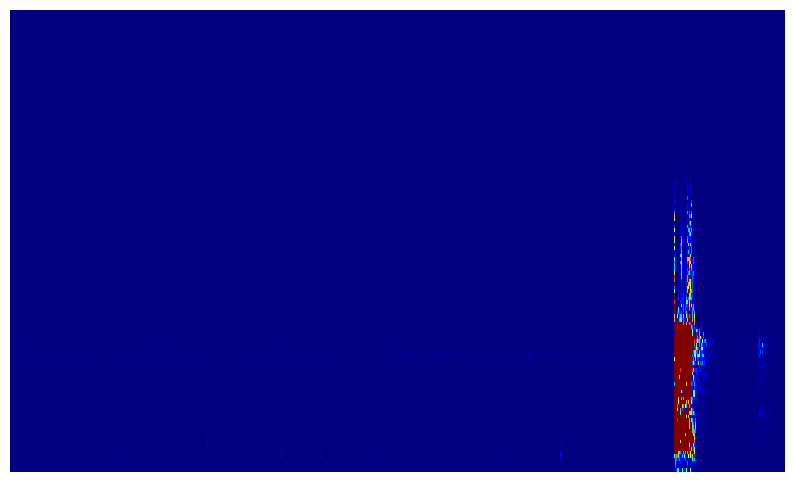

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 1.1674109460150315e-10
0.7867201244236975 0.8695327690998763


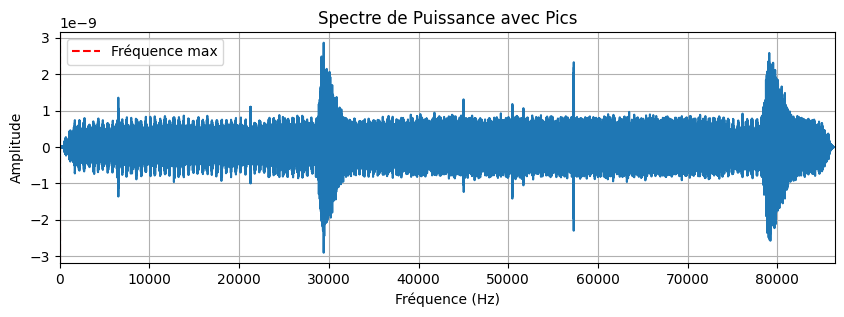

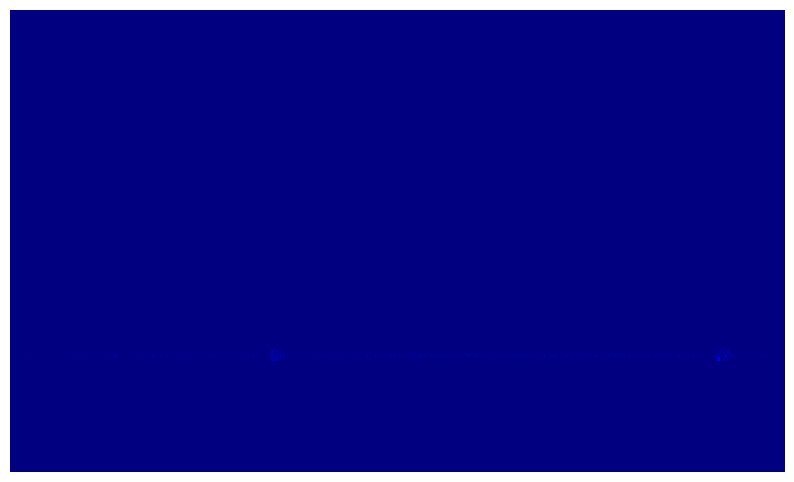

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-02-28HR00_evid00192.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 7.503659247742817e-11
0.786720124366072 0.8695327690361847


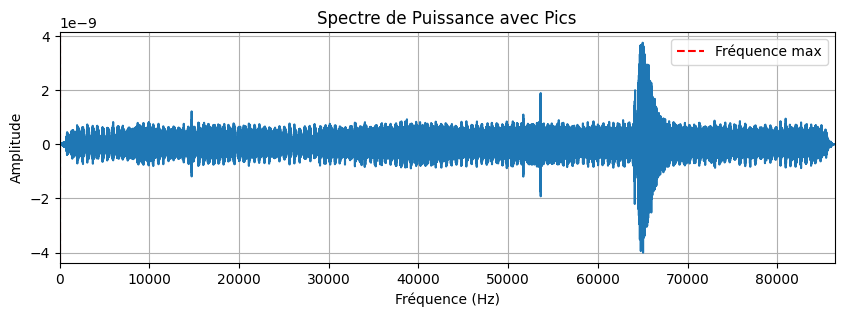

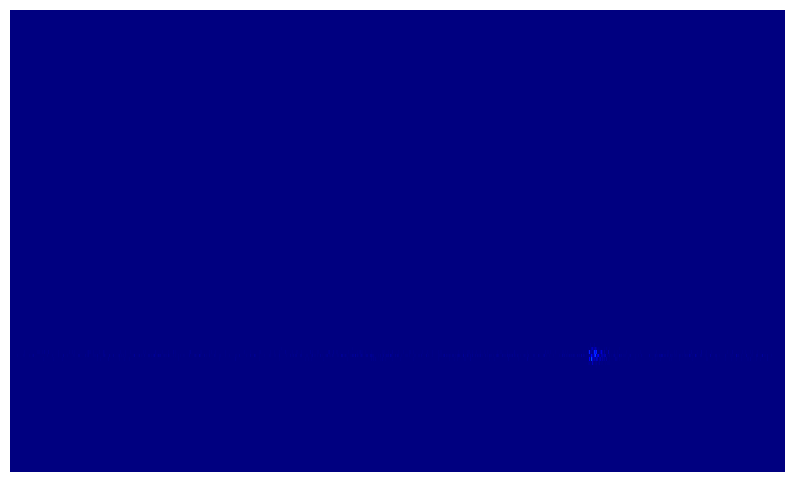

Largeur à mi-hauteur (FWHM) : 1.1573851655510836e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.001397604505873259
Fréquence maximale : 0.8281206598056292 Hz
Amplitude maximale : 4.834889335807317e-11
0.8281090859539737 0.8281322336572847


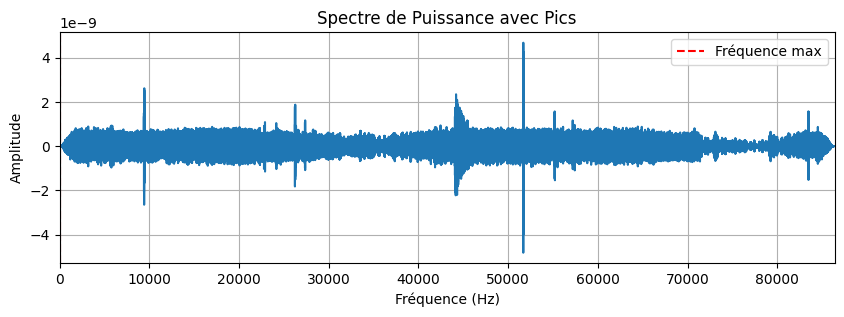

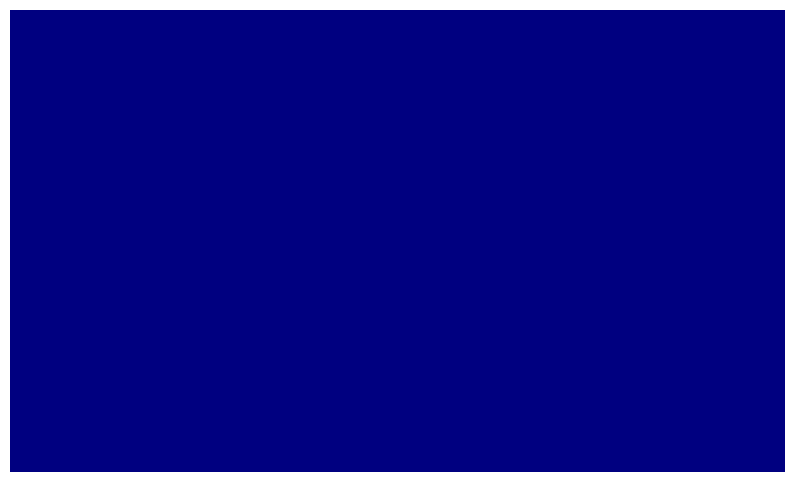

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1973-10-10HR00_evid00463.csv
Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-05-09HR00_evid00522.csv
Largeur à mi-hauteur (FWHM) : 0.8698851953243061
Pourcentage basé sur la largeur à mi-hauteur : 105.04402515723272
Fréquence maximale : 0.8281148728090327 Hz
Amplitude maximale : 8.740154245543623e-12
0.0001 1.698000068133339


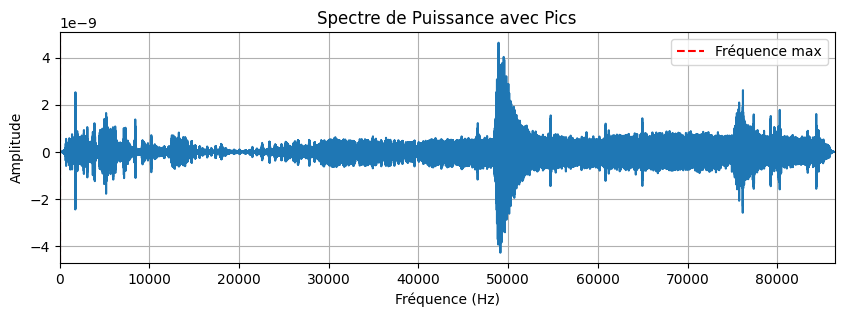

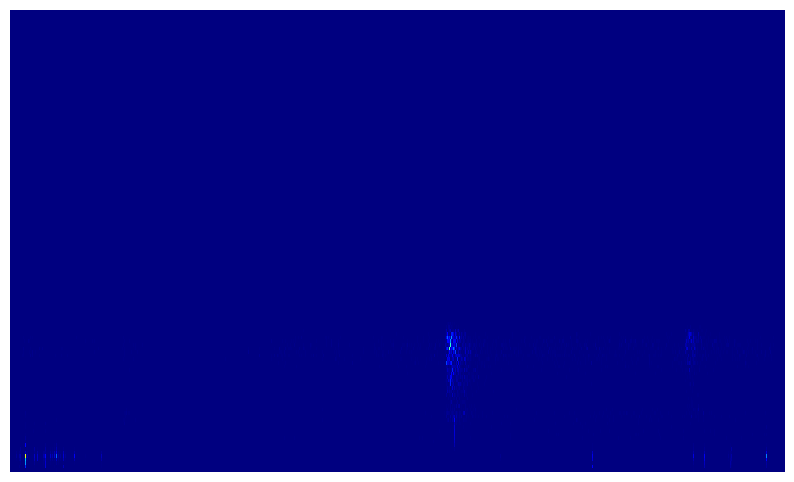

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281267349799187 Hz
Amplitude maximale : 7.149350593523824e-11
0.7867203982309228 0.8695330717289147


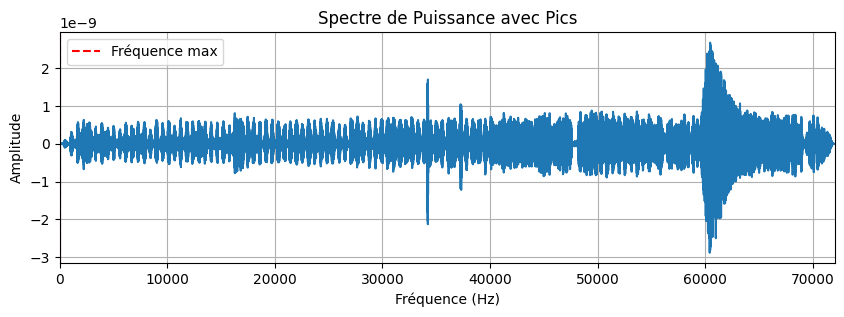

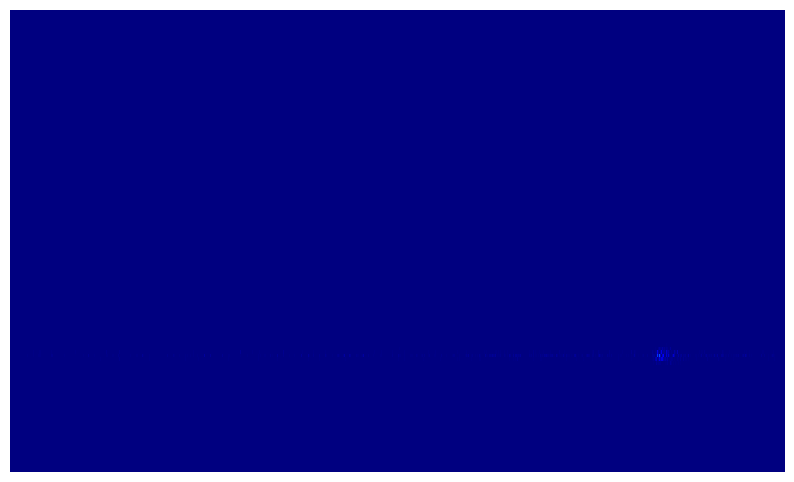

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281279098367856 Hz
Amplitude maximale : 6.101723323783322e-11
0.7867215143449463 0.869534305328625


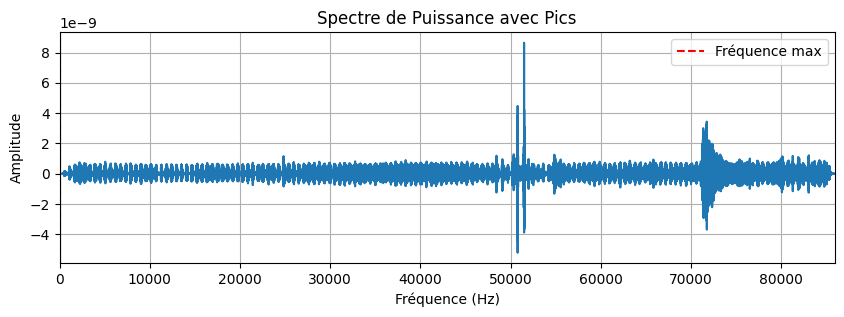

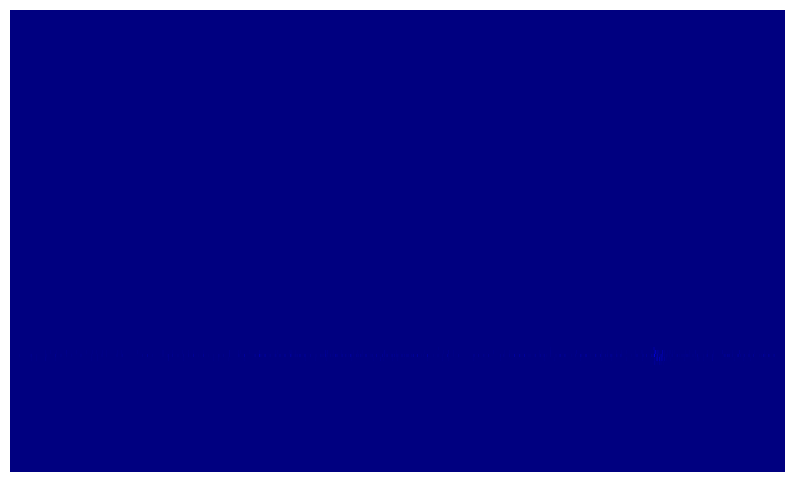

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-04-08HR01_evid00083.csv
Largeur à mi-hauteur (FWHM) : 0.2974595613990647
Pourcentage basé sur la largeur à mi-hauteur : 35.47363045368594
Fréquence maximale : 0.8385371262956163 Hz
Amplitude maximale : 2.0798530996910268e-11
0.5410775648965516 1.135996687694681


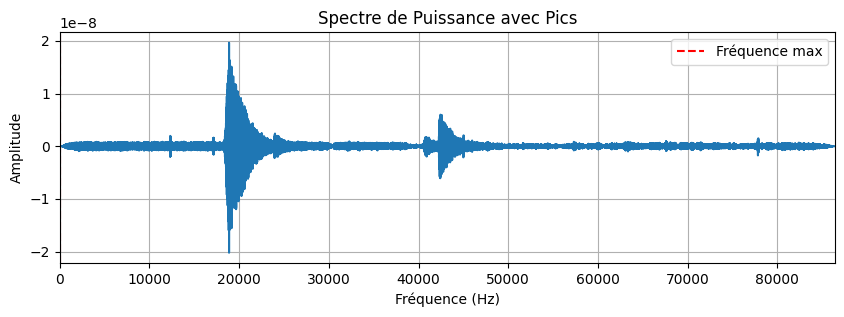

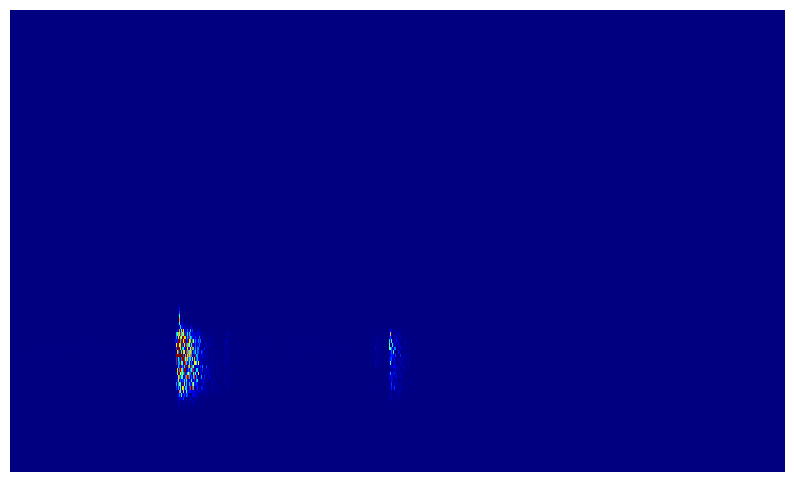

Largeur à mi-hauteur (FWHM) : 0.6091537639123515
Pourcentage basé sur la largeur à mi-hauteur : 70.28791966026549
Fréquence maximale : 0.8666549911516483 Hz
Amplitude maximale : 6.525668702959208e-12
0.2575012272392968 1.475808755064


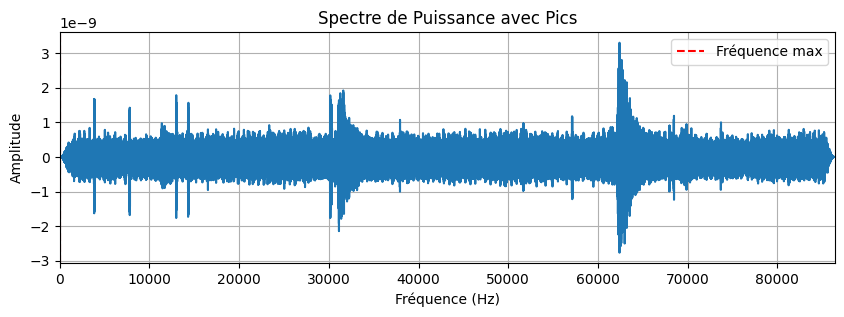

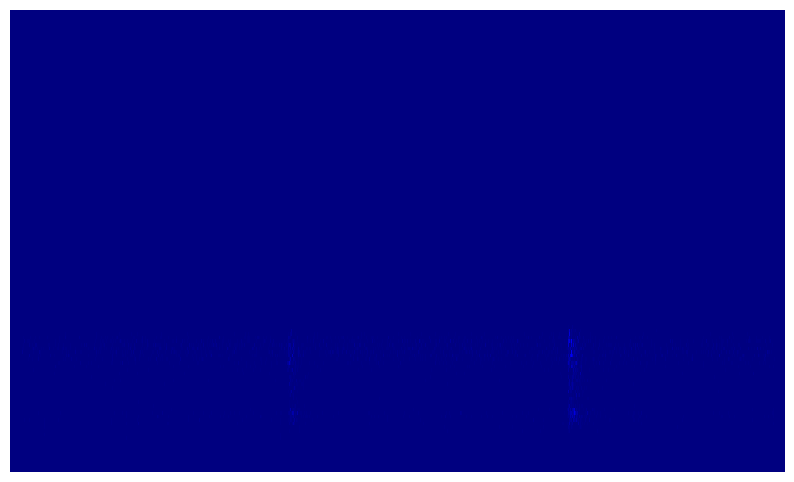

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-05-15HR00_evid00223.csv
Largeur à mi-hauteur (FWHM) : 0.9759299585268107
Pourcentage basé sur la largeur à mi-hauteur : 111.47937599153887
Fréquence maximale : 0.8754354335468136 Hz
Amplitude maximale : 1.6511933859164793e-11
0.0001 1.8513653920736246


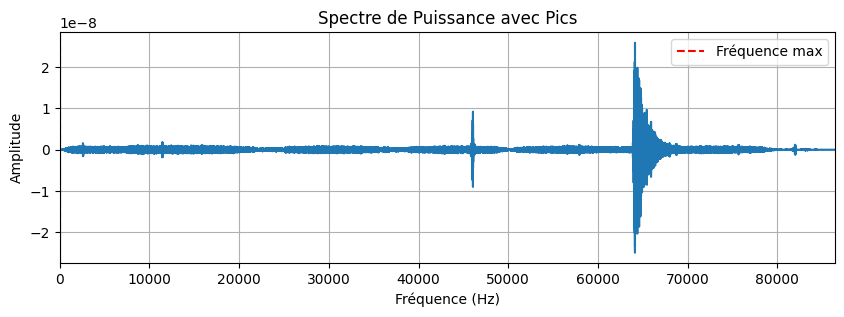

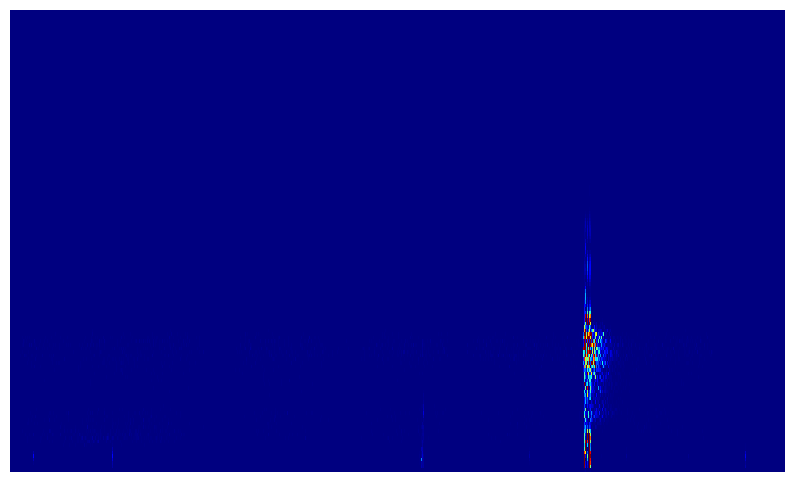

Skipped non-mseed file: ../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-12-06HR00_evid00342.csv
Largeur à mi-hauteur (FWHM) : 0.9629095346407694
Pourcentage basé sur la largeur à mi-hauteur : 116.27627459749552
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 5.771432875238691e-12
0.0001 1.7910316412132392


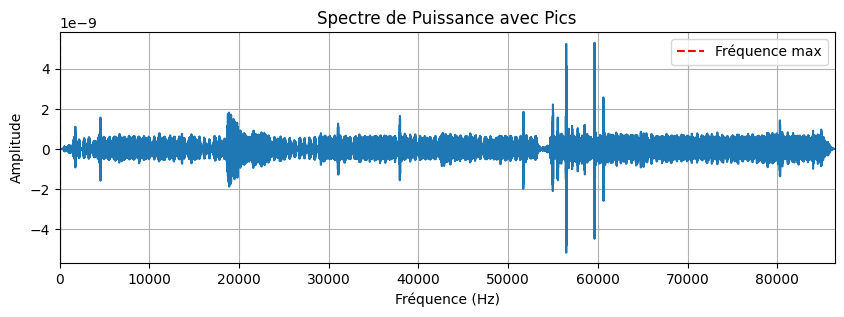

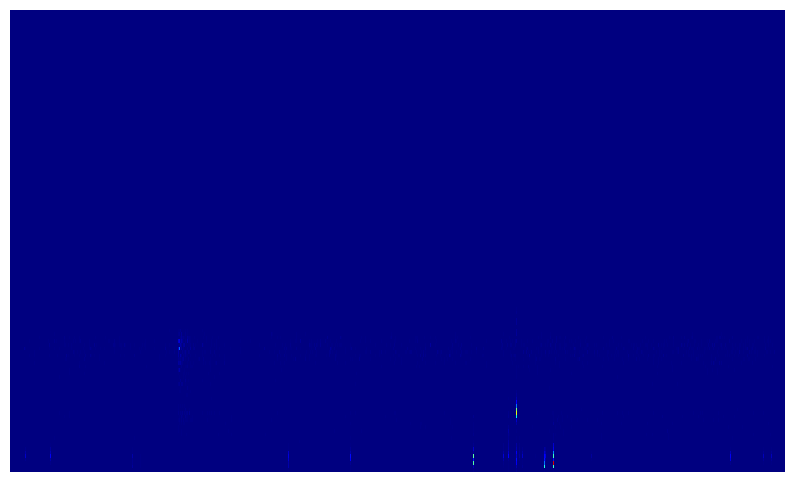

Largeur à mi-hauteur (FWHM) : 0.8150710508431938
Pourcentage basé sur la largeur à mi-hauteur : 98.42350211737083
Fréquence maximale : 0.8281264467415668 Hz
Amplitude maximale : 8.480655983410856e-12
0.013055395898373012 1.6431974975847605


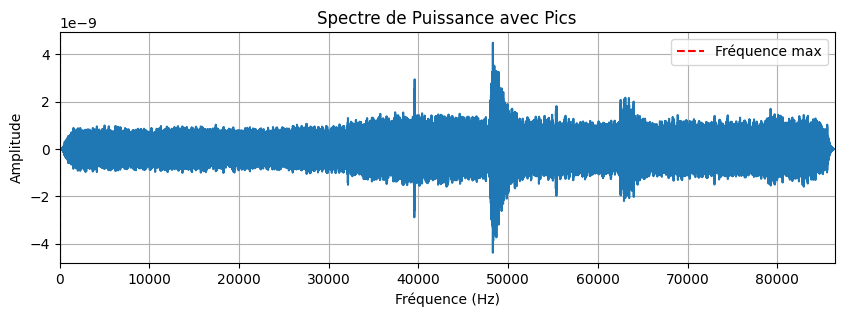

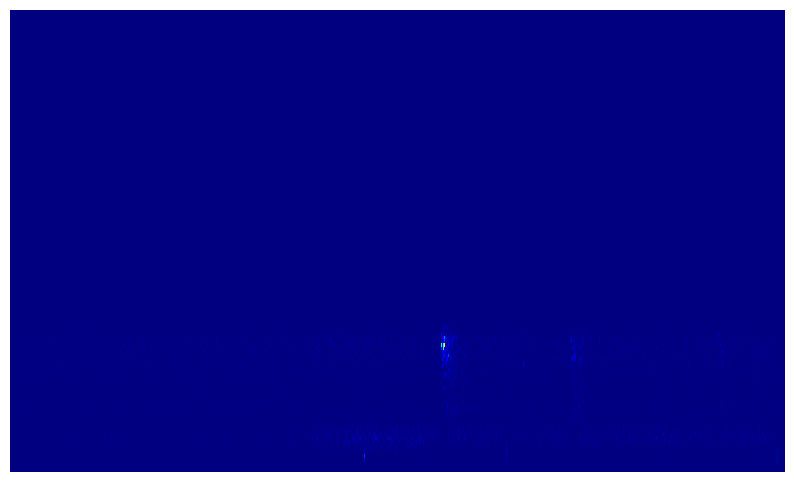

Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1973-04-04HR00_evid00098.csv
Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1974-12-15HR00_evid00170.csv
Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1974-11-17HR00_evid00162.csv
Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1975-06-22HR00_evid00194.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467415668 Hz
Amplitude maximale : 1.7241220677593484e-11
0.7867201244044885 0.8695327690786451


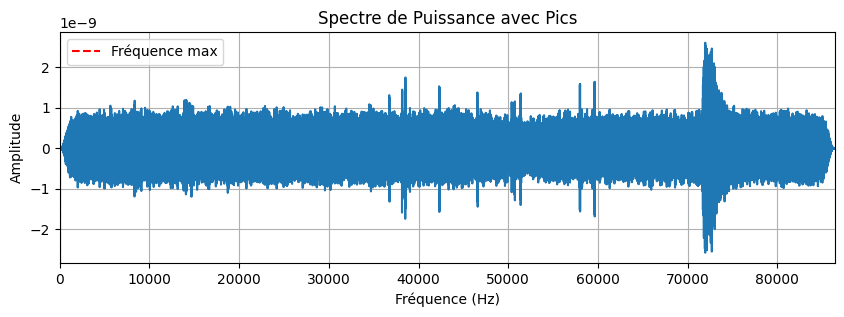

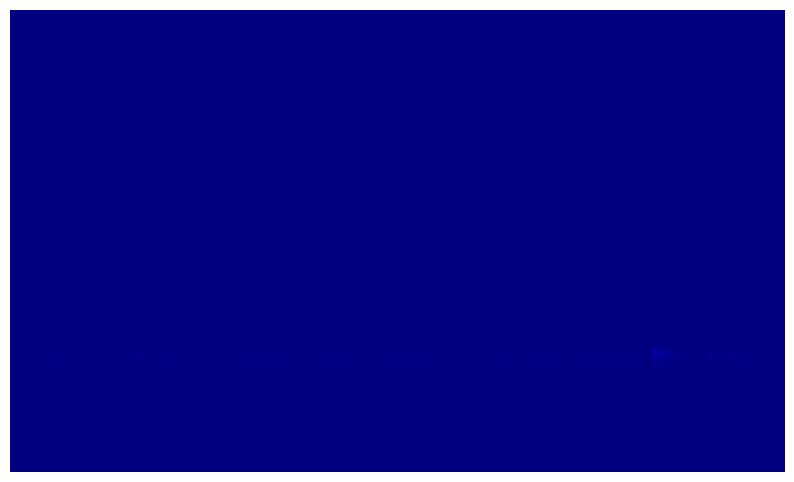

Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1974-12-15HR00_evid00169.csv
Largeur à mi-hauteur (FWHM) : 3.4720402494636815e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.0041925791349322165
Fréquence maximale : 0.8281394668343727 Hz
Amplitude maximale : 1.6463361149017733e-11
0.828104746431878 0.8281741872368673


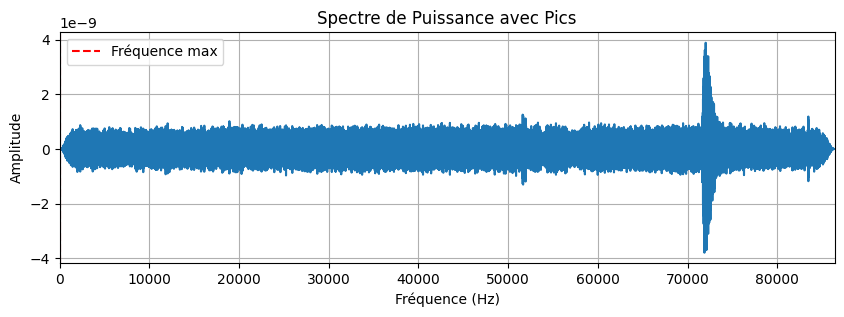

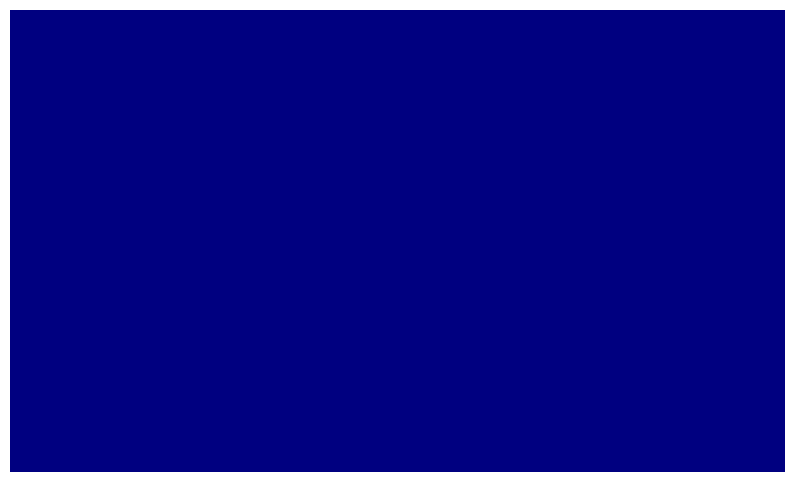

Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1974-10-19HR00_evid00157.csv
Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1973-08-10HR00_evid00126.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467415668 Hz
Amplitude maximale : 3.1990301329672074e-11
0.7867201244044885 0.8695327690786451


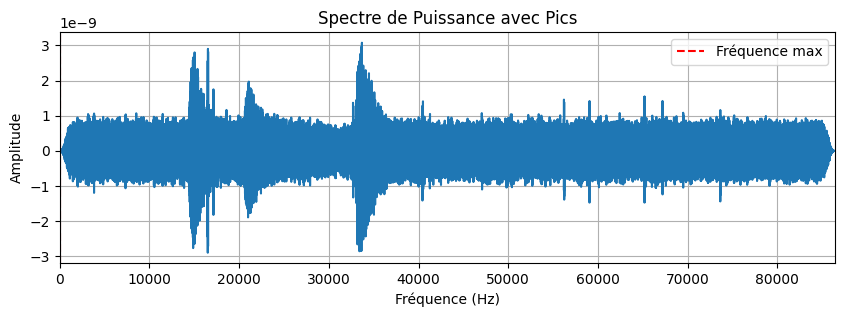

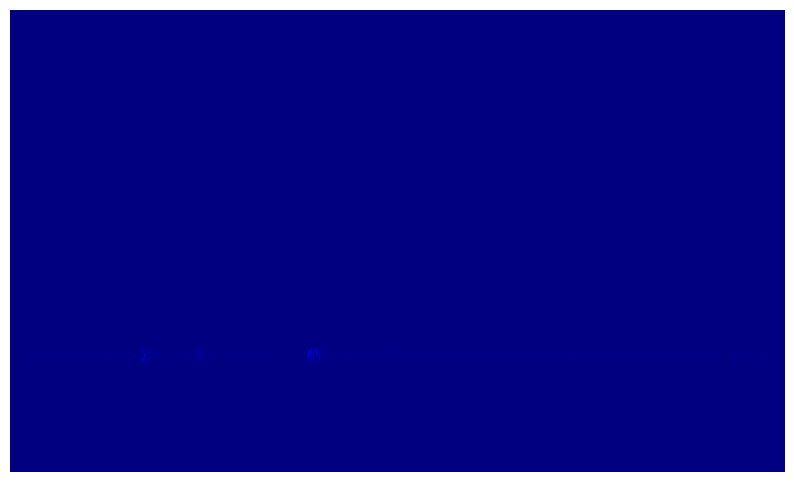

Largeur à mi-hauteur (FWHM) : 0.08795154254287652
Pourcentage basé sur la largeur à mi-hauteur : 10.620545073375256
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 1.1975054564470494e-11
0.7401749042189104 0.9160779893046634


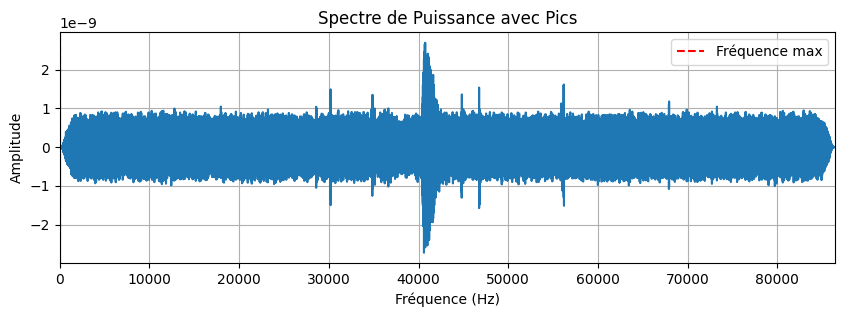

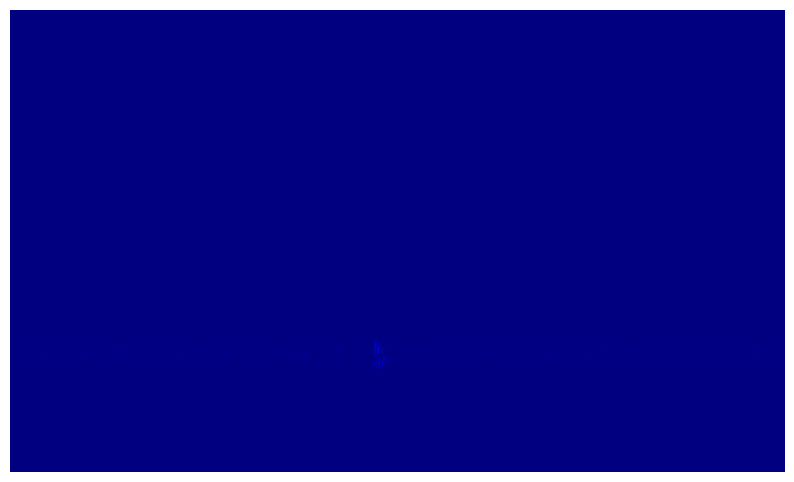

Largeur à mi-hauteur (FWHM) : 0.7295692101005936
Pourcentage basé sur la largeur à mi-hauteur : 79.55248179512097
Fréquence maximale : 0.9170917030338818 Hz
Amplitude maximale : 4.1322106767958e-11
0.18752249293328815 1.6466609131344754


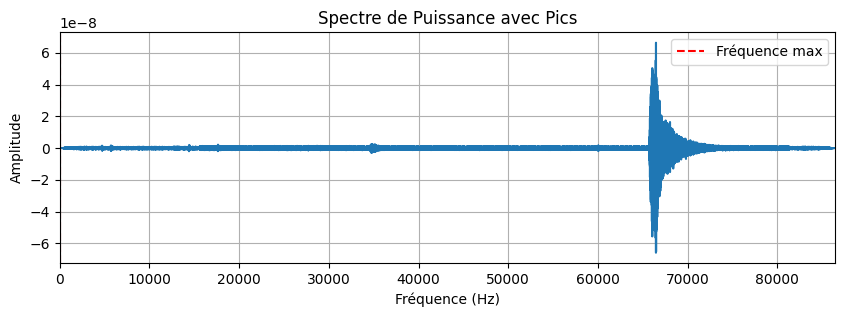

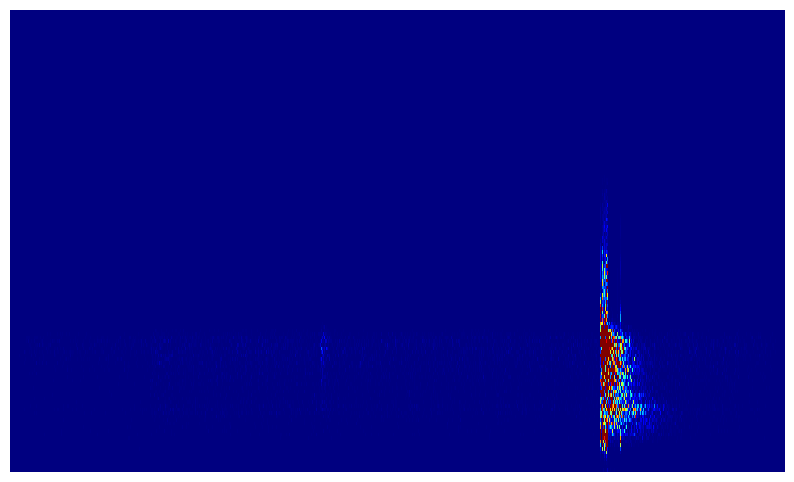

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467415668 Hz
Amplitude maximale : 3.1990301329672074e-11
0.7867201244044885 0.8695327690786451


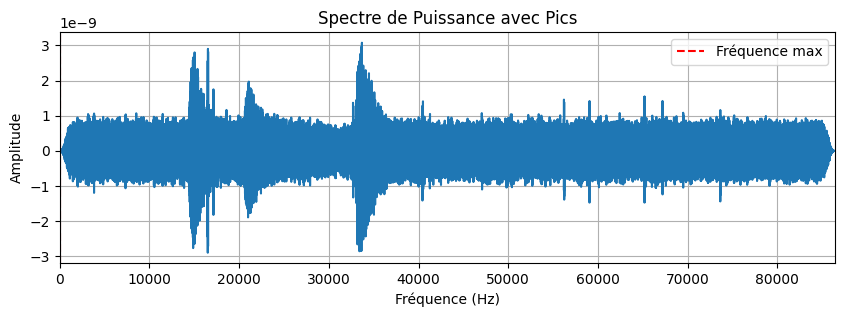

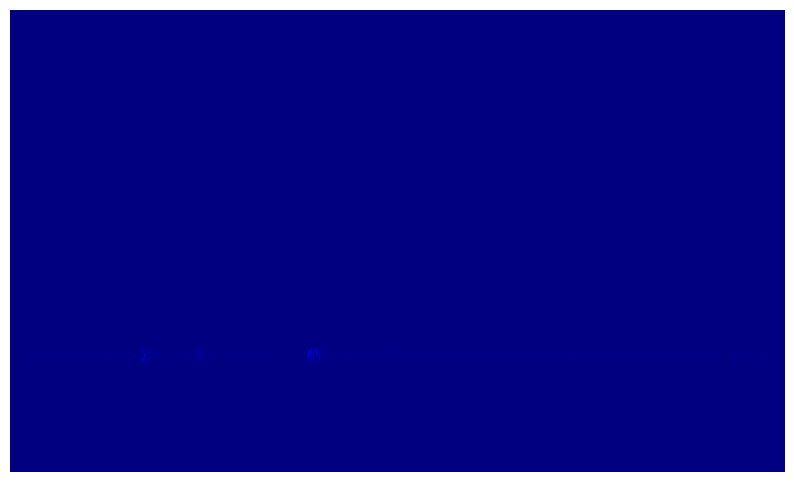

Largeur à mi-hauteur (FWHM) : 1.2074719274113299e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.001458087281098027
Fréquence maximale : 0.8281204719802722 Hz
Amplitude maximale : 2.783343918119617e-11
0.828108397260998 0.8281325466995463


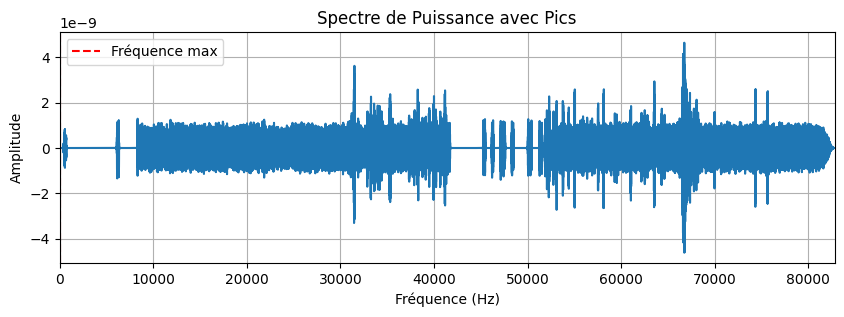

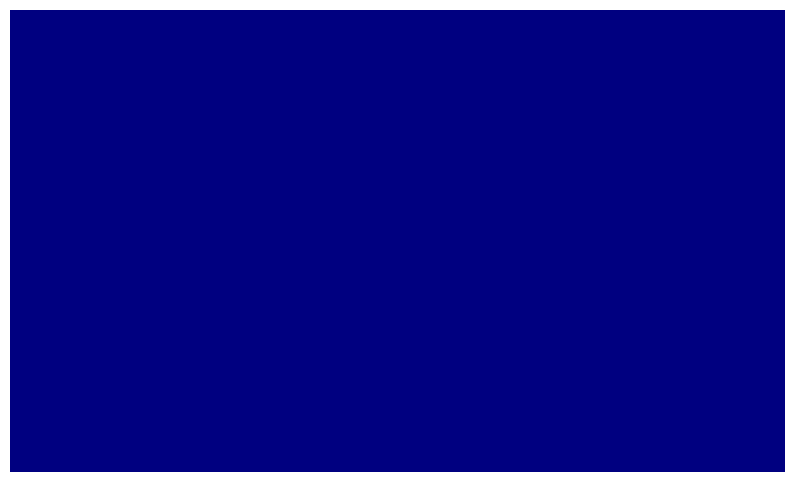

Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1974-11-21HR00_evid00166.csv
Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1973-10-27HR00_evid00134.csv
Largeur à mi-hauteur (FWHM) : 0.21245296138028869
Pourcentage basé sur la largeur à mi-hauteur : 25.654786862334035
Fréquence maximale : 0.8281221064915916 Hz
Amplitude maximale : 1.2028133455609538e-11
0.6156691451113029 1.0405750678718801


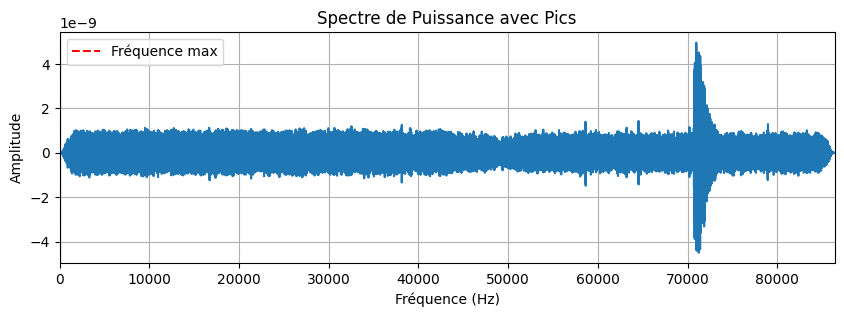

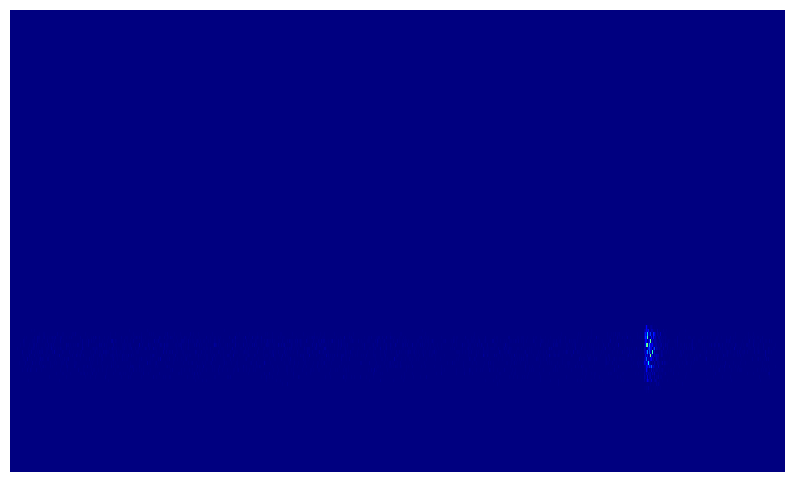

Largeur à mi-hauteur (FWHM) : 0.04585407822790555
Pourcentage basé sur la largeur à mi-hauteur : 5.537076892975929
Fréquence maximale : 0.8281278933668745 Hz
Amplitude maximale : 1.5632784038331242e-11
0.782273815138969 0.8739819715947801


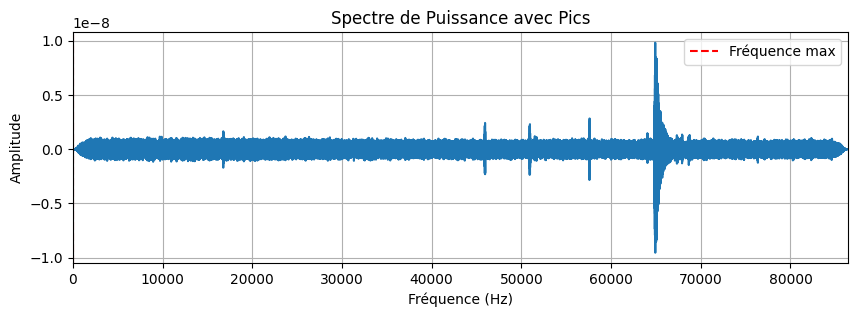

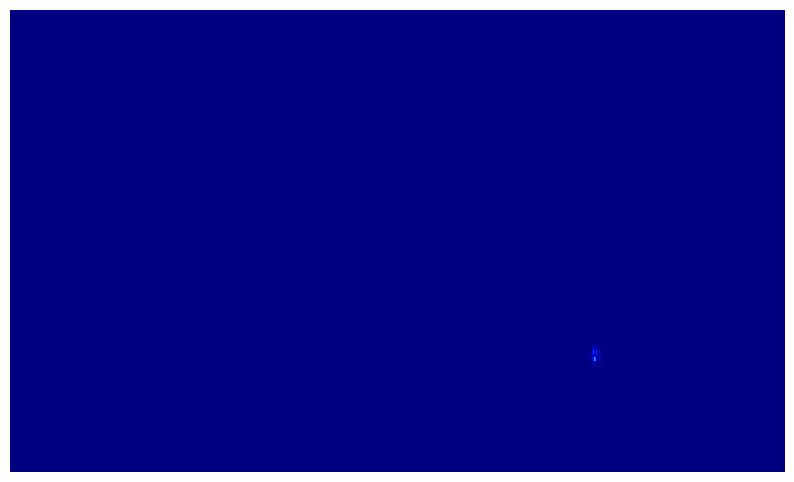

Skipped non-mseed file: ../data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1975-04-12HR00_evid00190.csv
Skipped non-mseed file: ../data/lunar/test/data/S15_GradeB/xa.s15.00.mhz.1974-06-30HR00_evid00542.csv
Skipped non-mseed file: ../data/lunar/test/data/S15_GradeB/xa.s15.00.mhz.1974-06-16HR00_evid00536.csv
Largeur à mi-hauteur (FWHM) : 0.8720019985220719
Pourcentage basé sur la largeur à mi-hauteur : 105.29817058683773
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 8.590630594797632e-12
0.0001 1.7001284452232004


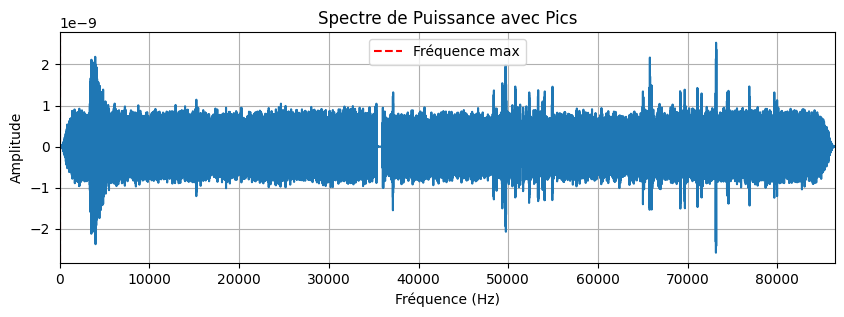

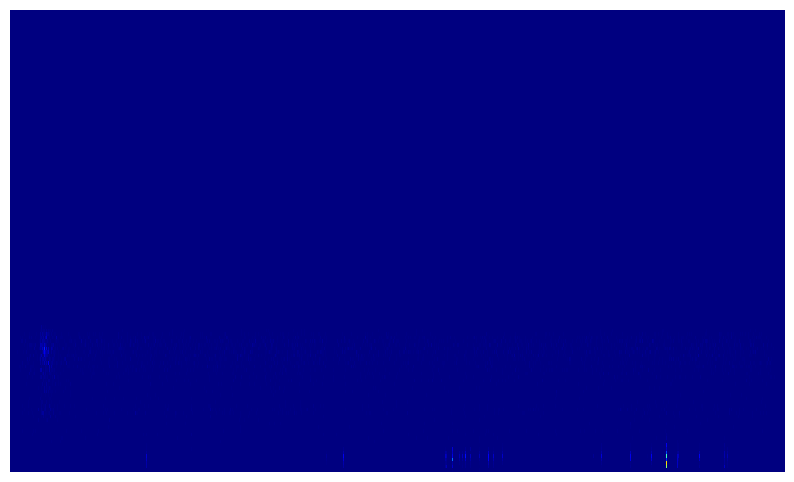

Largeur à mi-hauteur (FWHM) : 1.1573528152952761e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.0013975654410039455
Fréquence maximale : 0.8281206599269427 Hz
Amplitude maximale : 2.3838701592386777e-11
0.8281090863987898 0.8281322334550957


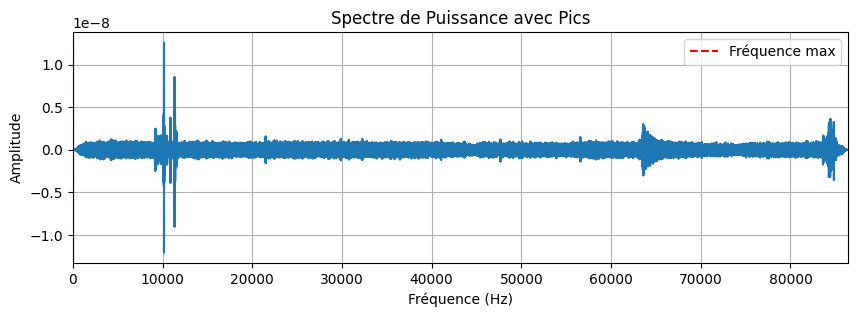

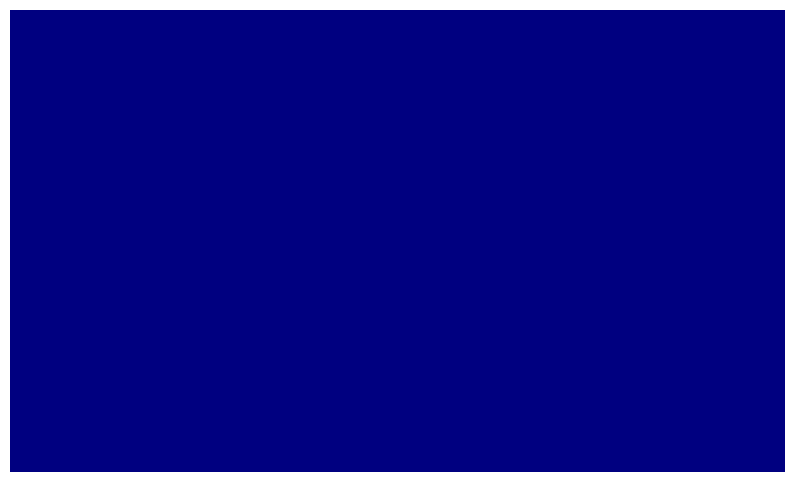

Skipped non-mseed file: ../data/lunar/test/data/S15_GradeB/xa.s15.00.mhz.1974-08-04HR00_evid00557.csv
Skipped non-mseed file: ../data/lunar/test/data/S15_GradeB/xa.s15.00.mhz.1975-05-20HR00_evid00653.csv
Largeur à mi-hauteur (FWHM) : 0.4787557192696805
Pourcentage basé sur la largeur à mi-hauteur : 57.811910385599084
Fréquence maximale : 0.8281264467415668 Hz
Amplitude maximale : 1.7917681830527967e-11
0.34937072747188624 1.3068821660112473


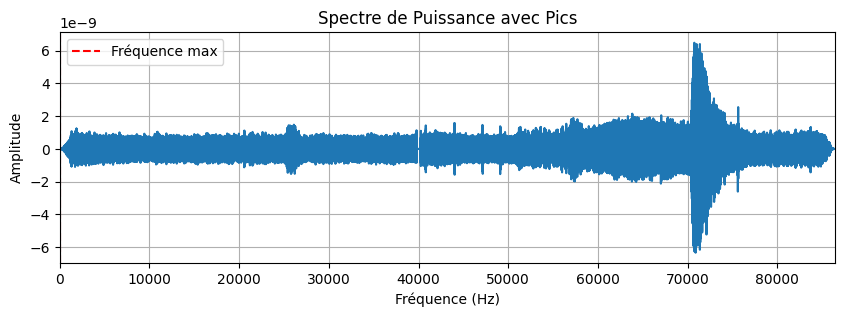

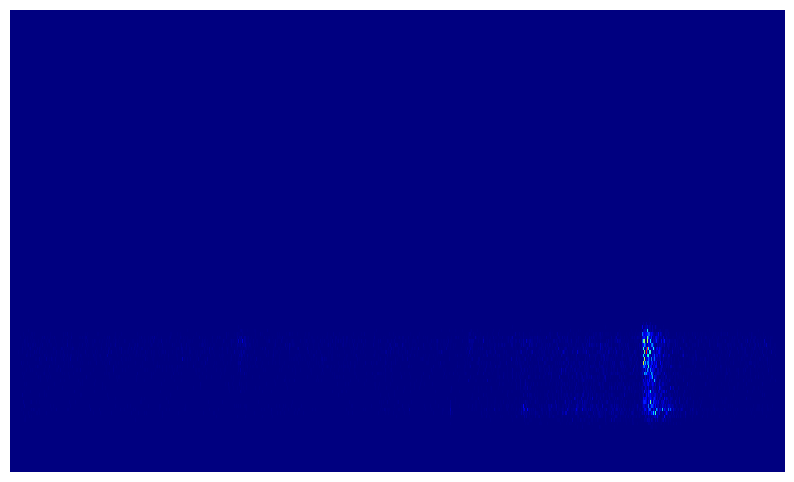

Largeur à mi-hauteur (FWHM) : 0.14439133723601438
Pourcentage basé sur la largeur à mi-hauteur : 17.435782765463845
Fréquence maximale : 0.8281322334550957 Hz
Amplitude maximale : 1.0528676109023169e-11
0.6837408962190813 0.9725235706911101


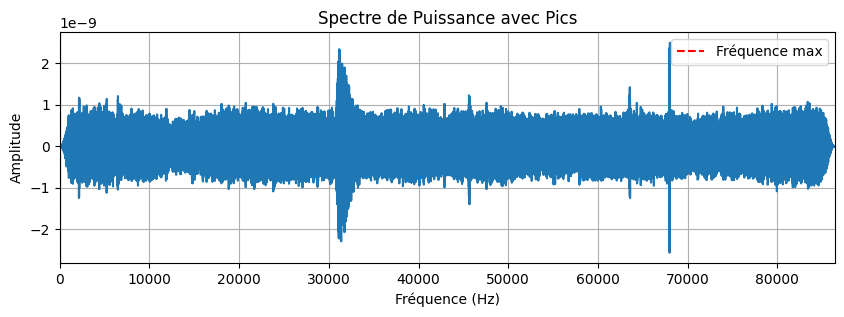

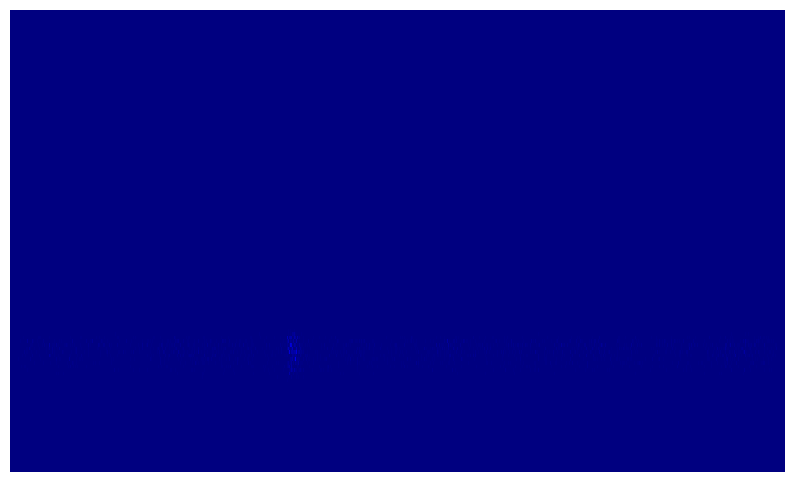

Largeur à mi-hauteur (FWHM) : 0.7911200904220103
Pourcentage basé sur la largeur à mi-hauteur : 94.7704081632653
Fréquence maximale : 0.8347754386148802 Hz
Amplitude maximale : 5.81960201737879e-12
0.04365534819287009 1.6258955290368904


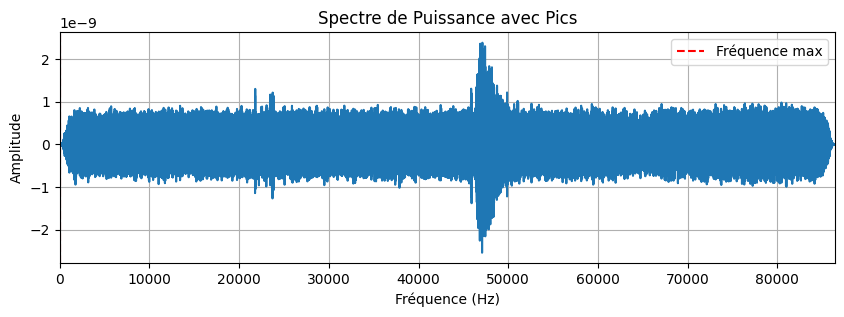

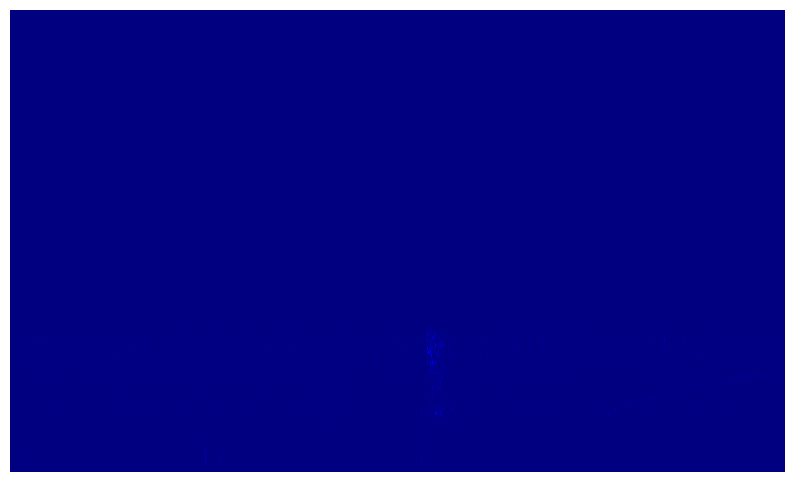

Skipped non-mseed file: ../data/lunar/test/data/S15_GradeB/xa.s15.00.mhz.1974-02-06HR00_evid00497.csv
Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-05-19HR00_evid00146.csv
Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1972-11-08HR00_evid00080.csv
Largeur à mi-hauteur (FWHM) : 0.0001508366288254237
Pourcentage basé sur la largeur à mi-hauteur : 0.01821366024518348
Fréquence maximale : 0.8281511063396044 Hz
Amplitude maximale : 1.588452294781154e-10
0.828000269710779 0.8283019429684298


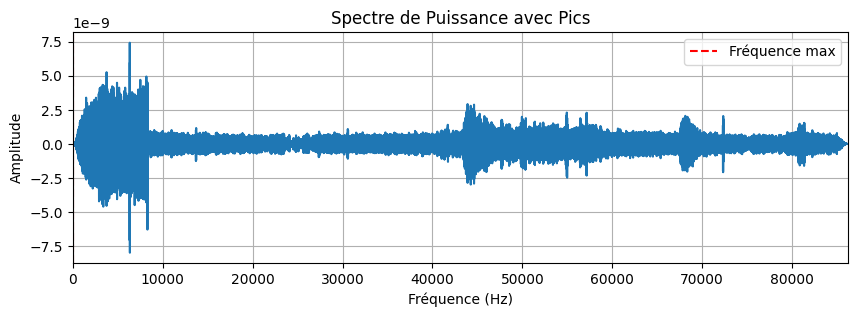

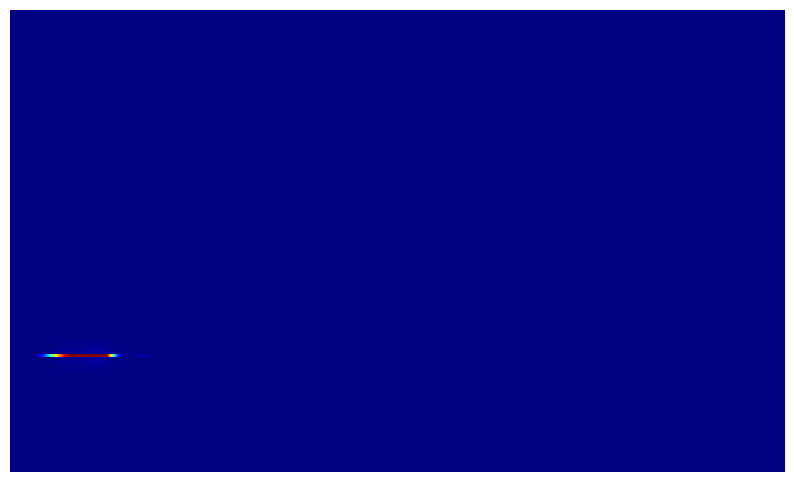

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 2.349007095767506e-11
0.786720124366072 0.8695327690361847


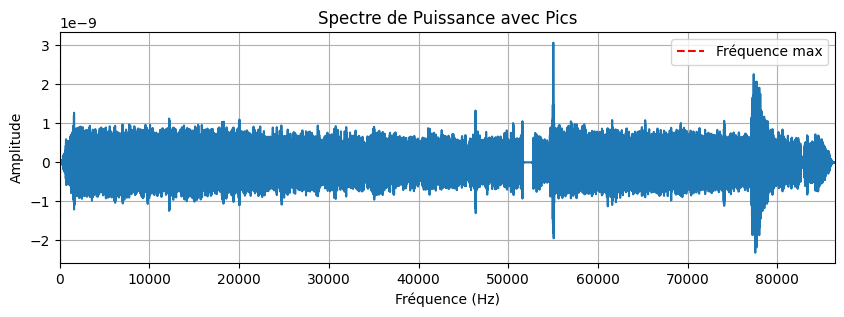

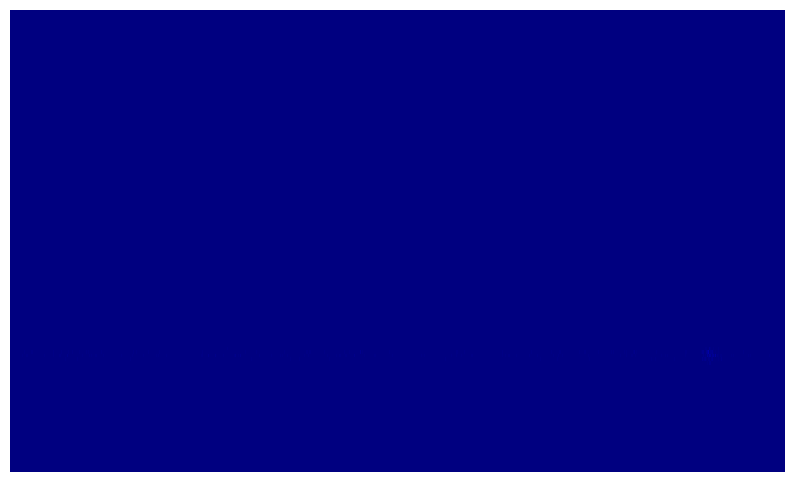

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-11-11HR00_evid00160.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264466606922 Hz
Amplitude maximale : 3.8710948757636714e-11
0.7867201243276576 0.8695327689937269


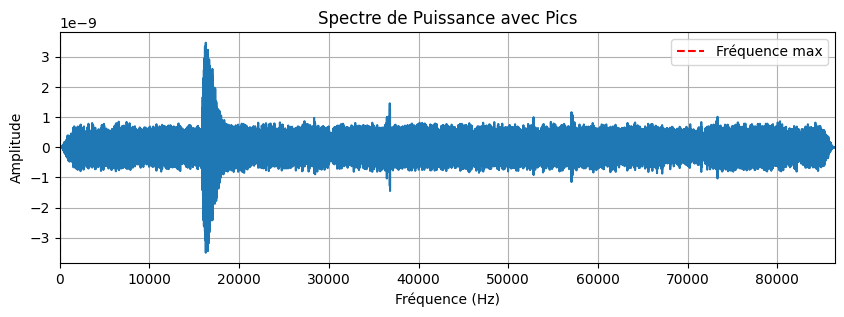

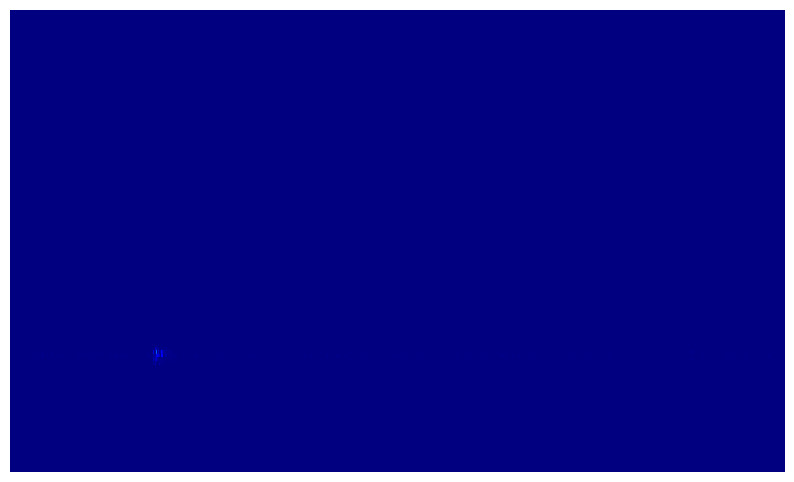

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-12-25HR00_evid00174.csv
Largeur à mi-hauteur (FWHM) : 0.5446616528218164
Pourcentage basé sur la largeur à mi-hauteur : 59.66024340770792
Fréquence maximale : 0.912939038983954 Hz
Amplitude maximale : 8.356386442080363e-12
0.36827738616213757 1.4576006918057705


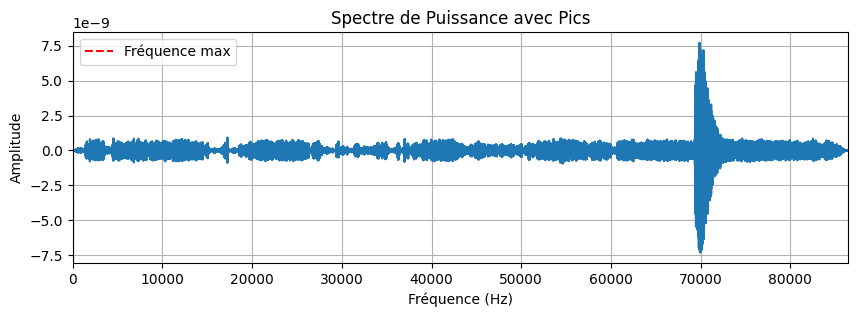

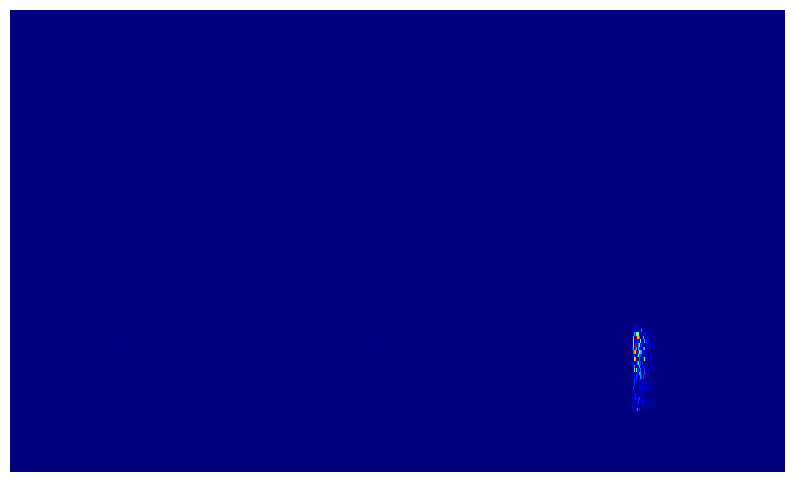

Largeur à mi-hauteur (FWHM) : 0.7231176244507919
Pourcentage basé sur la largeur à mi-hauteur : 87.31971153846155
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 1.346444489111821e-11
0.10500882227055541 1.5512440711721391


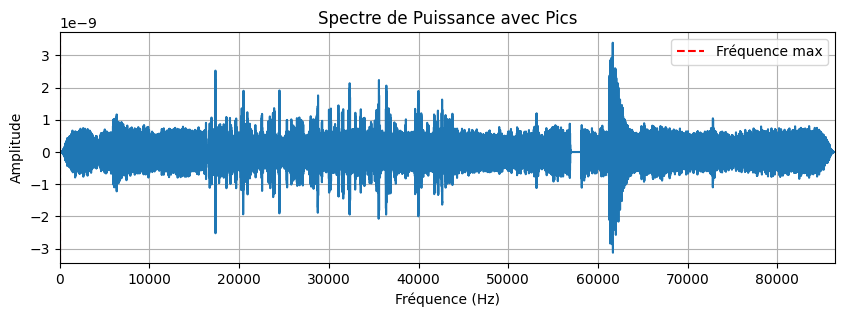

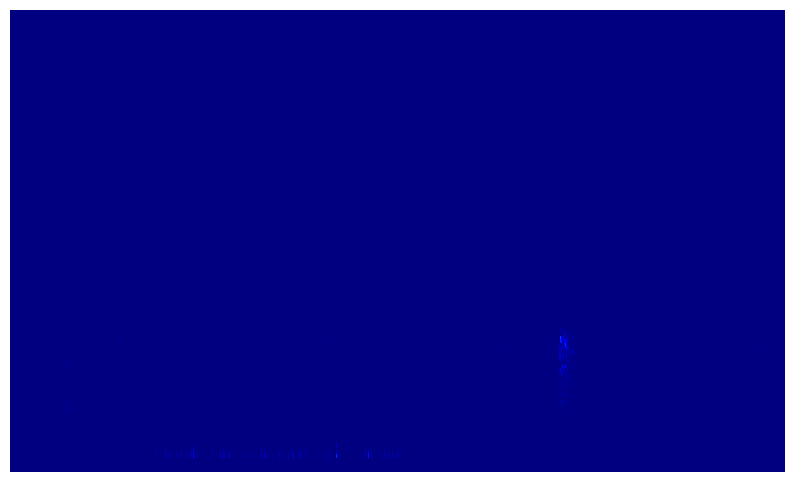

Largeur à mi-hauteur (FWHM) : 1.2774827515715792e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.001542614731969568
Fréquence maximale : 0.8281281937068788 Hz
Amplitude maximale : 1.2438767070226224e-11
0.8281154188793631 0.8281409685343946


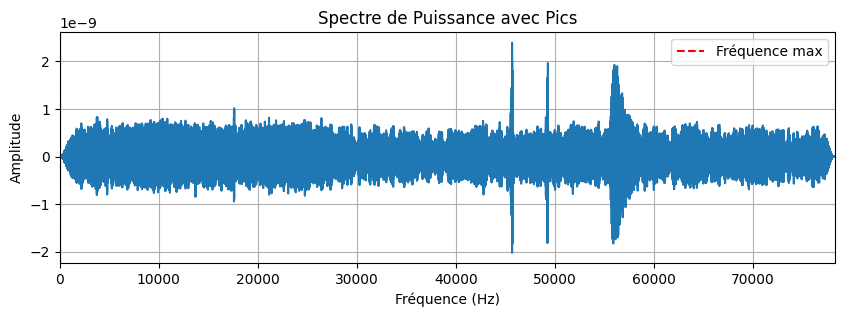

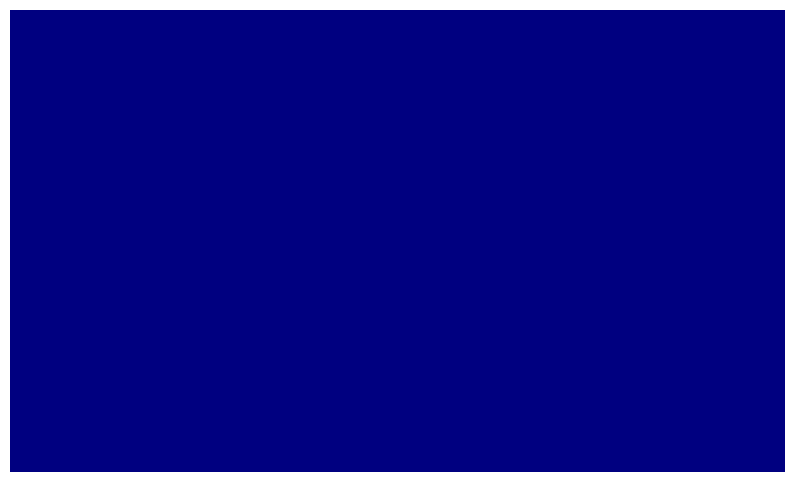

Largeur à mi-hauteur (FWHM) : 0.06751996324422149
Pourcentage basé sur la largeur à mi-hauteur : 8.153282835341134
Fréquence maximale : 0.8281322334550957 Hz
Amplitude maximale : 9.508927131894768e-12
0.7606122702108742 0.8956521966993172


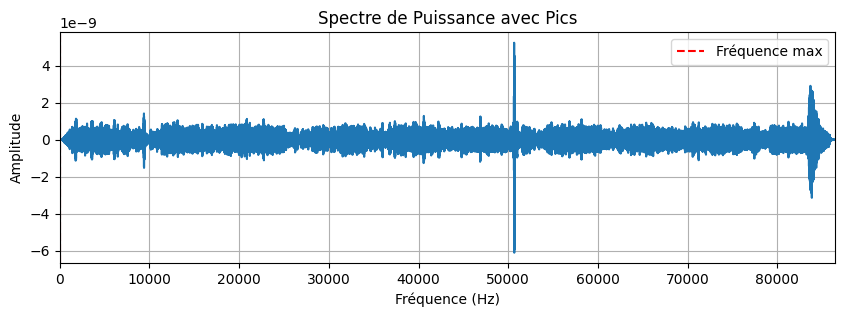

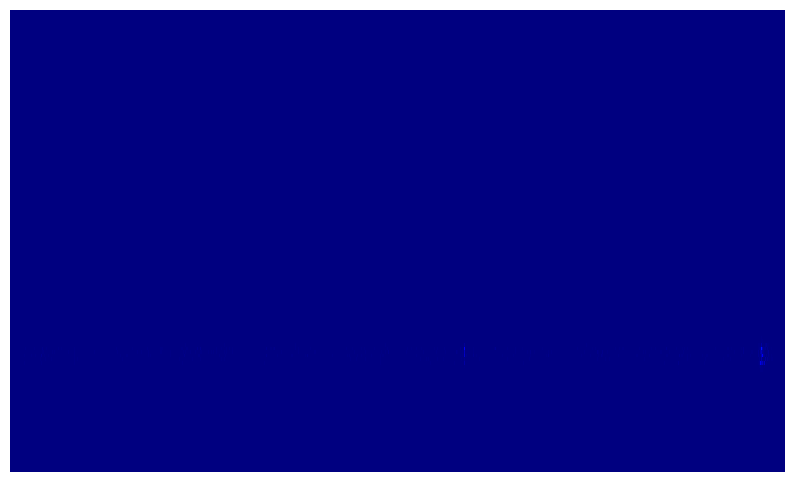

Largeur à mi-hauteur (FWHM) : 1.1573851655510836e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.001397604505873259
Fréquence maximale : 0.8281206598056292 Hz
Amplitude maximale : 2.3691403690066408e-11
0.8281090859539737 0.8281322336572847


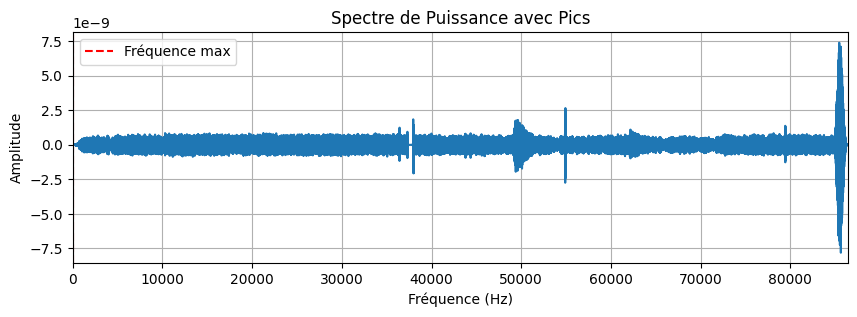

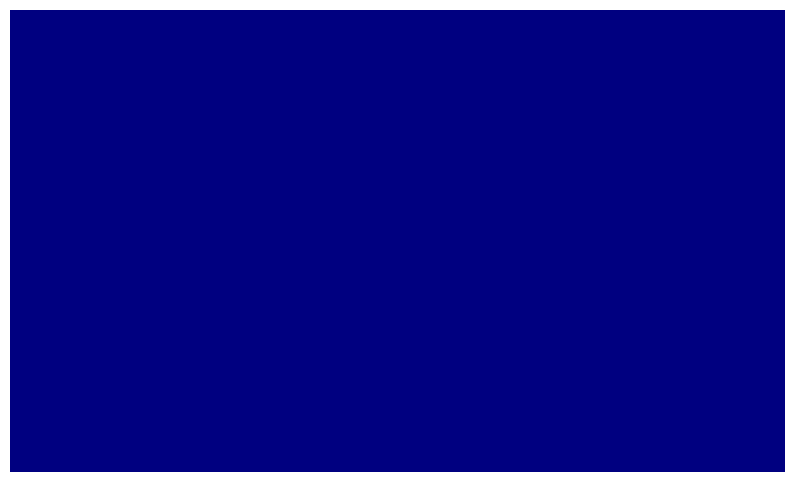

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1972-11-14HR00_evid00081.csv
Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1977-04-17HR00_evid00249.csv
Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1975-03-26HR00_evid00186.csv
Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-12-15HR00_evid00172.csv
Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281206587741906 Hz
Amplitude maximale : 1.8516177356593288e-11
0.7867146258354811 0.8695266917129001


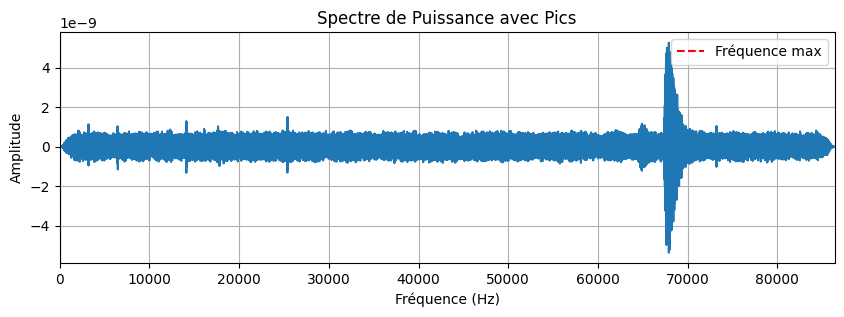

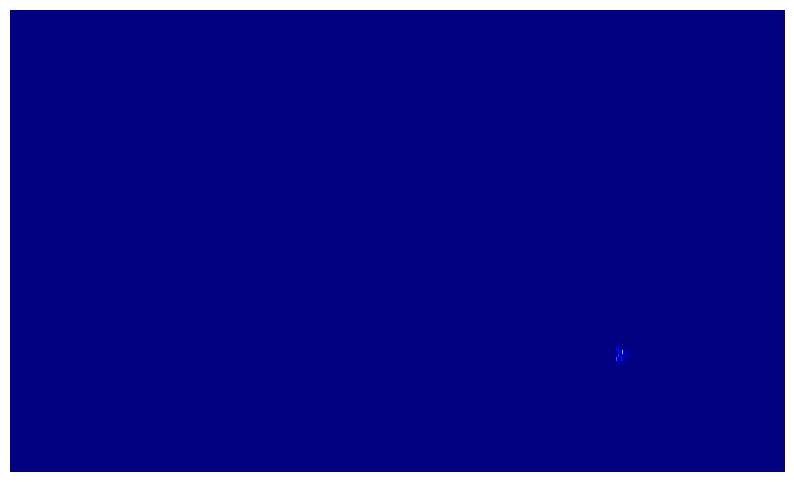

Largeur à mi-hauteur (FWHM) : 0.12251993745796319
Pourcentage basé sur la largeur à mi-hauteur : 14.794834525939176
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 1.0379537890437237e-11
0.7056065092633841 0.9506463841793105


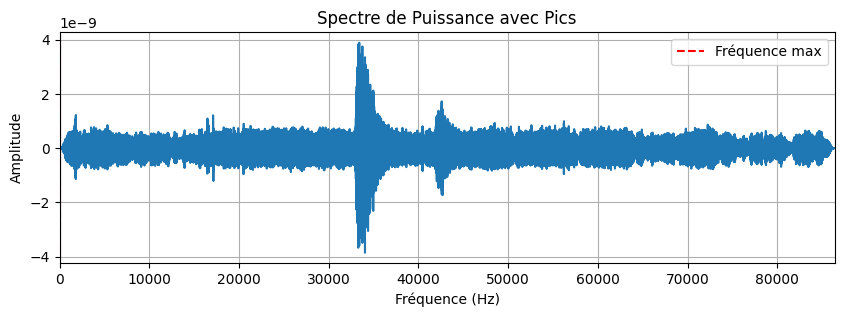

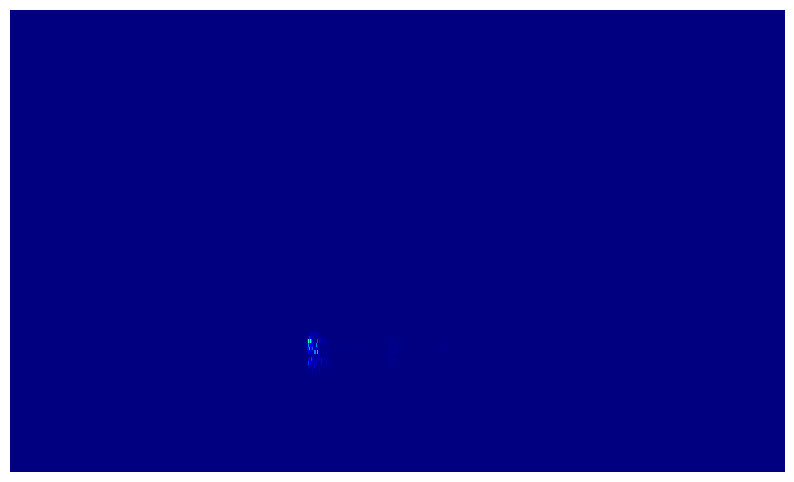

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1975-02-19HR00_evid00180.csv
Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1977-06-02HR00_evid00255.csv
Largeur à mi-hauteur (FWHM) : 0.9277312326292749
Pourcentage basé sur la largeur à mi-hauteur : 99.51954710797153
Fréquence maximale : 0.9322100628359505 Hz
Amplitude maximale : 2.5821899752543384e-11
0.004478830206675721 1.8599412954652252


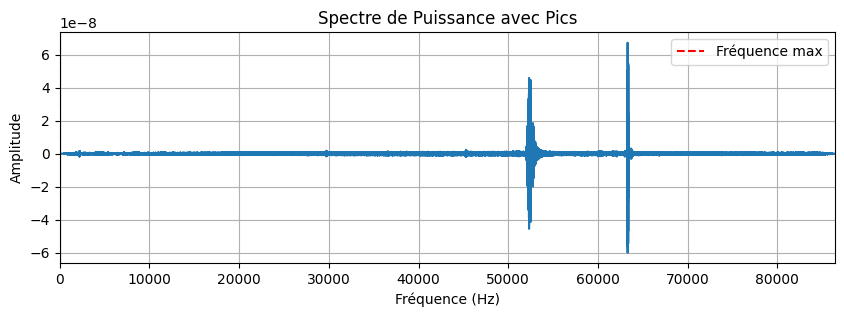

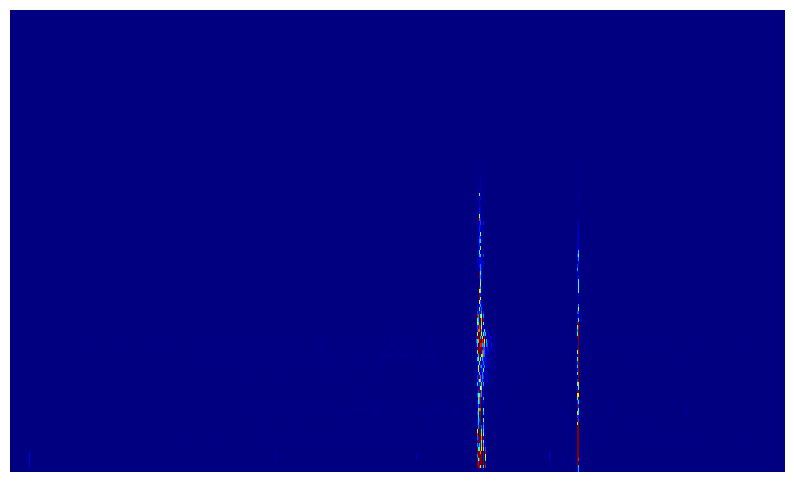

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-12-12HR02_evid00168.csv
Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1973-07-31HR00_evid00123.csv
Largeur à mi-hauteur (FWHM) : 2.4125737883462506e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.002913286040995411
Fréquence maximale : 0.8281280157172356 Hz
Amplitude maximale : 2.7490372237793936e-11
0.8281038899793521 0.8281521414551191


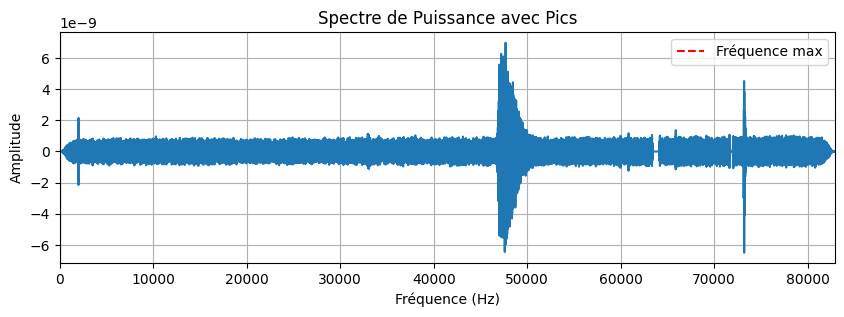

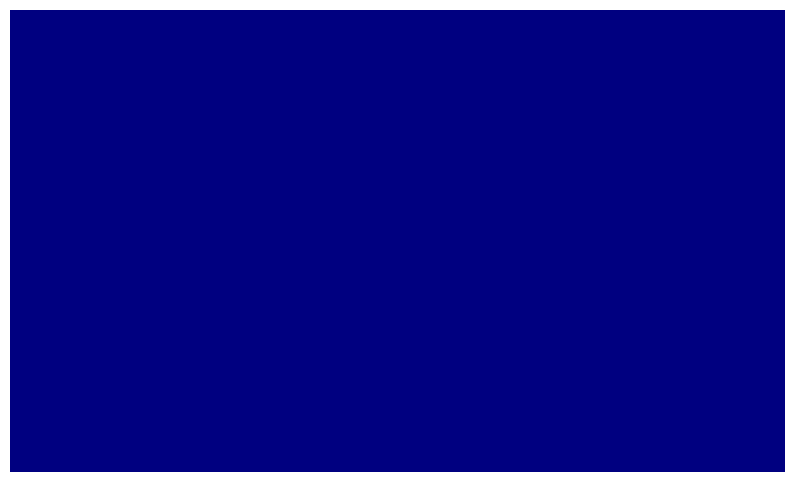

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1972-11-06HR00_evid00079.csv
Largeur à mi-hauteur (FWHM) : 1.1573710120837966e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.0013975849731557841
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 5.830102852665277e-11
0.8281105328623489 0.8281336802825906


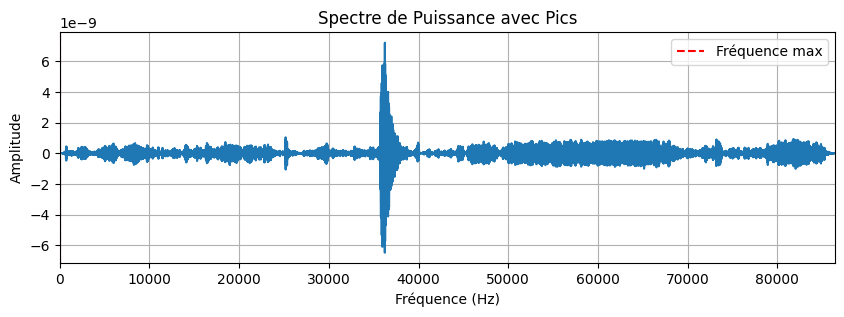

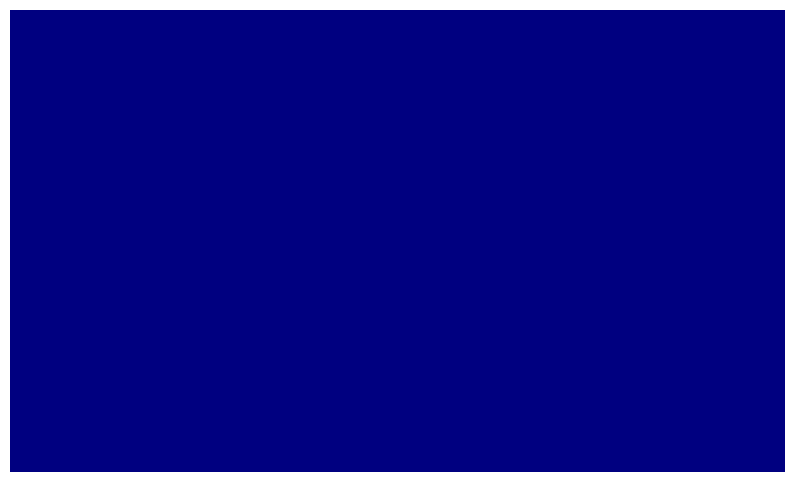

Largeur à mi-hauteur (FWHM) : 0.9604139626128716
Pourcentage basé sur la largeur à mi-hauteur : 115.97512403046608
Fréquence maximale : 0.8281206600482494 Hz
Amplitude maximale : 9.11045970183755e-12
0.0001 1.788534622661121


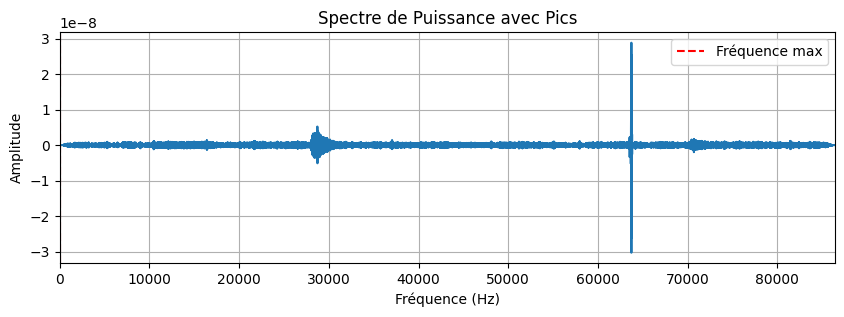

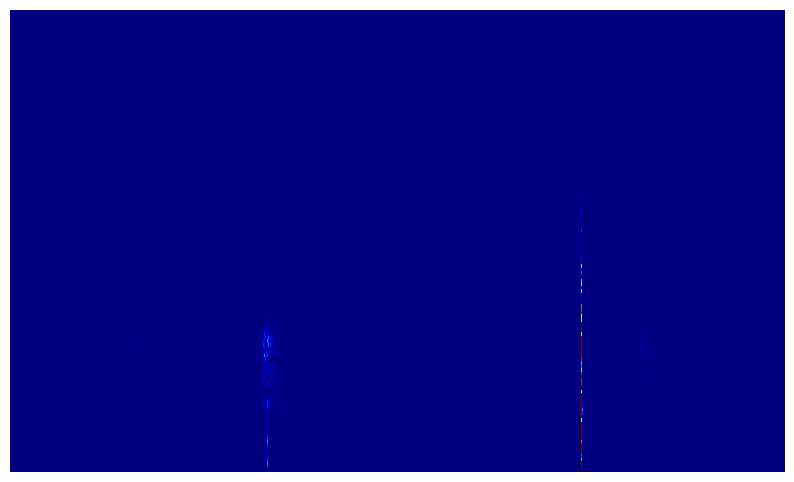

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1972-09-10HR00_evid00075.csv
Largeur à mi-hauteur (FWHM) : 1.1573710120837966e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.0013975849731557841
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 7.682094915508118e-11
0.8281105328623489 0.8281336802825906


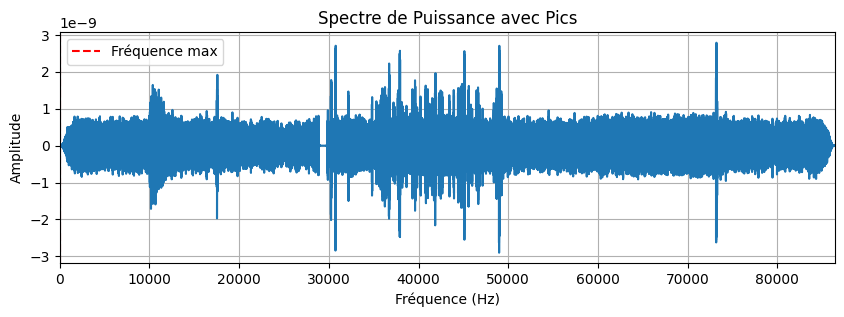

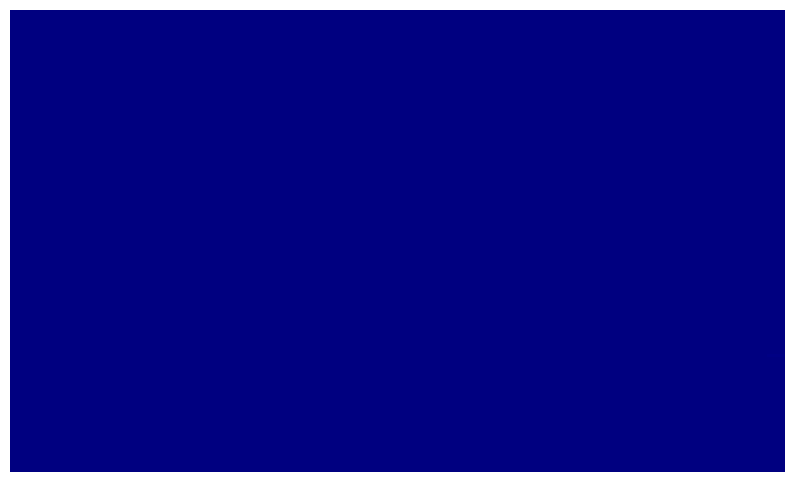

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeB/xa.s16.00.mhz.1973-08-25HR00_evid00443.csv
Largeur à mi-hauteur (FWHM) : 0.7547795055361641
Pourcentage basé sur la largeur à mi-hauteur : 91.14350402504472
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 5.2766008548905745e-12
0.07334260103630563 1.582901612108634


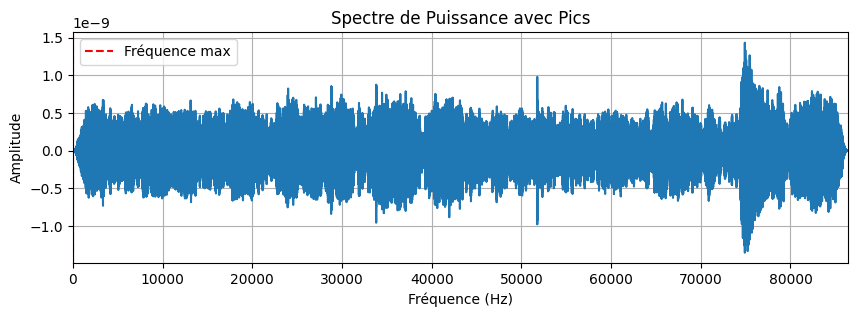

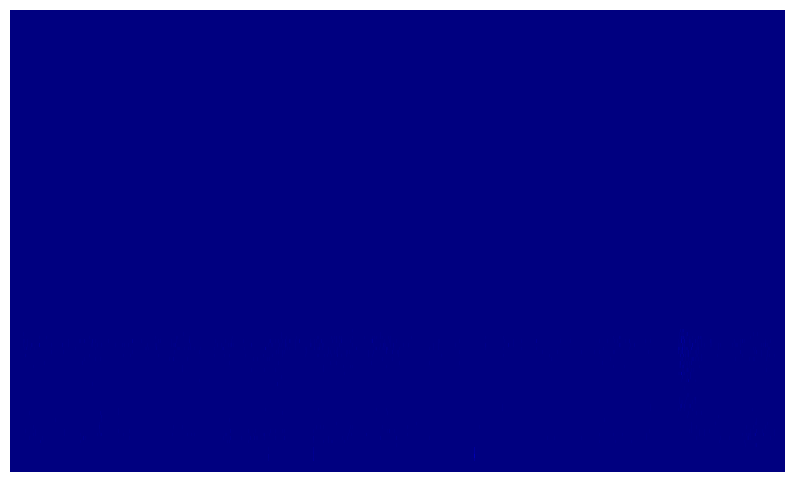

Skipped non-mseed file: ../data/lunar/test/data/S16_GradeB/xa.s16.00.mhz.1973-12-18HR00_evid00487.csv
Skipped non-mseed file: ../data/lunar/test/data/S16_GradeB/xa.s16.00.mhz.1974-11-14HR00_evid00587.csv
Largeur à mi-hauteur (FWHM) : 3.4720827080669814e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.004192696323004957
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 1.3975412011271746e-11
0.8280917258740477 0.828161167528209


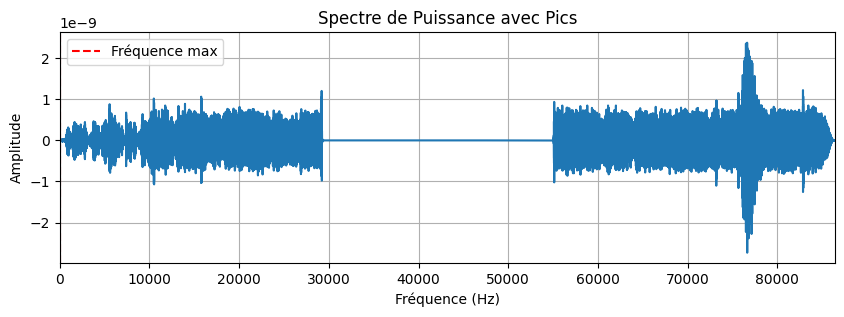

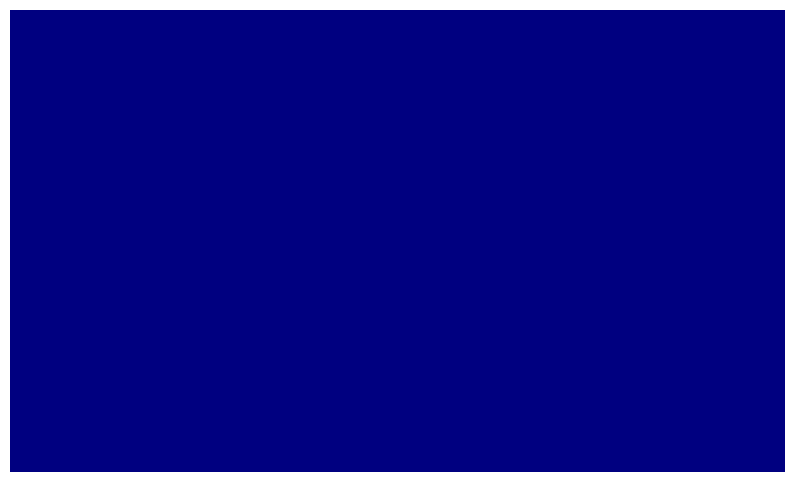

In [16]:
#Boucle sur les fichiers de test
for i, path in enumerate(FILES):  # Utiliser enumerate pour obtenir l'index
    if path.endswith('.mseed'):  # Vérifier si le fichier a l'extension .mseed
        result = spectrogramme(path)  
    else:
        print(f'Skipped non-mseed file: {path}')  # Message pour les fichiers non valides

print(image_paths)


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chargement des images
def load_images(image_paths1):
    images = []
    for path in image_paths1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Charger en niveaux de gris
        img = cv2.resize(img, (224, 224))  # Redimensionner
        img = img / 255.0  # Normaliser
        images.append(img)
    return np.array(images)

labels = [0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0]
image_paths1 = [f'../entrainement.ipynb/spectrogram_{i}.png' for i in range(77)]
print(labels, image_paths1)

# Prétraitement
X = load_images(image_paths1)
y = np.array(labels)

# Ajouter une dimension pour les canaux
X = X.reshape(X.shape[0], 224, 224, 1)  # (nombre d'exemples, hauteur, largeur, 1)

# Division de l'ensemble de données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création d'un générateur d'images pour l'entraînement
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Retourner verticalement
    brightness_range=[0.8, 1.2],  # Ajustement de la luminosité
    fill_mode='nearest',  # Remplissage des pixels vides
)

# Modèle simple avec TensorFlow/Keras
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Pour la classification binaire
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement
model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=60)

# Évaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

2024-10-06 14:53:06.801571: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 14:53:06.865925: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 14:53:06.956235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 14:53:07.030197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 14:53:07.049607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 14:53:07.171257: I tensorflow/core/platform/cpu_feature_gu

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0] ['../entrainement.ipynb/spectrogram_0.png', '../entrainement.ipynb/spectrogram_1.png', '../entrainement.ipynb/spectrogram_2.png', '../entrainement.ipynb/spectrogram_3.png', '../entrainement.ipynb/spectrogram_4.png', '../entrainement.ipynb/spectrogram_5.png', '../entrainement.ipynb/spectrogram_6.png', '../entrainement.ipynb/spectrogram_7.png', '../entrainement.ipynb/spectrogram_8.png', '../entrainement.ipynb/spectrogram_9.png', '../entrainement.ipynb/spectrogram_10.png', '../entrainement.ipynb/spectrogram_11.png', '../entrainement.ipynb/spectrogram_12.png', '../entrainement.ipynb/spectrogram_13.png', '../entrainement.ipynb/spectrogram_14.png', '../entrainement.ipynb/spectrogram_15.png', '../entrainement.ipynb/spectrogram_16.png', '../entrainement.ipynb/spectr

In [18]:


# Fonction pour charger et prétraiter les nouvelles images
def load_new_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Charger en niveaux de gris
        img = cv2.resize(img, (224, 224))  # Redimensionner
        img = img / 255.0  # Normaliser
        images.append(img)
    return np.array(images)

# Charger les nouvelles images
new_X = load_new_images(image_paths)

# Ajouter une dimension pour les canaux
new_X = new_X.reshape(new_X.shape[0], 224, 224, 1)

# Faire des prédictions
predictions = model.predict(new_X)

# Convertir les probabilités en classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype(int)

# Afficher les résultats
for i, path in enumerate(image_paths):
    print(f'Image: {path} -> Prédiction: {predicted_classes[i][0]}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: ../entrainement.ipynb//spectrogram_0.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_1.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_2.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_3.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_4.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_5.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_6.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_7.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_8.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_9.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_10.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_11.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_12.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_13.png -> Prédiction: 0
Image: ../entrainement.ipynb//spectrogram_14.png